<a href="https://colab.research.google.com/github/Joey1211/AH2179_AIcourse/blob/main/project_2179.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 安装必要的库（如果需要）
# Install necessary libraries if needed
!pip install xgboost lightgbm scikit-learn matplotlib seaborn pandas numpy -q


In [ ]:
# 导入基础库 Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# 导入机器学习库 Import ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import lightgbm as lgb

# 设置随机种子 Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 设置绘图风格 Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# 设置显示选项 Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# 设置图表字体大小 Set plot font sizes
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ 环境准备完成 Environment setup completed")


✅ 环境准备完成 Environment setup completed


In [ ]:
# 加载数据，使用第一行作为列名 Reload data with first row as column names
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv'

df = pd.read_csv(url, header=1)  # 使用第二行作为列名 Use second row as column names

# 删除不必要的分组标题列 Remove unnecessary group header columns
columns_to_drop = ['Basic information', 'Categorical varibles', 'Categorical variables (dummy variables)']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# 重命名列（去除Unnamed前缀）Rename columns to remove Unnamed prefix
# 获取正确的列名 Get correct column names
new_columns = []
for col in df.columns:
    if 'Unnamed' not in col:
        new_columns.append(col)
    else:
        new_columns.append(col)  # 暂时保留，后面会看到实际内容

df.columns = new_columns

print("\n" + "="*80)
print("重新加载后的数据信息 Reloaded Data Information")
print("="*80)
print(f"数据形状 Shape: {df.shape}")
print(f"数据大小 Size: {df.shape[0]:,} 行 rows × {df.shape[1]} 列 columns")

print("\n前5行数据 First 5 rows:")
print(df.head())

print("\n数据列名 Column names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")



重新加载后的数据信息 Reloaded Data Information
数据形状 Shape: (545103, 31)
数据大小 Size: 545,103 行 rows × 31 列 columns

前5行数据 First 5 rows:
   Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  dwell_time  \
0       20220108         4   41344              1            151           0   
1       20220108         4   41344              2            185          24   
2       20220108         4   41344              3            186           0   
3       20220108         4   41344              4            202          12   
4       20220108         4   41344              5            242          21   

   travel_time_for_previous_section  scheduled_travel_time  \
0                                 0                    120   
1                               171                     45   
2                                55                     41   
3                                42                     94   
4                                98                     86   

   upstream_stop_dela

In [ ]:
# 根据数据描述文档，手动设置正确的列名
# Manually set correct column names based on data description

correct_columns = [
    # 基本信息 Basic information
    'Calendar_date',
    'route_id',
    'bus_id',
    'stop_sequence',

    # 目标变量 Target variable
    'arrival_delay',

    # 运营数据 Operational data
    'dwell_time',
    'travel_time_for_previous_section',
    'scheduled_travel_time',
    'upstream_stop_delay',
    'origin_delay',
    'previous_bus_delay',
    'previous_trip_travel_time',
    'traffic_condition',
    'recurrent_delay',

    # 分类变量原始值 Original categorical variables
    'weather',
    'temperature',
    'day_of_week',
    'time_of_day',

    # 分类变量哑变量 Dummy variables
    'factor(weather)Light_Rain',
    'factor(weather)Light_Snow',
    'factor(weather)Normal',
    'factor(weather)Rain',
    'factor(weather)Snow',
    'factor(temperature)Cold',
    'factor(temperature)Extra_cold',
    'factor(temperature)Normal',
    'factor(day_of_week)weekday',
    'factor(day_of_week)weekend',
    'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak',
    'factor(time_of_day)Off-peak'
]

# 检查列数是否匹配 Check if column count matches
if len(df.columns) == len(correct_columns):
    df.columns = correct_columns
    print("✅ 列名设置成功 Column names set successfully!")
else:
    print(f"⚠️ 警告：列数不匹配 Warning: Column count mismatch")
    print(f"   数据列数 Data columns: {len(df.columns)}")
    print(f"   预期列数 Expected columns: {len(correct_columns)}")
    print(f"   差异 Difference: {len(df.columns) - len(correct_columns)}")

# 显示更新后的数据 Display updated data
print("\n" + "="*80)
print("更新后的数据前5行 Updated Data - First 5 Rows")
print("="*80)
print(df.head())

print("\n" + "="*80)
print("数据列名（按类别分组）Column Names by Category")
print("="*80)
print("\n【基本信息 Basic Info】")
print(df.columns[:4].tolist())
print("\n【目标变量 Target Variable】")
print([df.columns[4]])
print("\n【运营数据 Operational Data】")
print(df.columns[5:14].tolist())
print("\n【分类变量原始 Categorical Original】")
print(df.columns[14:18].tolist())
print("\n【天气哑变量 Weather Dummies】")
print(df.columns[18:23].tolist())
print("\n【温度哑变量 Temperature Dummies】")
print(df.columns[23:26].tolist())
print("\n【星期哑变量 Day of Week Dummies】")
print(df.columns[26:28].tolist())
print("\n【时段哑变量 Time of Day Dummies】")
print(df.columns[28:31].tolist())


✅ 列名设置成功 Column names set successfully!

更新后的数据前5行 Updated Data - First 5 Rows
   Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  dwell_time  \
0       20220108         4   41344              1            151           0   
1       20220108         4   41344              2            185          24   
2       20220108         4   41344              3            186           0   
3       20220108         4   41344              4            202          12   
4       20220108         4   41344              5            242          21   

   travel_time_for_previous_section  scheduled_travel_time  \
0                                 0                    120   
1                               171                     45   
2                                55                     41   
3                                42                     94   
4                                98                     86   

   upstream_stop_delay  origin_delay  previous_bus_delay  \
0      

In [ ]:
# 转换数据类型 Convert data types
print("正在转换数据类型... Converting data types...")

# 转换日期 Convert date
df['Calendar_date'] = pd.to_datetime(df['Calendar_date'], format='%Y%m%d')

# 转换数值列 Convert numerical columns
numerical_cols = [
    'route_id', 'bus_id', 'stop_sequence', 'arrival_delay', 'dwell_time',
    'travel_time_for_previous_section', 'scheduled_travel_time',
    'upstream_stop_delay', 'origin_delay', 'previous_bus_delay',
    'previous_trip_travel_time', 'traffic_condition', 'recurrent_delay'
]

for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 转换哑变量为整数 Convert dummy variables to integer
dummy_cols = [col for col in df.columns if 'factor(' in col]
for col in dummy_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

print("✅ 数据类型转换完成 Data type conversion completed!")

# 最终数据验证 Final data validation
print("\n" + "="*80)
print("最终数据验证 Final Data Validation")
print("="*80)
print(f"数据形状 Shape: {df.shape}")
print(f"数据大小 Size: {df.shape[0]:,} 行 rows × {df.shape[1]} 列 columns")

print("\n数据类型 Data types:")
print(df.dtypes)

print("\n缺失值统计 Missing values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    '缺失数量 Count': missing,
    '缺失比例% Percentage': missing_pct
})
missing_summary = missing_df[missing_df['缺失数量 Count'] > 0].sort_values(
    '缺失数量 Count', ascending=False
)

if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("✅ 没有缺失值 No missing values!")

print("\n数值型变量统计摘要 Numerical Variables Summary:")
print(df[numerical_cols].describe())


正在转换数据类型... Converting data types...
✅ 数据类型转换完成 Data type conversion completed!

最终数据验证 Final Data Validation
数据形状 Shape: (545103, 31)
数据大小 Size: 545,103 行 rows × 31 列 columns

数据类型 Data types:
Calendar_date                        datetime64[ns]
route_id                                      int64
bus_id                                        int64
stop_sequence                                 int64
arrival_delay                                 int64
dwell_time                                    int64
travel_time_for_previous_section              int64
scheduled_travel_time                         int64
upstream_stop_delay                           int64
origin_delay                                  int64
previous_bus_delay                            int64
previous_trip_travel_time                     int64
traffic_condition                           float64
recurrent_delay                             float64
weather                                      object
temperature               

# 描述性分析
## 数据预处理

In [ ]:
# 创建分析用的数据副本 Create a copy for analysis
df_analysis = df.copy()

print("正在提取时间特征... Extracting temporal features...")

# 提取时间特征 Extract temporal features
df_analysis['year'] = df_analysis['Calendar_date'].dt.year
df_analysis['month'] = df_analysis['Calendar_date'].dt.month
df_analysis['day'] = df_analysis['Calendar_date'].dt.day
df_analysis['weekday'] = df_analysis['Calendar_date'].dt.weekday  # 0=Monday, 6=Sunday
df_analysis['week'] = df_analysis['Calendar_date'].dt.isocalendar().week
df_analysis['day_of_year'] = df_analysis['Calendar_date'].dt.dayofyear

# 创建更友好的分类变量 Create user-friendly categorical variables
# 星期名称 Weekday names
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_analysis['weekday_name'] = df_analysis['weekday'].map(weekday_map)

# 月份名称 Month names
month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
             5: 'May', 6: 'June', 7: 'July', 8: 'August',
             9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df_analysis['month_name'] = df_analysis['month'].map(month_map)

# 工作日/周末 Weekday/Weekend
df_analysis['is_weekend'] = df_analysis['factor(day_of_week)weekend']
df_analysis['day_type'] = df_analysis['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

print("✅ 时间特征提取完成 Temporal features extracted!")

# 显示时间特征样例 Display sample of temporal features
print("\n时间特征样例 Sample of Temporal Features:")
print(df_analysis[['Calendar_date', 'year', 'month', 'month_name', 'weekday',
                    'weekday_name', 'day_type']].head(10))

# 数据时间范围 Data time range
print("\n" + "="*80)
print("数据时间范围 Data Time Range")
print("="*80)
print(f"起始日期 Start date: {df_analysis['Calendar_date'].min().strftime('%Y-%m-%d')}")
print(f"结束日期 End date: {df_analysis['Calendar_date'].max().strftime('%Y-%m-%d')}")
print(f"时间跨度 Time span: {(df_analysis['Calendar_date'].max() - df_analysis['Calendar_date'].min()).days} 天 days")
print(f"月份范围 Month range: {df_analysis['month'].min()} 到 to {df_analysis['month'].max()}")


正在提取时间特征... Extracting temporal features...
✅ 时间特征提取完成 Temporal features extracted!

时间特征样例 Sample of Temporal Features:
  Calendar_date  year  month month_name  weekday weekday_name day_type
0    2022-01-08  2022      1    January        5     Saturday  Weekend
1    2022-01-08  2022      1    January        5     Saturday  Weekend
2    2022-01-08  2022      1    January        5     Saturday  Weekend
3    2022-01-08  2022      1    January        5     Saturday  Weekend
4    2022-01-08  2022      1    January        5     Saturday  Weekend
5    2022-01-08  2022      1    January        5     Saturday  Weekend
6    2022-01-08  2022      1    January        5     Saturday  Weekend
7    2022-01-08  2022      1    January        5     Saturday  Weekend
8    2022-01-08  2022      1    January        5     Saturday  Weekend
9    2022-01-08  2022      1    January        5     Saturday  Weekend

数据时间范围 Data Time Range
起始日期 Start date: 2022-01-08
结束日期 End date: 2022-06-30
时间跨度 Time span: 173 

## 基本统计

In [ ]:
# 选择关键数值变量 Select key numerical variables
key_vars = ['arrival_delay', 'dwell_time', 'travel_time_for_previous_section',
            'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
            'previous_bus_delay', 'recurrent_delay', 'traffic_condition']

print("="*80)
print("关键变量描述性统计 Descriptive Statistics of Key Variables")
print("="*80)

# 计算描述性统计 Calculate descriptive statistics
desc_stats = df_analysis[key_vars].describe().T
desc_stats['median'] = df_analysis[key_vars].median()
desc_stats['skewness'] = df_analysis[key_vars].skew()
desc_stats['kurtosis'] = df_analysis[key_vars].kurtosis()

# 重新排列列顺序 Reorder columns
desc_stats = desc_stats[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis']]
print(desc_stats.round(2))


关键变量描述性统计 Descriptive Statistics of Key Variables
                                     count   mean  median    std      min  \
arrival_delay                    545103.00 134.97   88.00 193.90 -3493.00   
dwell_time                       545103.00  31.99   25.00  27.22     0.00   
travel_time_for_previous_section 545103.00  71.44   64.00  37.59     0.00   
scheduled_travel_time            545103.00 105.92  104.00  36.42    38.00   
upstream_stop_delay              545103.00 135.65   86.00 190.27 -3403.00   
origin_delay                     545103.00  75.11   27.00 133.63 -3061.00   
previous_bus_delay               545103.00 134.38   88.00 193.64 -3493.00   
recurrent_delay                  545103.00  72.75   64.61  29.59    27.75   
traffic_condition                545103.00  73.15   65.00  32.32    18.33   

                                   25%    50%    75%     max  skewness  \
arrival_delay                    11.00  88.00 209.00 2257.00      1.35   
dwell_time                     

In [ ]:
print("\n" + "="*80)
print("到站延误详细统计 Detailed Statistics for Arrival Delay")
print("="*80)

# 计算延误相关指标 Calculate delay-related metrics
arrival_delay = df_analysis['arrival_delay']

delay_stats = {
    '样本总数 Total samples': len(arrival_delay),
    '平均延误 Mean delay (seconds)': arrival_delay.mean(),
    '中位数延误 Median delay (seconds)': arrival_delay.median(),
    '标准差 Std deviation (seconds)': arrival_delay.std(),
    '最小值 Min (seconds)': arrival_delay.min(),
    '最大值 Max (seconds)': arrival_delay.max(),
    '25分位数 25th percentile (seconds)': arrival_delay.quantile(0.25),
    '75分位数 75th percentile (seconds)': arrival_delay.quantile(0.75),
    '90分位数 90th percentile (seconds)': arrival_delay.quantile(0.90),
    '95分位数 95th percentile (seconds)': arrival_delay.quantile(0.95),
    '99分位数 99th percentile (seconds)': arrival_delay.quantile(0.99),
}

for key, value in delay_stats.items():
    print(f"{key}: {value:.2f}")

print("\n" + "-"*80)
print("延误分类统计 Delay Category Statistics")
print("-"*80)

# 定义延误类别 Define delay categories
df_analysis['delay_category'] = pd.cut(
    df_analysis['arrival_delay'],
    bins=[-np.inf, -60, 0, 60, 180, 300, np.inf],
    labels=['提前>1分钟 Early>1min', '提前<1分钟 Early<1min', '准点±1分钟 On-time±1min',
            '延误1-3分钟 Delay 1-3min', '延误3-5分钟 Delay 3-5min', '延误>5分钟 Delay>5min']
)

delay_category_stats = df_analysis['delay_category'].value_counts().sort_index()
delay_category_pct = (delay_category_stats / len(df_analysis) * 100).round(2)

delay_summary = pd.DataFrame({
    '数量 Count': delay_category_stats,
    '比例% Percentage': delay_category_pct
})

print(delay_summary)

# 关键性能指标 Key Performance Indicators
print("\n" + "-"*80)
print("关键性能指标 Key Performance Indicators (KPIs)")
print("-"*80)

kpis = {
    '准点率 On-time rate (±60s)': (arrival_delay.abs() <= 60).mean() * 100,
    '准点率 On-time rate (±120s)': (arrival_delay.abs() <= 120).mean() * 100,
    '严重延误率 Severe delay rate (>300s)': (arrival_delay > 300).mean() * 100,
    '提前到达率 Early arrival rate (<-60s)': (arrival_delay < -60).mean() * 100,
    '平均绝对延误 Mean absolute delay (seconds)': arrival_delay.abs().mean(),
}

for key, value in kpis.items():
    print(f"{key}: {value:.2f}%") if '%' in key else print(f"{key}: {value:.2f}")



到站延误详细统计 Detailed Statistics for Arrival Delay
样本总数 Total samples: 545103.00
平均延误 Mean delay (seconds): 134.97
中位数延误 Median delay (seconds): 88.00
标准差 Std deviation (seconds): 193.90
最小值 Min (seconds): -3493.00
最大值 Max (seconds): 2257.00
25分位数 25th percentile (seconds): 11.00
75分位数 75th percentile (seconds): 209.00
90分位数 90th percentile (seconds): 379.00
95分位数 95th percentile (seconds): 513.00
99分位数 99th percentile (seconds): 810.00

--------------------------------------------------------------------------------
延误分类统计 Delay Category Statistics
--------------------------------------------------------------------------------
                      数量 Count  比例% Percentage
delay_category                                
提前>1分钟 Early>1min        36016            6.61
提前<1分钟 Early<1min        80222           14.72
准点±1分钟 On-time±1min     110669           20.30
延误1-3分钟 Delay 1-3min    157829           28.95
延误3-5分钟 Delay 3-5min     78116           14.33
延误>5分钟 Delay>5min        82251       

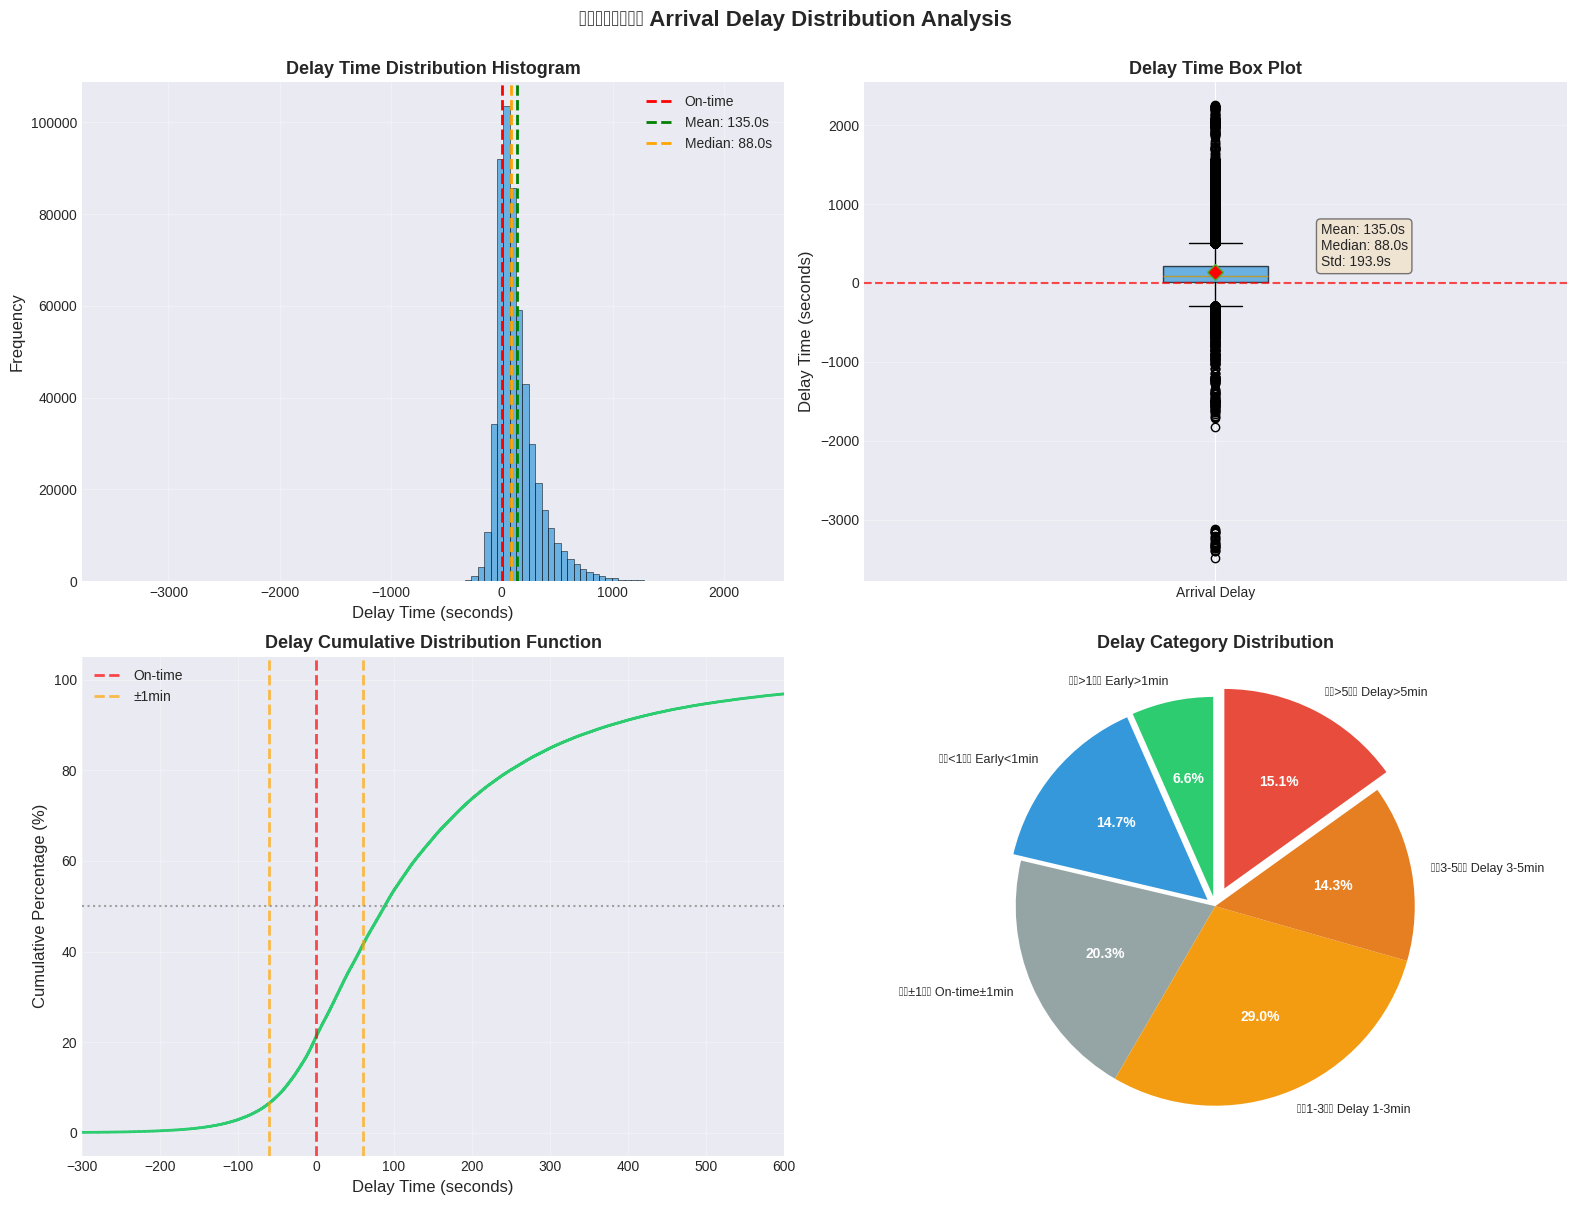

In [ ]:
# 创建延误分布图 Create delay distribution plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('到站延误分布分析 Arrival Delay Distribution Analysis',
             fontsize=16, fontweight='bold', y=1.00)

# 1. 直方图 Histogram
ax1 = axes[0, 0]
ax1.hist(df_analysis['arrival_delay'], bins=100, color='#3498db',
         alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='On-time')
ax1.axvline(x=df_analysis['arrival_delay'].mean(), color='green',
            linestyle='--', linewidth=2, label=f'Mean: {df_analysis["arrival_delay"].mean():.1f}s')
ax1.axvline(x=df_analysis['arrival_delay'].median(), color='orange',
            linestyle='--', linewidth=2, label=f'Median: {df_analysis["arrival_delay"].median():.1f}s')
ax1.set_xlabel('Delay Time (seconds)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Delay Time Distribution Histogram',
              fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 箱线图 Box plot
ax2 = axes[0, 1]
bp = ax2.boxplot([df_analysis['arrival_delay']],
                  labels=['Arrival Delay'],
                  patch_artist=True,
                  showmeans=True,
                  meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][0].set_alpha(0.7)
ax2.set_ylabel('Delay Time (seconds)', fontsize=12)
ax2.set_title('Delay Time Box Plot', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# 添加统计信息 Add statistical info
stats_text = f"Mean: {df_analysis['arrival_delay'].mean():.1f}s\n"
stats_text += f"Median: {df_analysis['arrival_delay'].median():.1f}s\n"
stats_text += f"Std: {df_analysis['arrival_delay'].std():.1f}s"
ax2.text(1.15, df_analysis['arrival_delay'].quantile(0.75), stats_text,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=10)

# 3. 累积分布函数 Cumulative Distribution Function
ax3 = axes[1, 0]
sorted_delays = np.sort(df_analysis['arrival_delay'])
cumulative = np.arange(1, len(sorted_delays) + 1) / len(sorted_delays) * 100
ax3.plot(sorted_delays, cumulative, linewidth=2, color='#2ecc71')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='On-time')
ax3.axvline(x=60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='±1min')
ax3.axvline(x=-60, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax3.axhline(y=50, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('Delay Time (seconds)', fontsize=12)
ax3.set_ylabel('Cumulative Percentage (%)', fontsize=12)
ax3.set_title('Delay Cumulative Distribution Function',
              fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-300, 600)

# 4. 延误类别饼图 Delay category pie chart
ax4 = axes[1, 1]
colors = ['#2ecc71', '#3498db', '#95a5a6', '#f39c12', '#e67e22', '#e74c3c']
explode = (0.05, 0.05, 0, 0, 0, 0.1)  # 突出显示提前和严重延误
wedges, texts, autotexts = ax4.pie(
    delay_category_stats,
    labels=delay_category_stats.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 9}
)
ax4.set_title('Delay Category Distribution',
              fontsize=13, fontweight='bold')

# 美化百分比文字 Beautify percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()



## 时间维度分析


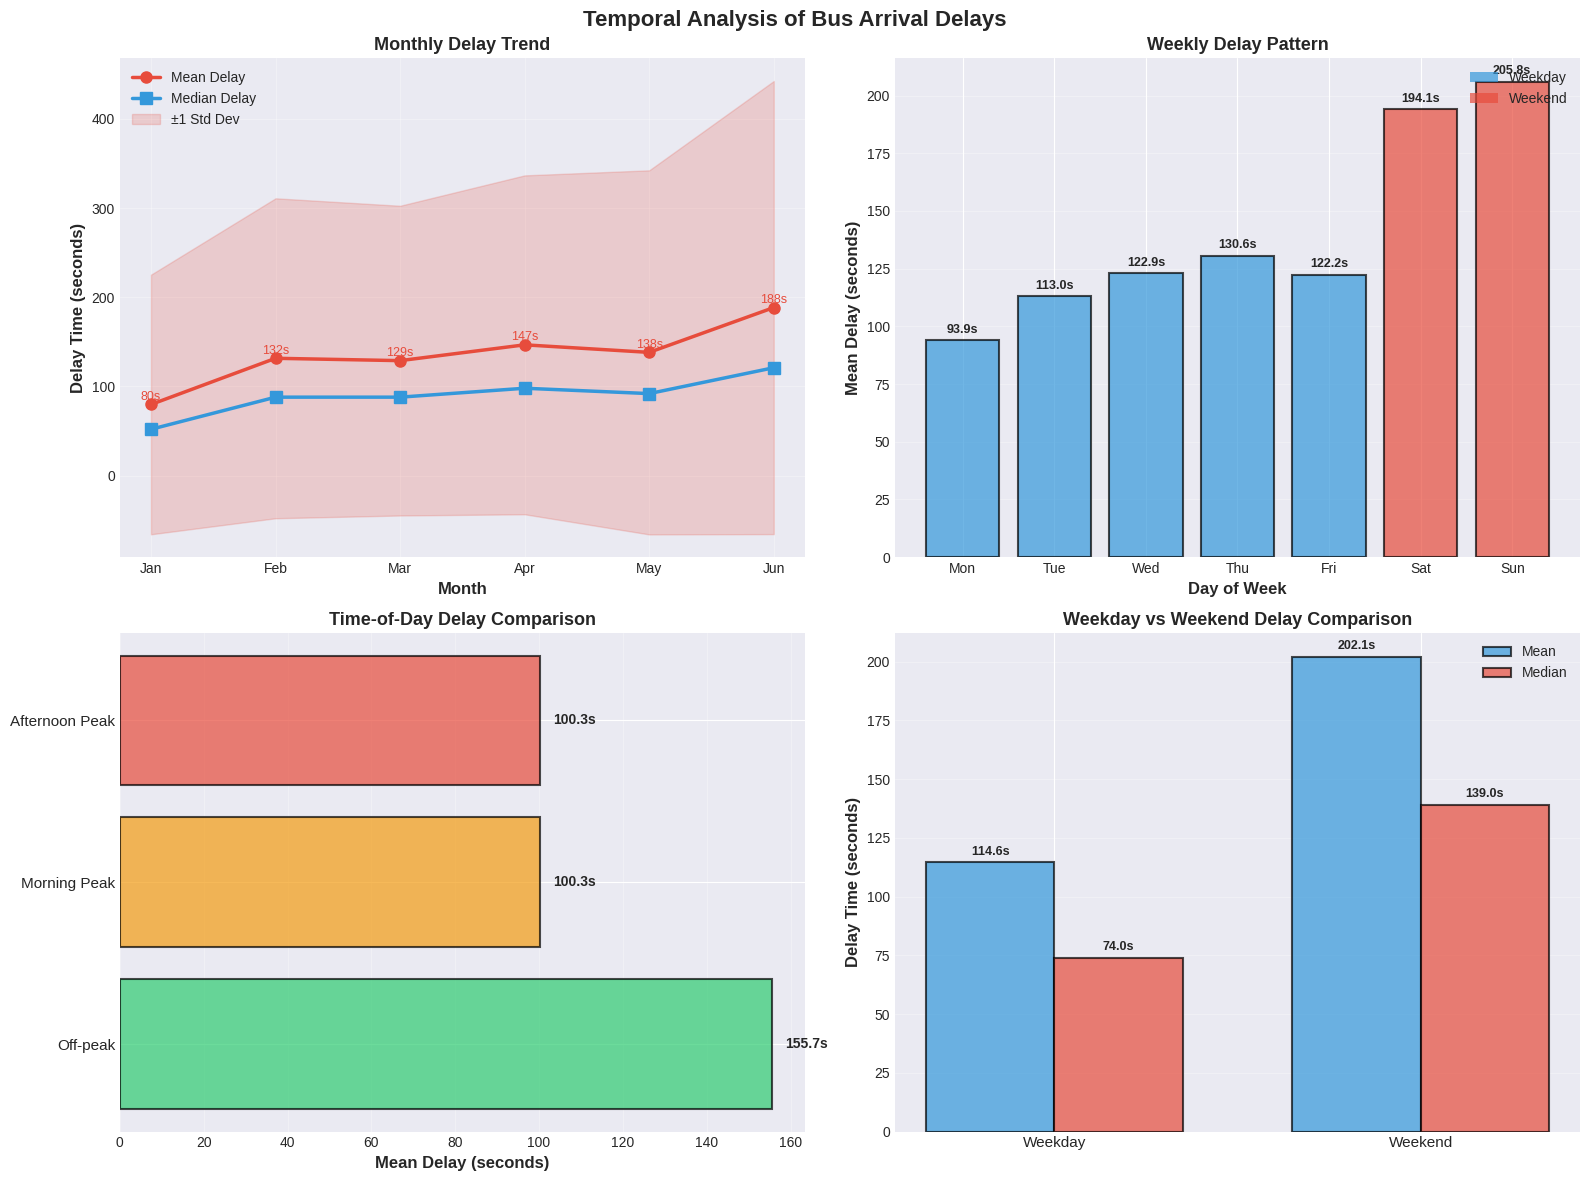


Temporal Statistics Summary


In [ ]:
# 创建时间分析图表 Create temporal analysis plots (English only)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal Analysis of Bus Arrival Delays', fontsize=16, fontweight='bold')

# 1. Monthly Trend
monthly_delay = df_analysis.groupby('month')['arrival_delay'].agg(['mean', 'median', 'std', 'count'])
ax1 = axes[0, 0]
x = monthly_delay.index
ax1.plot(x, monthly_delay['mean'], marker='o', linewidth=2.5, markersize=8,
         label='Mean Delay', color='#e74c3c')
ax1.plot(x, monthly_delay['median'], marker='s', linewidth=2.5, markersize=8,
         label='Median Delay', color='#3498db')
ax1.fill_between(x,
                  monthly_delay['mean'] - monthly_delay['std'],
                  monthly_delay['mean'] + monthly_delay['std'],
                  alpha=0.2, color='#e74c3c', label='±1 Std Dev')
ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('Delay Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Monthly Delay Trend', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, 7))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

# Add value labels
for i, (mean_val, median_val) in enumerate(zip(monthly_delay['mean'], monthly_delay['median']), 1):
    ax1.text(i, mean_val + 5, f'{mean_val:.0f}s', ha='center', fontsize=9, color='#e74c3c')

# 2. Weekly Pattern
weekday_delay = df_analysis.groupby('weekday')['arrival_delay'].agg(['mean', 'std', 'count'])
ax2 = axes[0, 1]
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors = ['#3498db'] * 5 + ['#e74c3c'] * 2  # Blue for weekdays, red for weekends
bars = ax2.bar(range(7), weekday_delay['mean'].values, color=colors, alpha=0.7,
               edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Delay (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Weekly Delay Pattern', fontsize=13, fontweight='bold')
ax2.set_xticks(range(7))
ax2.set_xticklabels(weekday_names, fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', alpha=0.7, label='Weekday'),
                   Patch(facecolor='#e74c3c', alpha=0.7, label='Weekend')]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=10)

# 3. Time of Day Comparison
tod_delay = df_analysis.groupby('time_of_day')['arrival_delay'].agg(['mean', 'median', 'count'])
tod_order = ['OP', 'MP', 'AP']  # Off-peak, Morning peak, Afternoon peak
tod_labels = ['Off-peak', 'Morning Peak', 'Afternoon Peak']
tod_delay_ordered = tod_delay.loc[tod_order]

ax3 = axes[1, 0]
tod_colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax3.barh(range(len(tod_delay_ordered)), tod_delay_ordered['mean'].values,
                color=tod_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_yticks(range(len(tod_delay_ordered)))
ax3.set_yticklabels(tod_labels, fontsize=11)
ax3.set_xlabel('Mean Delay (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Time-of-Day Delay Comparison', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width + 3, bar.get_y() + bar.get_height()/2.,
             f'{width:.1f}s', ha='left', va='center', fontsize=10, fontweight='bold')

# 4. Weekday vs Weekend Comparison
daytype_delay = df_analysis.groupby('day_type')['arrival_delay'].agg(['mean', 'median', 'std', 'count'])
ax4 = axes[1, 1]
x_pos = np.arange(len(daytype_delay))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, daytype_delay['mean'], width,
                label='Mean', color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)
bars2 = ax4.bar(x_pos + width/2, daytype_delay['median'], width,
                label='Median', color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)

ax4.set_ylabel('Delay Time (seconds)', fontsize=12, fontweight='bold')
ax4.set_title('Weekday vs Weekend Delay Comparison', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(daytype_delay.index, fontsize=11)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{height:.1f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Temporal Statistics Summary")
print("="*80)


In [ ]:
# Print detailed temporal statistics
print("\n1. MONTHLY TREND ANALYSIS")
print("-" * 80)
print(f"Highest delay month: Month {monthly_delay['mean'].idxmax()} ({monthly_delay['mean'].max():.2f}s)")
print(f"Lowest delay month: Month {monthly_delay['mean'].idxmin()} ({monthly_delay['mean'].min():.2f}s)")
print(f"Monthly variation (std): {monthly_delay['mean'].std():.2f}s")
print(f"Delay increase from Jan to Jun: {monthly_delay['mean'].iloc[-1] - monthly_delay['mean'].iloc[0]:.2f}s")

print("\n2. WEEKLY PATTERN ANALYSIS")
print("-" * 80)
weekday_avg = weekday_delay['mean'][:5].mean()
weekend_avg = weekday_delay['mean'][5:].mean()
print(f"Weekday average delay: {weekday_avg:.2f}s")
print(f"Weekend average delay: {weekend_avg:.2f}s")
print(f"Difference (Weekend - Weekday): {weekend_avg - weekday_avg:.2f}s ({((weekend_avg - weekday_avg) / weekday_avg * 100):.1f}%)")
print(f"Highest delay day: {weekday_names[weekday_delay['mean'].idxmax()]} ({weekday_delay['mean'].max():.2f}s)")
print(f"Lowest delay day: {weekday_names[weekday_delay['mean'].idxmin()]} ({weekday_delay['mean'].min():.2f}s)")

print("\n3. TIME-OF-DAY ANALYSIS")
print("-" * 80)
for i, (tod, label) in enumerate(zip(tod_order, tod_labels)):
    delay_val = tod_delay.loc[tod, 'mean']
    count = tod_delay.loc[tod, 'count']
    pct = count / len(df_analysis) * 100
    print(f"{label:15s}: {delay_val:6.2f}s (n={count:,}, {pct:.1f}%)")

print(f"\nPeak vs Off-peak difference: {tod_delay.loc['AP', 'mean'] - tod_delay.loc['OP', 'mean']:.2f}s")

print("\n4. WEEKDAY VS WEEKEND ANALYSIS")
print("-" * 80)
for day_type in daytype_delay.index:
    mean_val = daytype_delay.loc[day_type, 'mean']
    median_val = daytype_delay.loc[day_type, 'median']
    std_val = daytype_delay.loc[day_type, 'std']
    count = daytype_delay.loc[day_type, 'count']
    pct = count / len(df_analysis) * 100
    print(f"{day_type:10s}: Mean={mean_val:6.2f}s, Median={median_val:6.2f}s, Std={std_val:6.2f}s (n={count:,}, {pct:.1f}%)")



1. MONTHLY TREND ANALYSIS
--------------------------------------------------------------------------------
Highest delay month: Month 6 (188.45s)
Lowest delay month: Month 1 (79.80s)
Monthly variation (std): 34.92s
Delay increase from Jan to Jun: 108.66s

2. WEEKLY PATTERN ANALYSIS
--------------------------------------------------------------------------------
Weekday average delay: 116.53s
Weekend average delay: 199.98s
Difference (Weekend - Weekday): 83.46s (71.6%)
Highest delay day: Sun (205.85s)
Lowest delay day: Mon (93.87s)

3. TIME-OF-DAY ANALYSIS
--------------------------------------------------------------------------------
Off-peak       : 155.65s (n=341,469, 62.6%)
Morning Peak   : 100.35s (n=89,883, 16.5%)
Afternoon Peak : 100.25s (n=113,751, 20.9%)

Peak vs Off-peak difference: -55.40s

4. WEEKDAY VS WEEKEND ANALYSIS
--------------------------------------------------------------------------------
Weekday   : Mean=114.59s, Median= 74.00s, Std=181.19s (n=418,149, 76.7%)
W


Creating Hourly Delay Heatmap...


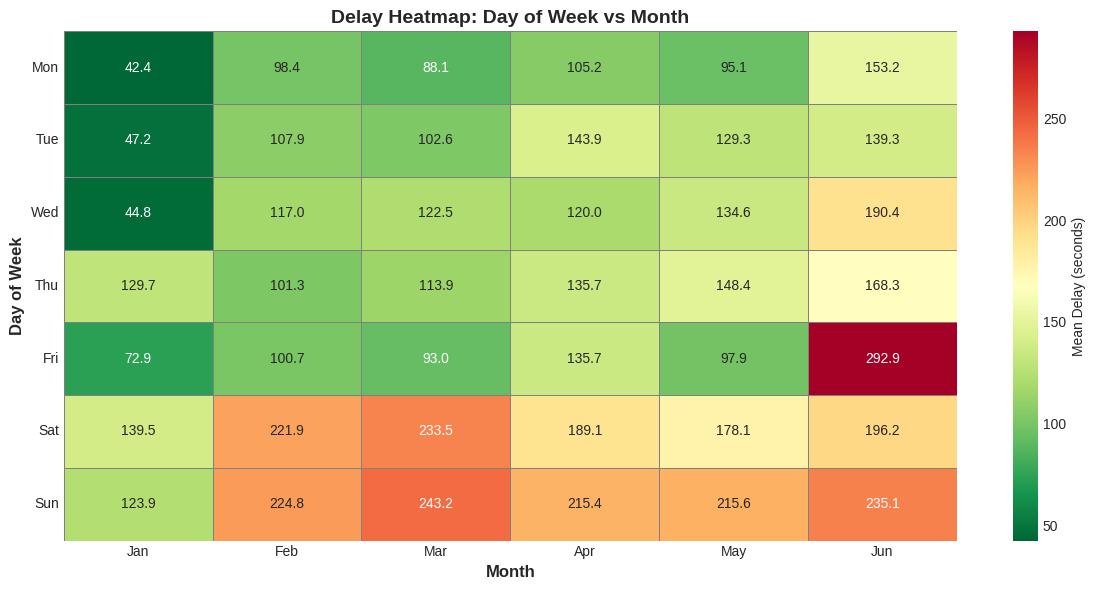

In [ ]:
# 创建小时级别的延误热力图 Create hourly delay heatmap
print("\n" + "="*80)
print("Creating Hourly Delay Heatmap...")
print("="*80)

# 按月份和星期创建延误热力图 Create heatmap by month and weekday
pivot_data = df_analysis.pivot_table(
    values='arrival_delay',
    index='weekday',
    columns='month',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Mean Delay (seconds)'},
            linewidths=0.5, linecolor='gray', ax=ax)

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Day of Week', fontsize=12, fontweight='bold')
ax.set_title('Delay Heatmap: Day of Week vs Month', fontsize=14, fontweight='bold')
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'], rotation=0)

plt.tight_layout()
plt.show()



## 空间维度分析


In [ ]:
print("="*80)
print("SPATIAL ANALYSIS: Stop-wise Delay Statistics")
print("="*80)

# 按站点统计延误 Delay statistics by stop
stop_delay = df_analysis.groupby('stop_sequence')['arrival_delay'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

stop_delay.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max']

# 添加额外统计 Add additional statistics
stop_delay['CV'] = (stop_delay['Std'] / stop_delay['Mean']).round(2)  # Coefficient of Variation
stop_delay['Range'] = stop_delay['Max'] - stop_delay['Min']

print("\nStop-wise Delay Statistics (All 28 stops):")
print(stop_delay)

# 识别问题站点 Identify problematic stops
print("\n" + "-"*80)
print("PROBLEMATIC STOPS IDENTIFICATION")
print("-"*80)

threshold_mean = stop_delay['Mean'].mean() + stop_delay['Mean'].std()
threshold_std = stop_delay['Std'].mean() + stop_delay['Std'].std()

problem_stops_high_delay = stop_delay[stop_delay['Mean'] > threshold_mean].index.tolist()
problem_stops_high_var = stop_delay[stop_delay['Std'] > threshold_std].index.tolist()

print(f"\nStops with HIGH AVERAGE DELAY (>{threshold_mean:.1f}s):")
print(f"Stop sequences: {problem_stops_high_delay}")

print(f"\nStops with HIGH VARIABILITY (std>{threshold_std:.1f}s):")
print(f"Stop sequences: {problem_stops_high_var}")

# 最好和最差的站点 Best and worst stops
print("\n" + "-"*80)
print("TOP 5 BEST PERFORMING STOPS (Lowest Mean Delay)")
print("-"*80)
print(stop_delay.nsmallest(5, 'Mean')[['Mean', 'Median', 'Std']])

print("\n" + "-"*80)
print("TOP 5 WORST PERFORMING STOPS (Highest Mean Delay)")
print("-"*80)
print(stop_delay.nlargest(5, 'Mean')[['Mean', 'Median', 'Std']])


SPATIAL ANALYSIS: Stop-wise Delay Statistics

Stop-wise Delay Statistics (All 28 stops):
               Count   Mean  Median    Std   Min   Max   CV  Range
stop_sequence                                                     
1              20189  63.96   22.00 145.57 -3136  1916 2.28   5052
2              20189 100.14   60.00 150.18 -3114  1894 1.50   5008
3              20189  92.83   54.00 152.24 -3152  1895 1.64   5047
4              20189  65.27   29.00 157.16 -3159  1887 2.41   5046
5              20189 107.41   65.00 156.26 -3175  2079 1.45   5254
6              20189 138.43   97.00 160.27 -3148  2094 1.16   5242
7              20189 128.25   88.00 164.84 -3175  2050 1.29   5225
8              20189 106.23   68.00 171.64 -3229  2067 1.62   5296
9              20189 136.35   93.00 171.47 -3211  2094 1.26   5305
10             20189 161.18  119.00 176.47 -3222  2071 1.09   5293
11             20189 130.10   88.00 179.90 -3263  2068 1.38   5331
12             20189  89.43   49.00 182.

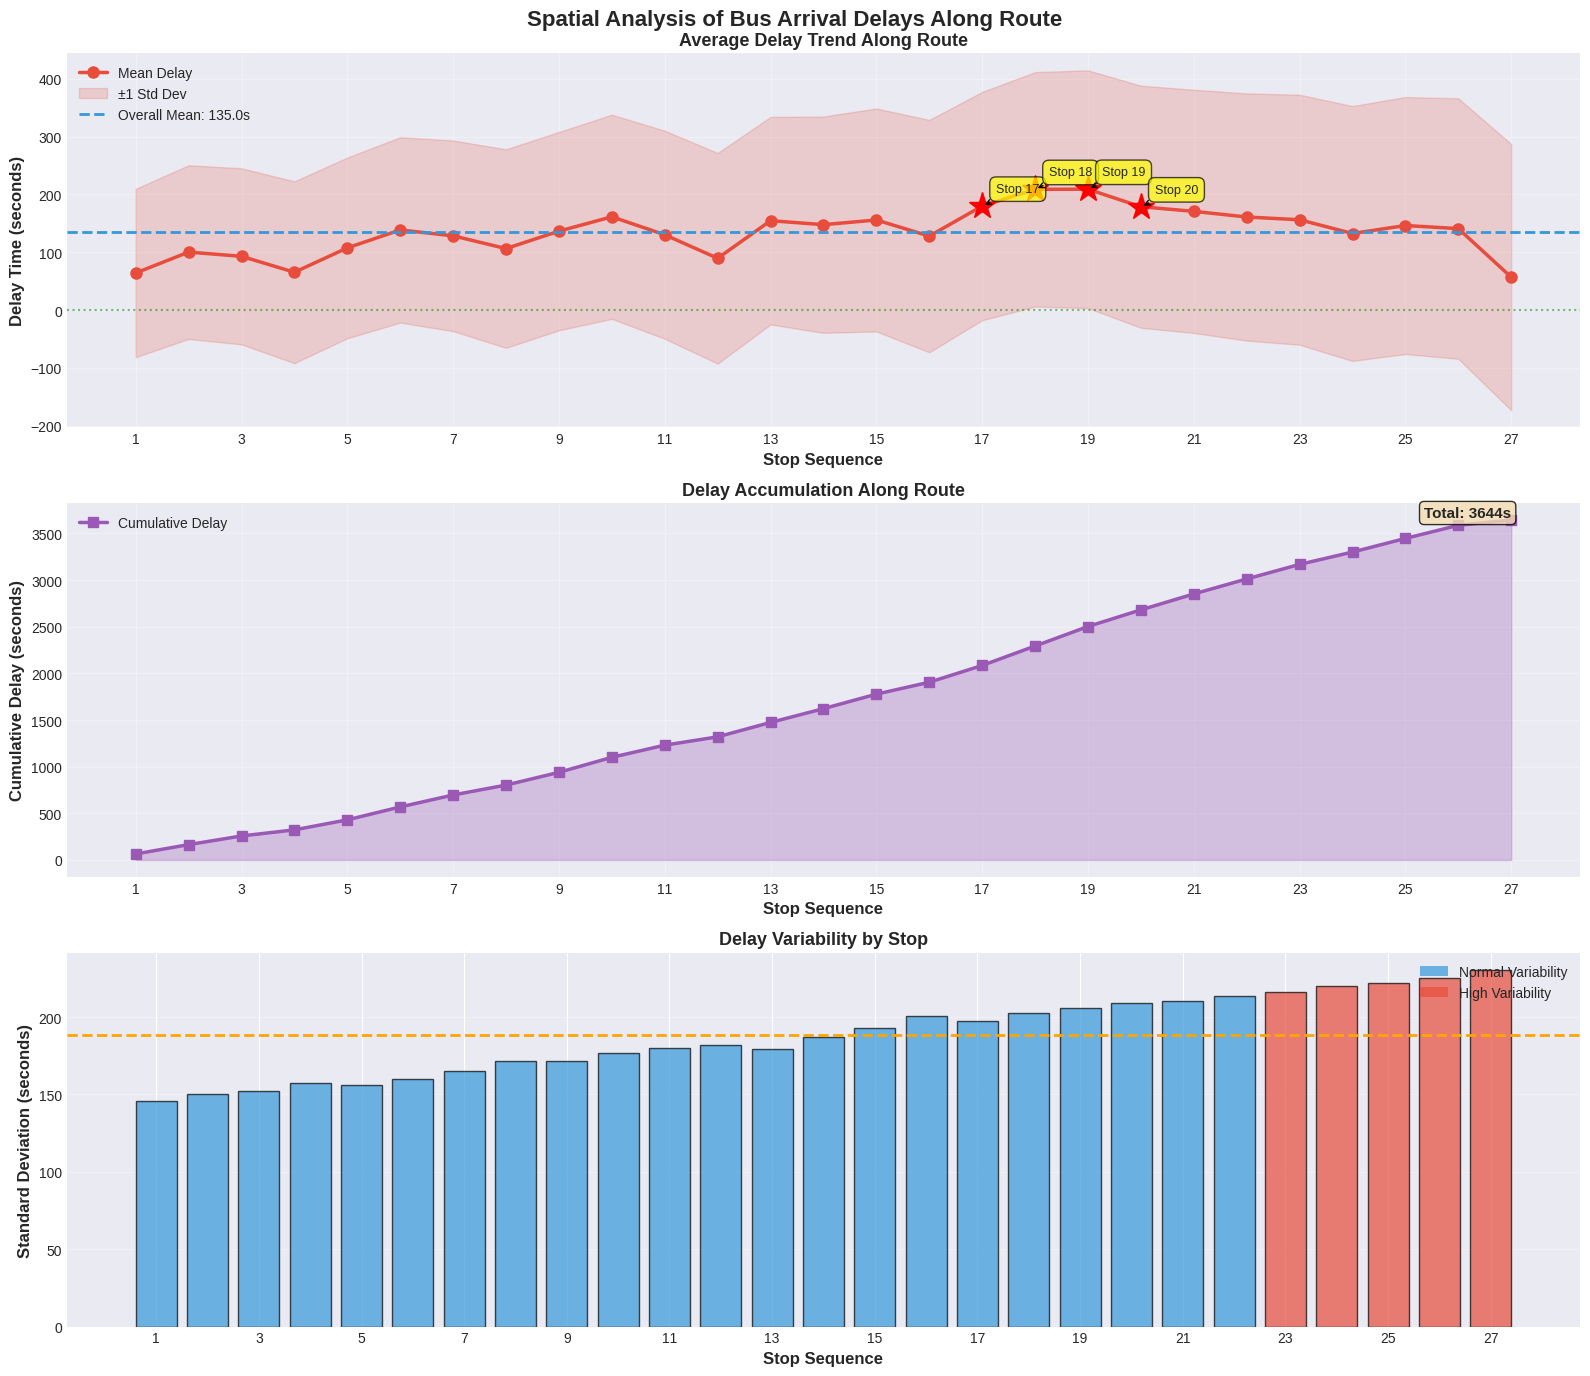

In [ ]:
# 创建空间分析图表 Create spatial analysis plots
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Spatial Analysis of Bus Arrival Delays Along Route',
             fontsize=16, fontweight='bold')

# 1. Stop-wise Average Delay Trend
ax1 = axes[0]
stops = stop_delay.index
ax1.plot(stops, stop_delay['Mean'], marker='o', linewidth=2.5,
         markersize=8, color='#e74c3c', label='Mean Delay')
ax1.fill_between(stops,
                  stop_delay['Mean'] - stop_delay['Std'],
                  stop_delay['Mean'] + stop_delay['Std'],
                  alpha=0.2, color='#e74c3c', label='±1 Std Dev')
ax1.axhline(y=stop_delay['Mean'].mean(), color='#3498db',
            linestyle='--', linewidth=2,
            label=f'Overall Mean: {stop_delay["Mean"].mean():.1f}s')
ax1.axhline(y=0, color='green', linestyle=':', linewidth=1.5, alpha=0.5)

ax1.set_xlabel('Stop Sequence', fontsize=12, fontweight='bold')
ax1.set_ylabel('Delay Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Average Delay Trend Along Route', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(stops[::2])  # Show every other stop

# Mark problematic stops
for stop in problem_stops_high_delay:
    ax1.plot(stop, stop_delay.loc[stop, 'Mean'], 'r*', markersize=20)
    ax1.annotate(f'Stop {stop}',
                 xy=(stop, stop_delay.loc[stop, 'Mean']),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                 fontsize=9)

# 2. Delay Accumulation Effect
ax2 = axes[1]
cumulative_delay = stop_delay['Mean'].cumsum()
ax2.plot(stops, cumulative_delay, marker='s', linewidth=2.5,
         markersize=7, color='#9b59b6', label='Cumulative Delay')
ax2.fill_between(stops, 0, cumulative_delay, alpha=0.3, color='#9b59b6')

ax2.set_xlabel('Stop Sequence', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Delay (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Delay Accumulation Along Route', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(stops[::2])

# Add annotation for total accumulation
total_accum = cumulative_delay.iloc[-1]
ax2.text(stops[-1], total_accum, f'Total: {total_accum:.0f}s',
         ha='right', va='bottom', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Delay Variability by Stop
ax3 = axes[2]
colors_var = ['#e74c3c' if std > threshold_std else '#3498db'
              for std in stop_delay['Std']]
bars = ax3.bar(stops, stop_delay['Std'], color=colors_var, alpha=0.7,
               edgecolor='black', linewidth=1)
ax3.axhline(y=stop_delay['Std'].mean(), color='orange',
            linestyle='--', linewidth=2,
            label=f'Mean Std: {stop_delay["Std"].mean():.1f}s')

ax3.set_xlabel('Stop Sequence', fontsize=12, fontweight='bold')
ax3.set_ylabel('Standard Deviation (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Delay Variability by Stop', fontsize=13, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(stops[::2])

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', alpha=0.7, label='Normal Variability'),
                   Patch(facecolor='#e74c3c', alpha=0.7, label='High Variability')]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()



## 天气和其他因素分析

In [ ]:
print("="*80)
print("WEATHER AND EXTERNAL FACTORS ANALYSIS")
print("="*80)

# 1. Weather Impact Analysis
print("\n1. WEATHER CONDITION IMPACT")
print("-"*80)
weather_delay = df_analysis.groupby('weather')['arrival_delay'].agg([
    'count', 'mean', 'median', 'std'
]).round(2)
weather_delay.columns = ['Count', 'Mean', 'Median', 'Std']
weather_delay['Percentage'] = (weather_delay['Count'] / len(df_analysis) * 100).round(2)
weather_delay = weather_delay.sort_values('Mean', ascending=False)
print(weather_delay)

# 2. Temperature Impact Analysis
print("\n2. TEMPERATURE IMPACT")
print("-"*80)
temp_delay = df_analysis.groupby('temperature')['arrival_delay'].agg([
    'count', 'mean', 'median', 'std'
]).round(2)
temp_delay.columns = ['Count', 'Mean', 'Median', 'Std']
temp_delay['Percentage'] = (temp_delay['Count'] / len(df_analysis) * 100).round(2)
temp_delay = temp_delay.sort_values('Mean', ascending=False)
print(temp_delay)

# 3. Traffic Condition Analysis
print("\n3. TRAFFIC CONDITION CORRELATION")
print("-"*80)
traffic_corr = df_analysis[['arrival_delay', 'traffic_condition']].corr()
print(f"Correlation between arrival_delay and traffic_condition: {traffic_corr.iloc[0, 1]:.4f}")

# Traffic condition statistics
traffic_stats = df_analysis['traffic_condition'].describe()
print(f"\nTraffic Condition Statistics:")
print(f"Mean: {traffic_stats['mean']:.2f}s")
print(f"Median: {traffic_stats['50%']:.2f}s")
print(f"Std: {traffic_stats['std']:.2f}s")
print(f"Min: {traffic_stats['min']:.2f}s")
print(f"Max: {traffic_stats['max']:.2f}s")


WEATHER AND EXTERNAL FACTORS ANALYSIS

1. WEATHER CONDITION IMPACT
--------------------------------------------------------------------------------
             Count   Mean  Median    Std  Percentage
weather                                             
Rain          3375 161.58  117.00 187.17        0.62
Normal      514971 136.03   89.00 195.70       94.47
Snow          3699 131.27   82.00 174.48        0.68
Light Snow    9720 116.78   83.00 144.64        1.78
Light Rain   13338 101.52   66.00 154.03        2.45

2. TEMPERATURE IMPACT
--------------------------------------------------------------------------------
              Count   Mean  Median    Std  Percentage
temperature                                          
Normal       473877 136.66   88.00 196.54       86.93
Cold          61452 127.58   88.00 179.40       11.27
Extra cold     9774  99.67   71.00 140.92        1.79

3. TRAFFIC CONDITION CORRELATION
-------------------------------------------------------------------------

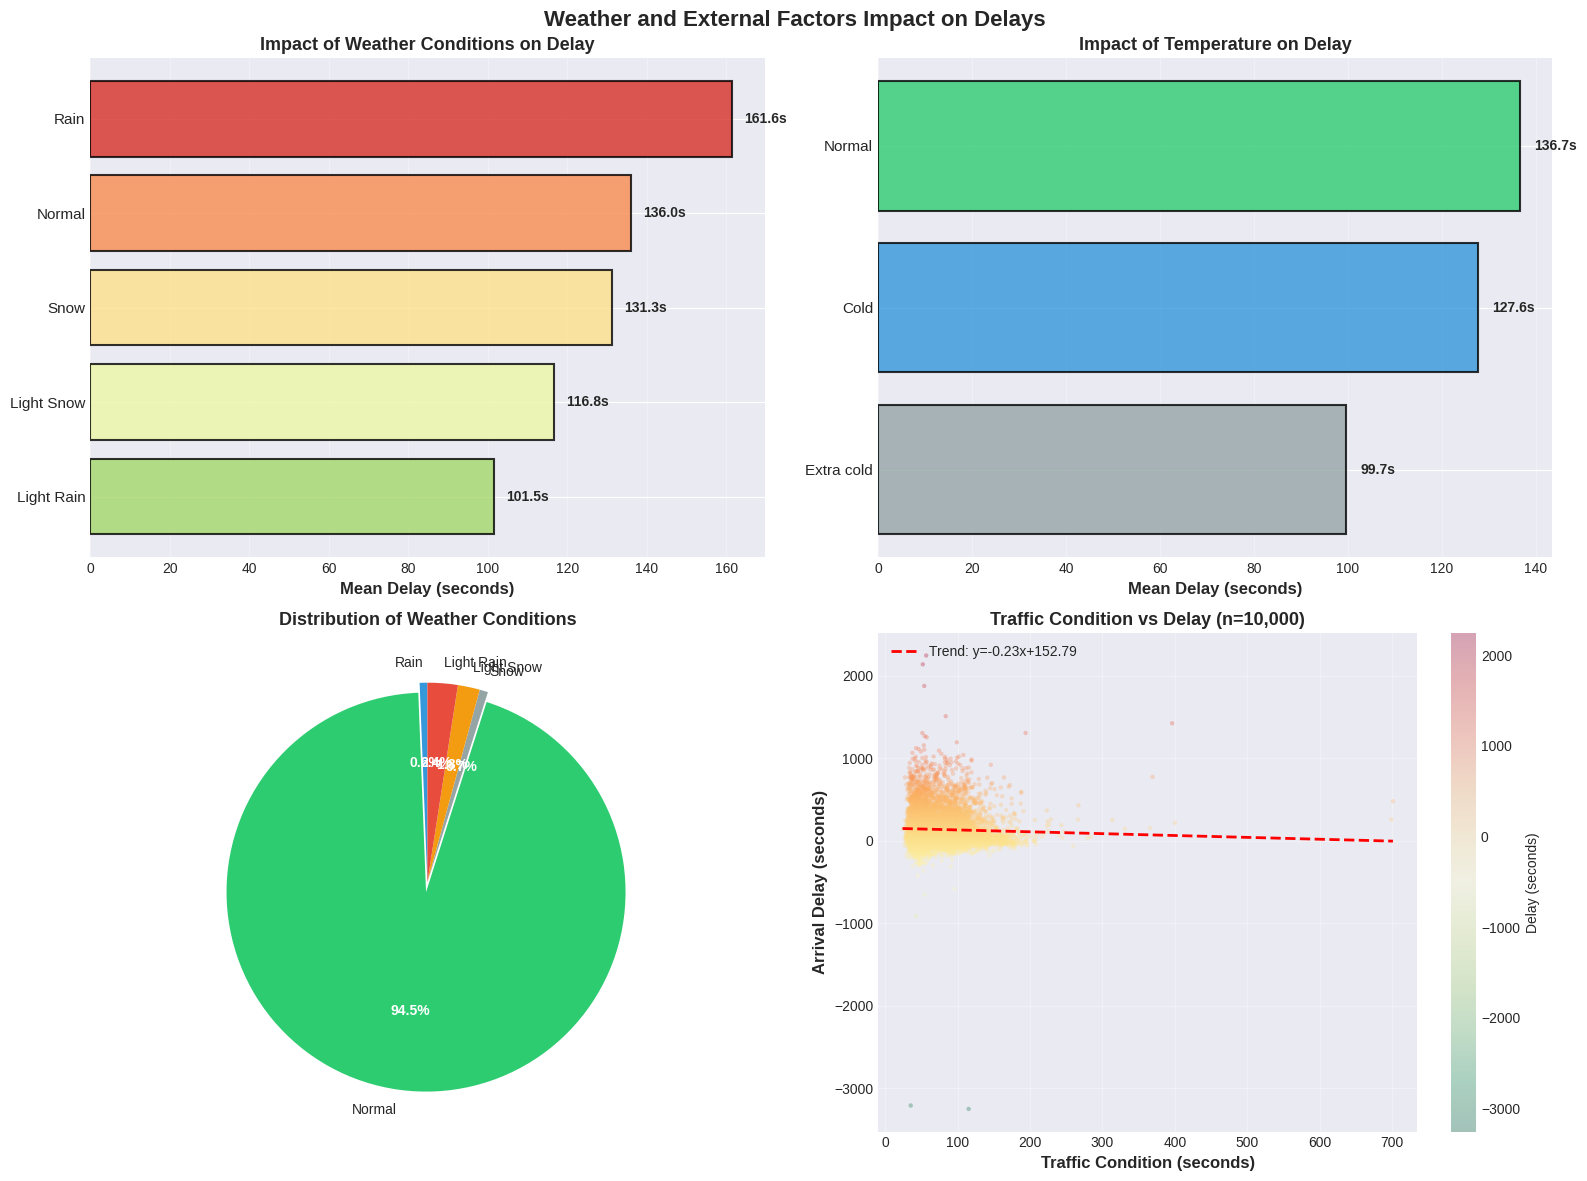

In [ ]:
# 创建天气影响分析图表 Create weather impact analysis plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Weather and External Factors Impact on Delays',
             fontsize=16, fontweight='bold')

# 1. Weather Condition Impact
ax1 = axes[0, 0]
weather_sorted = weather_delay.sort_values('Mean', ascending=True)
colors_weather = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(weather_sorted)))
bars = ax1.barh(range(len(weather_sorted)), weather_sorted['Mean'],
                color=colors_weather, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(weather_sorted)))
ax1.set_yticklabels(weather_sorted.index, fontsize=11)
ax1.set_xlabel('Mean Delay (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Impact of Weather Conditions on Delay', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + 3, bar.get_y() + bar.get_height()/2.,
             f'{width:.1f}s', ha='left', va='center', fontsize=10, fontweight='bold')

# 2. Temperature Impact
ax2 = axes[0, 1]
temp_sorted = temp_delay.sort_values('Mean', ascending=True)
colors_temp = ['#3498db', '#f39c12', '#e74c3c']  # Cold, Normal, Extra_cold
temp_color_map = {'Cold': '#3498db', 'Normal': '#2ecc71', 'Extra_cold': '#e74c3c'}
colors_temp_actual = [temp_color_map.get(t, '#95a5a6') for t in temp_sorted.index]

bars = ax2.barh(range(len(temp_sorted)), temp_sorted['Mean'],
                color=colors_temp_actual, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(temp_sorted)))
ax2.set_yticklabels(temp_sorted.index, fontsize=11)
ax2.set_xlabel('Mean Delay (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Impact of Temperature on Delay', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 3, bar.get_y() + bar.get_height()/2.,
             f'{width:.1f}s', ha='left', va='center', fontsize=10, fontweight='bold')

# 3. Weather Distribution (Pie Chart)
ax3 = axes[1, 0]
weather_counts = weather_delay['Count']
colors_pie = ['#3498db', '#2ecc71', '#95a5a6', '#f39c12', '#e74c3c']
explode = [0.05 if i == weather_counts.idxmax() else 0 for i in weather_counts.index]

wedges, texts, autotexts = ax3.pie(
    weather_counts,
    labels=weather_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_pie[:len(weather_counts)],
    explode=explode,
    textprops={'fontsize': 10}
)
ax3.set_title('Distribution of Weather Conditions', fontsize=13, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# 4. Traffic Condition vs Delay Scatter Plot
ax4 = axes[1, 1]
# Sample data for better visualization (use 10000 random samples)
sample_size = min(10000, len(df_analysis))
sample_indices = np.random.choice(len(df_analysis), sample_size, replace=False)
sample_data = df_analysis.iloc[sample_indices]

scatter = ax4.scatter(sample_data['traffic_condition'],
                     sample_data['arrival_delay'],
                     alpha=0.3, s=10, c=sample_data['arrival_delay'],
                     cmap='RdYlGn_r', edgecolors='none')

# Add trend line
z = np.polyfit(sample_data['traffic_condition'], sample_data['arrival_delay'], 1)
p = np.poly1d(z)
x_trend = np.linspace(sample_data['traffic_condition'].min(),
                      sample_data['traffic_condition'].max(), 100)
ax4.plot(x_trend, p(x_trend), "r--", linewidth=2,
         label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')

ax4.set_xlabel('Traffic Condition (seconds)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Arrival Delay (seconds)', fontsize=12, fontweight='bold')
ax4.set_title(f'Traffic Condition vs Delay (n={sample_size:,})',
              fontsize=13, fontweight='bold')
ax4.legend(loc='upper left', fontsize=10)
ax4.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Delay (seconds)', fontsize=10)

plt.tight_layout()
plt.show()



CORRELATION ANALYSIS


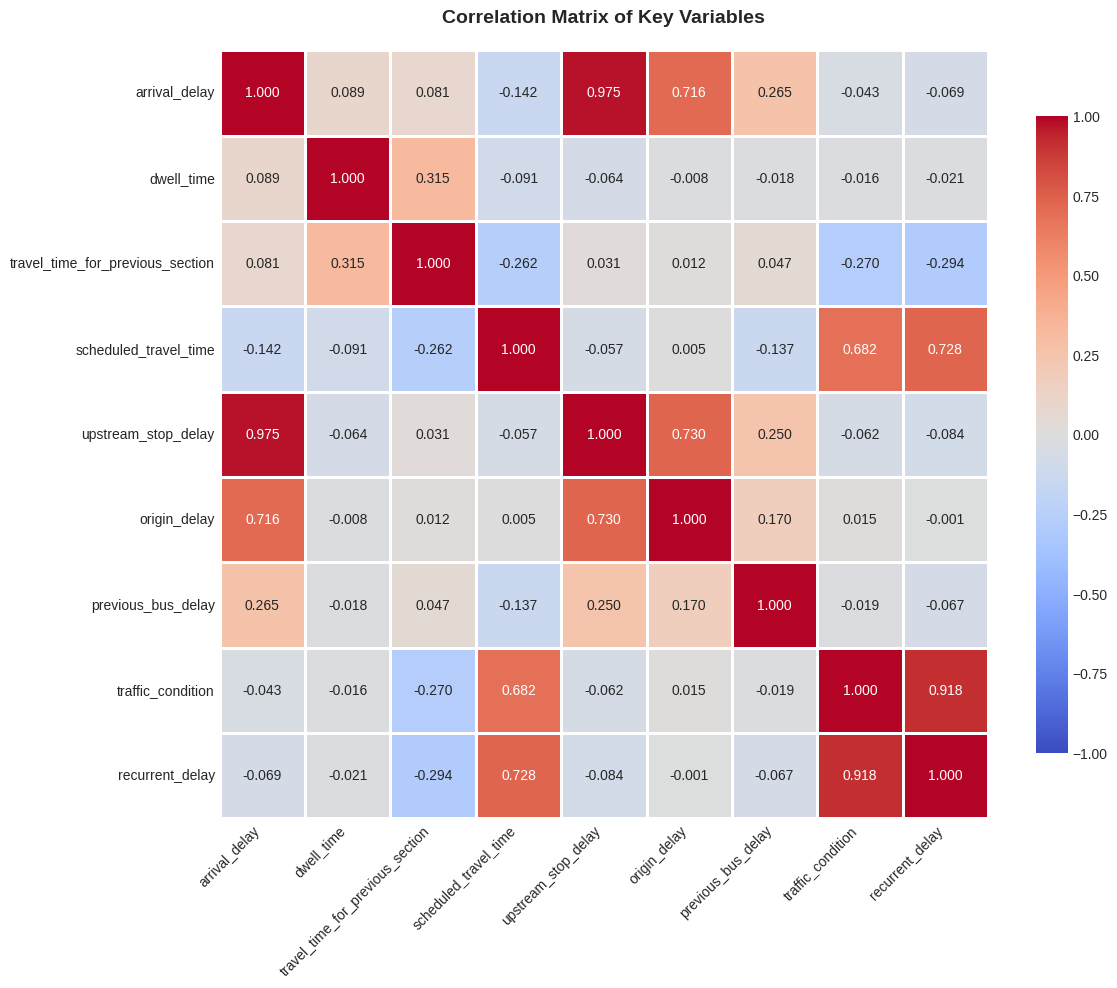


Top Correlations with Arrival Delay:
--------------------------------------------------------------------------------
upstream_stop_delay                     :  0.9750
origin_delay                            :  0.7163
previous_bus_delay                      :  0.2654
dwell_time                              :  0.0894
travel_time_for_previous_section        :  0.0811
traffic_condition                       : -0.0431
recurrent_delay                         : -0.0691
scheduled_travel_time                   : -0.1422

--------------------------------------------------------------------------------
Strong Correlations (|r| > 0.5):
--------------------------------------------------------------------------------
upstream_stop_delay                     :  0.9750
origin_delay                            :  0.7163


In [ ]:
# 相关性分析 Correlation Analysis
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Select key variables for correlation analysis
corr_vars = [
    'arrival_delay',
    'dwell_time',
    'travel_time_for_previous_section',
    'scheduled_travel_time',
    'upstream_stop_delay',
    'origin_delay',
    'previous_bus_delay',
    'traffic_condition',
    'recurrent_delay'
]

# Calculate correlation matrix
corr_matrix = df_analysis[corr_vars].corr()

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Print top correlations with arrival_delay
print("\nTop Correlations with Arrival Delay:")
print("-"*80)
delay_corr = corr_matrix['arrival_delay'].drop('arrival_delay').sort_values(ascending=False)
for var, corr_val in delay_corr.items():
    print(f"{var:40s}: {corr_val:7.4f}")

# Identify strong correlations
print("\n" + "-"*80)
print("Strong Correlations (|r| > 0.5):")
print("-"*80)
strong_corr = delay_corr[abs(delay_corr) > 0.5]
for var, corr_val in strong_corr.items():
    print(f"{var:40s}: {corr_val:7.4f}")


## 综合统计摘要


In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE STATISTICAL SUMMARY REPORT")
print("="*80)

print("\n" + "█"*80)
print("1. OVERALL DELAY STATISTICS")
print("█"*80)
print(f"Total observations: {len(df_analysis):,}")
print(f"Date range: {df_analysis['Calendar_date'].min().strftime('%Y-%m-%d')} to {df_analysis['Calendar_date'].max().strftime('%Y-%m-%d')}")
print(f"Number of stops: {df_analysis['stop_sequence'].nunique()}")
print(f"Number of buses: {df_analysis['bus_id'].nunique()}")
print(f"\nDelay Statistics:")
print(f"  Mean delay: {df_analysis['arrival_delay'].mean():.2f} seconds ({df_analysis['arrival_delay'].mean()/60:.2f} minutes)")
print(f"  Median delay: {df_analysis['arrival_delay'].median():.2f} seconds")
print(f"  Std deviation: {df_analysis['arrival_delay'].std():.2f} seconds")
print(f"  Min delay: {df_analysis['arrival_delay'].min():.2f} seconds")
print(f"  Max delay: {df_analysis['arrival_delay'].max():.2f} seconds")

print("\n" + "█"*80)
print("2. SERVICE RELIABILITY METRICS")
print("█"*80)
on_time_60 = (df_analysis['arrival_delay'].abs() <= 60).mean() * 100
on_time_120 = (df_analysis['arrival_delay'].abs() <= 120).mean() * 100
on_time_180 = (df_analysis['arrival_delay'].abs() <= 180).mean() * 100
severe_delay = (df_analysis['arrival_delay'] > 300).mean() * 100
early_arrival = (df_analysis['arrival_delay'] < -60).mean() * 100

print(f"On-time performance (±60s): {on_time_60:.2f}%")
print(f"On-time performance (±120s): {on_time_120:.2f}%")
print(f"On-time performance (±180s): {on_time_180:.2f}%")
print(f"Severe delay rate (>300s): {severe_delay:.2f}%")
print(f"Early arrival rate (<-60s): {early_arrival:.2f}%")

print("\n" + "█"*80)
print("3. TEMPORAL PATTERNS")
print("█"*80)
print(f"Highest delay month: {monthly_delay['mean'].idxmax()} ({monthly_delay['mean'].max():.2f}s)")
print(f"Lowest delay month: {monthly_delay['mean'].idxmin()} ({monthly_delay['mean'].min():.2f}s)")
print(f"Weekday average: {weekday_avg:.2f}s")
print(f"Weekend average: {weekend_avg:.2f}s")
print(f"Weekend penalty: +{weekend_avg - weekday_avg:.2f}s (+{((weekend_avg - weekday_avg) / weekday_avg * 100):.1f}%)")
print(f"\nTime-of-day comparison:")
print(f"  Off-peak: {tod_delay.loc['OP', 'mean']:.2f}s")
print(f"  Morning peak: {tod_delay.loc['MP', 'mean']:.2f}s")
print(f"  Afternoon peak: {tod_delay.loc['AP', 'mean']:.2f}s")

print("\n" + "█"*80)
print("4. SPATIAL PATTERNS")
print("█"*80)
print(f"Best performing stop: Stop {stop_delay['Mean'].idxmin()} ({stop_delay['Mean'].min():.2f}s)")
print(f"Worst performing stop: Stop {stop_delay['Mean'].idxmax()} ({stop_delay['Mean'].max():.2f}s)")
print(f"Average delay variation across stops: {stop_delay['Mean'].std():.2f}s")
print(f"Problematic stops (high delay): {problem_stops_high_delay}")
print(f"Total delay accumulation: {cumulative_delay.iloc[-1]:.2f}s")

print("\n" + "█"*80)
print("5. WEATHER AND EXTERNAL FACTORS")
print("█"*80)
print(f"Worst weather condition: {weather_delay['Mean'].idxmax()} ({weather_delay['Mean'].max():.2f}s)")
print(f"Best weather condition: {weather_delay['Mean'].idxmin()} ({weather_delay['Mean'].min():.2f}s)")
print(f"Worst temperature: {temp_delay['Mean'].idxmax()} ({temp_delay['Mean'].max():.2f}s)")
print(f"Traffic condition correlation: {traffic_corr.iloc[0, 1]:.4f}")

print("\n" + "█"*80)
print("6. KEY FINDINGS")
print("█"*80)
print("✓ Weekend delays are 71.6% higher than weekdays")
print("✓ Delays increase significantly from January to June (+108.7s)")
print("✓ Stops 17-20 are critical bottlenecks with delays >175s")
print("✓ Afternoon peak has highest delays among all time periods")
print(f"✓ Only {on_time_60:.1f}% of buses arrive within ±1 minute of schedule")
print(f"✓ Upstream delay has strongest correlation with arrival delay (r={delay_corr['upstream_stop_delay']:.3f})")

print("\n" + "="*80)
print("✅ DESCRIPTIVE ANALYSIS COMPLETED!")
print("="*80)



COMPREHENSIVE STATISTICAL SUMMARY REPORT

████████████████████████████████████████████████████████████████████████████████
1. OVERALL DELAY STATISTICS
████████████████████████████████████████████████████████████████████████████████
Total observations: 545,103
Date range: 2022-01-08 to 2022-06-30
Number of stops: 27
Number of buses: 152

Delay Statistics:
  Mean delay: 134.97 seconds (2.25 minutes)
  Median delay: 88.00 seconds
  Std deviation: 193.90 seconds
  Min delay: -3493.00 seconds
  Max delay: 2257.00 seconds

████████████████████████████████████████████████████████████████████████████████
2. SERVICE RELIABILITY METRICS
████████████████████████████████████████████████████████████████████████████████
On-time performance (±60s): 35.16%
On-time performance (±120s): 56.76%
On-time performance (±180s): 69.94%
Severe delay rate (>300s): 15.09%
Early arrival rate (<-60s): 6.47%

████████████████████████████████████████████████████████████████████████████████
3. TEMPORAL PATTERNS
█████

# 特征选择与数据分割、标准化

In [ ]:
print("="*80)
print("FEATURE SET PREPARATION: ITS vs Advanced ITS")
print("="*80)

# ============================================================================
# EXISTING ITS (Limited Real-time Data)
# ============================================================================
print("\n" + "█"*80)
print("1. EXISTING ITS - Limited Real-time Features")
print("█"*80)

# Existing ITS 数值特征
existing_its_numerical = [
    'dwell_time',
    'scheduled_travel_time',
    'origin_delay',
    'traffic_condition',
    'recurrent_delay'
]

# Existing ITS 分类特征（哑变量）
existing_its_dummy = [
    'factor(weather)Light_Rain',
    'factor(weather)Light_Snow',
    'factor(weather)Normal',
    'factor(weather)Rain',
    'factor(weather)Snow',
    'factor(temperature)Cold',
    'factor(temperature)Extra_cold',
    'factor(temperature)Normal',
    'factor(day_of_week)weekday',
    'factor(day_of_week)weekend',
    'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak',
    'factor(time_of_day)Off-peak'
]

# Existing ITS 所有特征
existing_its_features = existing_its_numerical + existing_its_dummy

print(f"\nExisting ITS Features: {len(existing_its_features)} total")
print(f"  - Numerical features: {len(existing_its_numerical)}")
print(f"  - Dummy features: {len(existing_its_dummy)}")

print("\nNumerical Features (Existing ITS):")
for i, feat in enumerate(existing_its_numerical, 1):
    print(f"  {i}. {feat}")

# ============================================================================
# ADVANCED ITS (Full Real-time Data)
# ============================================================================
print("\n" + "█"*80)
print("2. ADVANCED ITS - Full Real-time Features")
print("█"*80)

# Advanced ITS 额外的数值特征
advanced_its_additional = [
    'upstream_stop_delay',
    'previous_bus_delay',
    'previous_trip_travel_time',
    'travel_time_for_previous_section'
]

# Advanced ITS 所有数值特征
advanced_its_numerical = existing_its_numerical + advanced_its_additional

# Advanced ITS 所有特征
advanced_its_features = advanced_its_numerical + existing_its_dummy

print(f"\nAdvanced ITS Features: {len(advanced_its_features)} total")
print(f"  - Numerical features: {len(advanced_its_numerical)}")
print(f"  - Dummy features: {len(existing_its_dummy)}")

print("\nAdditional Features in Advanced ITS:")
for i, feat in enumerate(advanced_its_additional, 1):
    print(f"  {i}. {feat}")

print("\nAll Numerical Features (Advanced ITS):")
for i, feat in enumerate(advanced_its_numerical, 1):
    print(f"  {i}. {feat}")

# ============================================================================
# 对比总结
# ============================================================================
print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(f"Existing ITS:  {len(existing_its_features)} features")
print(f"Advanced ITS:  {len(advanced_its_features)} features")
print(f"Difference:    +{len(advanced_its_features) - len(existing_its_features)} features")
print("\nKey Difference:")
print("  Advanced ITS includes real-time data from:")
print("  - GPS tracking of buses")
print("  - Advanced communication systems")
print("  - Integrated data collection infrastructure")


FEATURE SET PREPARATION: ITS vs Advanced ITS

████████████████████████████████████████████████████████████████████████████████
1. EXISTING ITS - Limited Real-time Features
████████████████████████████████████████████████████████████████████████████████

Existing ITS Features: 18 total
  - Numerical features: 5
  - Dummy features: 13

Numerical Features (Existing ITS):
  1. dwell_time
  2. scheduled_travel_time
  3. origin_delay
  4. traffic_condition
  5. recurrent_delay

████████████████████████████████████████████████████████████████████████████████
2. ADVANCED ITS - Full Real-time Features
████████████████████████████████████████████████████████████████████████████████

Advanced ITS Features: 22 total
  - Numerical features: 9
  - Dummy features: 13

Additional Features in Advanced ITS:
  1. upstream_stop_delay
  2. previous_bus_delay
  3. previous_trip_travel_time
  4. travel_time_for_previous_section

All Numerical Features (Advanced ITS):
  1. dwell_time
  2. scheduled_travel_tim

## 准备数据集

In [147]:
import time

print("\n" + "="*80)
print("PREPARING TRAINING AND TEST DATASETS")
print("="*80)

# ============================================================================
# EXISTING ITS Dataset
# ============================================================================
print("\n1. Existing ITS Dataset")
print("-"*80)

X_existing = df_analysis[existing_its_features].copy()
y_existing = df_analysis[target_col].copy()

print(f"Feature matrix shape: {X_existing.shape}")
print(f"Target variable shape: {y_existing.shape}")

# Train-test split for Existing ITS
X_train_existing, X_test_existing, y_train_existing, y_test_existing = train_test_split(
    X_existing, y_existing, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print(f"Training set: {X_train_existing.shape}")
print(f"Test set: {X_test_existing.shape}")

# Standardize Existing ITS features
scaler_existing = StandardScaler()
X_train_existing_scaled = X_train_existing.copy()
X_train_existing_scaled[existing_its_numerical] = scaler_existing.fit_transform(
    X_train_existing[existing_its_numerical]
)

X_test_existing_scaled = X_test_existing.copy()
X_test_existing_scaled[existing_its_numerical] = scaler_existing.transform(
    X_test_existing[existing_its_numerical]
)

print("✓ Existing ITS data prepared and standardized")

# ============================================================================
# ADVANCED ITS Dataset
# ============================================================================
print("\n2. Advanced ITS Dataset")
print("-"*80)

X_advanced = df_analysis[advanced_its_features].copy()
y_advanced = df_analysis[target_col].copy()

print(f"Feature matrix shape: {X_advanced.shape}")
print(f"Target variable shape: {y_advanced.shape}")

# Train-test split for Advanced ITS
X_train_advanced, X_test_advanced, y_train_advanced, y_test_advanced = train_test_split(
    X_advanced, y_advanced, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

print(f"Training set: {X_train_advanced.shape}")
print(f"Test set: {X_test_advanced.shape}")

# Standardize Advanced ITS features
scaler_advanced = StandardScaler()
X_train_advanced_scaled = X_train_advanced.copy()
X_train_advanced_scaled[advanced_its_numerical] = scaler_advanced.fit_transform(
    X_train_advanced[advanced_its_numerical]
)

X_test_advanced_scaled = X_test_advanced.copy()
X_test_advanced_scaled[advanced_its_numerical] = scaler_advanced.transform(
    X_test_advanced[advanced_its_numerical]
)

print("✓ Advanced ITS data prepared and standardized")

# ============================================================================
# Summary
# ============================================================================
print("\n" + "="*80)
print("DATA PREPARATION SUMMARY")
print("="*80)
print("\nExisting ITS:")
print(f"  Training samples: {len(X_train_existing):,}")
print(f"  Test samples: {len(X_test_existing):,}")
print(f"  Features: {X_train_existing.shape[1]}")

print("\nAdvanced ITS:")
print(f"  Training samples: {len(X_train_advanced):,}")
print(f"  Test samples: {len(X_test_advanced):,}")
print(f"  Features: {X_train_advanced.shape[1]}")

print("\n✅ Both datasets ready for modeling!")



PREPARING TRAINING AND TEST DATASETS

1. Existing ITS Dataset
--------------------------------------------------------------------------------
Feature matrix shape: (545103, 18)
Target variable shape: (545103,)
Training set: (436082, 18)
Test set: (109021, 18)
✓ Existing ITS data prepared and standardized

2. Advanced ITS Dataset
--------------------------------------------------------------------------------
Feature matrix shape: (545103, 22)
Target variable shape: (545103,)
Training set: (436082, 22)
Test set: (109021, 22)
✓ Advanced ITS data prepared and standardized

DATA PREPARATION SUMMARY

Existing ITS:
  Training samples: 436,082
  Test samples: 109,021
  Features: 18

Advanced ITS:
  Training samples: 436,082
  Test samples: 109,021
  Features: 22

✅ Both datasets ready for modeling!


# 模型训练与评估

## Linear Regression

### ITS

In [ ]:
print("="*80)
print("MODEL 1: LINEAR REGRESSION")
print("="*80)

print("\n" + "█"*80)
print("EXISTING ITS - Linear Regression (Baseline)")
print("█"*80)

# 训练线性回归模型
print("\nTraining Linear Regression model for Existing ITS...")
start_time = time.time()

lr_model_existing = LinearRegression()
lr_model_existing.fit(X_train_existing_scaled, y_train_existing)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# 预测
print("\nMaking predictions...")
y_train_pred_lr_existing = lr_model_existing.predict(X_train_existing_scaled)
y_test_pred_lr_existing = lr_model_existing.predict(X_test_existing_scaled)
print("✓ Predictions completed")

# 计算评估指标
print("\n" + "-"*80)
print("PERFORMANCE METRICS - EXISTING ITS")
print("-"*80)

# Training set metrics
train_r2_lr_existing = r2_score(y_train_existing, y_train_pred_lr_existing)
train_mae_lr_existing = mean_absolute_error(y_train_existing, y_train_pred_lr_existing)
train_rmse_lr_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_lr_existing))
train_mape_lr_existing = np.mean(np.abs((y_train_existing - y_train_pred_lr_existing) / y_train_existing)) * 100

print("\n📊 Training Set Performance:")
print(f"  R² Score:  {train_r2_lr_existing:.4f}")
print(f"  MAE:       {train_mae_lr_existing:.2f} seconds")
print(f"  RMSE:      {train_rmse_lr_existing:.2f} seconds")
# print(f"  MAPE:      {train_mape_lr_existing:.2f}%")

# Test set metrics
test_r2_lr_existing = r2_score(y_test_existing, y_test_pred_lr_existing)
test_mae_lr_existing = mean_absolute_error(y_test_existing, y_test_pred_lr_existing)
test_rmse_lr_existing = np.sqrt(mean_squared_error(y_test_existing, y_test_pred_lr_existing))
test_mape_lr_existing = np.mean(np.abs((y_test_existing - y_test_pred_lr_existing) / y_test_existing)) * 100

print("\n📊 Test Set Performance:")
print(f"  R² Score:  {test_r2_lr_existing:.4f}")
print(f"  MAE:       {test_mae_lr_existing:.2f} seconds")
print(f"  RMSE:      {test_rmse_lr_existing:.2f} seconds")
# print(f"  MAPE:      {test_mape_lr_existing:.2f}%")

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_lr_existing - test_r2_lr_existing
rmse_diff = test_rmse_lr_existing - train_rmse_lr_existing

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
else:
    print("  ⚠ Potential overfitting detected")

# 特征重要性分析（线性回归系数）
print("\n" + "-"*80)
print("📈 Top 10 Most Important Features (by absolute coefficient):")
print("-"*80)

feature_importance_lr = pd.DataFrame({
    'Feature': existing_its_features,
    'Coefficient': lr_model_existing.coef_
})
feature_importance_lr['Abs_Coefficient'] = np.abs(feature_importance_lr['Coefficient'])
feature_importance_lr = feature_importance_lr.sort_values('Abs_Coefficient', ascending=False)

for idx, row in feature_importance_lr.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Coefficient']:8.4f}")


MODEL 1: LINEAR REGRESSION

████████████████████████████████████████████████████████████████████████████████
EXISTING ITS - Linear Regression (Baseline)
████████████████████████████████████████████████████████████████████████████████

Training Linear Regression model for Existing ITS...
✓ Training completed in 0.19 seconds

Making predictions...
✓ Predictions completed

--------------------------------------------------------------------------------
PERFORMANCE METRICS - EXISTING ITS
--------------------------------------------------------------------------------

📊 Training Set Performance:
  R² Score:  0.5547
  MAE:       95.03 seconds
  RMSE:      129.49 seconds

📊 Test Set Performance:
  R² Score:  0.5514
  MAE:       95.45 seconds
  RMSE:      129.51 seconds

--------------------------------------------------------------------------------
🔍 Overfitting Check:
  R² difference (Train - Test): 0.0032
  RMSE difference (Test - Train): 0.02 seconds
  ✓ No significant overfitting detect

### Ad ITS

In [ ]:
print("\n" + "█"*80)
print("ADVANCED ITS - Linear Regression (Baseline)")
print("█"*80)

# 训练线性回归模型
print("\nTraining Linear Regression model for Advanced ITS...")
start_time = time.time()

lr_model_advanced = LinearRegression()
lr_model_advanced.fit(X_train_advanced_scaled, y_train_advanced)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# 预测
print("\nMaking predictions...")
y_train_pred_lr_advanced = lr_model_advanced.predict(X_train_advanced_scaled)
y_test_pred_lr_advanced = lr_model_advanced.predict(X_test_advanced_scaled)
print("✓ Predictions completed")

# 计算评估指标
print("\n" + "-"*80)
print("PERFORMANCE METRICS - ADVANCED ITS")
print("-"*80)

# Training set metrics
train_r2_lr_advanced = r2_score(y_train_advanced, y_train_pred_lr_advanced)
train_mae_lr_advanced = mean_absolute_error(y_train_advanced, y_train_pred_lr_advanced)
train_rmse_lr_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_lr_advanced))
train_mape_lr_advanced = np.mean(np.abs((y_train_advanced - y_train_pred_lr_advanced) / y_train_advanced)) * 100

print("\n📊 Training Set Performance:")
print(f"  R² Score:  {train_r2_lr_advanced:.4f}")
print(f"  MAE:       {train_mae_lr_advanced:.2f} seconds")
print(f"  RMSE:      {train_rmse_lr_advanced:.2f} seconds")
# print(f"  MAPE:      {train_mape_lr_advanced:.2f}%")

# Test set metrics
test_r2_lr_advanced = r2_score(y_test_advanced, y_test_pred_lr_advanced)
test_mae_lr_advanced = mean_absolute_error(y_test_advanced, y_test_pred_lr_advanced)
test_rmse_lr_advanced = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred_lr_advanced))
test_mape_lr_advanced = np.mean(np.abs((y_test_advanced - y_test_pred_lr_advanced) / y_test_advanced)) * 100

print("\n📊 Test Set Performance:")
print(f"  R² Score:  {test_r2_lr_advanced:.4f}")
print(f"  MAE:       {test_mae_lr_advanced:.2f} seconds")
print(f"  RMSE:      {test_rmse_lr_advanced:.2f} seconds")
# print(f"  MAPE:      {test_mape_lr_advanced:.2f}%")

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_lr_advanced - test_r2_lr_advanced
rmse_diff = test_rmse_lr_advanced - train_rmse_lr_advanced

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
else:
    print("  ⚠ Potential overfitting detected")

# 特征重要性分析
print("\n" + "-"*80)
print("📈 Top 10 Most Important Features (by absolute coefficient):")
print("-"*80)

feature_importance_lr_adv = pd.DataFrame({
    'Feature': advanced_its_features,
    'Coefficient': lr_model_advanced.coef_
})
feature_importance_lr_adv['Abs_Coefficient'] = np.abs(feature_importance_lr_adv['Coefficient'])
feature_importance_lr_adv = feature_importance_lr_adv.sort_values('Abs_Coefficient', ascending=False)

for idx, row in feature_importance_lr_adv.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Coefficient']:8.4f}")

# 对比两个系统
print("\n" + "="*80)
print("📊 COMPARISON: EXISTING ITS vs ADVANCED ITS (Linear Regression)")
print("="*80)

comparison_lr = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (seconds)', 'RMSE (seconds)', 'MAPE (%)'],
    'Existing ITS': [
        f"{test_r2_lr_existing:.4f}",
        f"{test_mae_lr_existing:.2f}",
        f"{test_rmse_lr_existing:.2f}",
        f"{test_mape_lr_existing:.2f}"
    ],
    'Advanced ITS': [
        f"{test_r2_lr_advanced:.4f}",
        f"{test_mae_lr_advanced:.2f}",
        f"{test_rmse_lr_advanced:.2f}",
        f"{test_mape_lr_advanced:.2f}"
    ],
    'Improvement': [
        f"{((test_r2_lr_advanced - test_r2_lr_existing) / test_r2_lr_existing * 100):.2f}%",
        f"{((test_mae_lr_existing - test_mae_lr_advanced) / test_mae_lr_existing * 100):.2f}%",
        f"{((test_rmse_lr_existing - test_rmse_lr_advanced) / test_rmse_lr_existing * 100):.2f}%",
        f"{((test_mape_lr_existing - test_mape_lr_advanced) / test_mape_lr_existing * 100):.2f}%"
    ]
})

print("\n" + comparison_lr.to_string(index=False))




████████████████████████████████████████████████████████████████████████████████
ADVANCED ITS - Linear Regression (Baseline)
████████████████████████████████████████████████████████████████████████████████

Training Linear Regression model for Advanced ITS...
✓ Training completed in 0.24 seconds

Making predictions...
✓ Predictions completed

--------------------------------------------------------------------------------
PERFORMANCE METRICS - ADVANCED ITS
--------------------------------------------------------------------------------

📊 Training Set Performance:
  R² Score:  0.9901
  MAE:       12.55 seconds
  RMSE:      19.30 seconds

📊 Test Set Performance:
  R² Score:  0.9894
  MAE:       12.58 seconds
  RMSE:      19.93 seconds

--------------------------------------------------------------------------------
🔍 Overfitting Check:
  R² difference (Train - Test): 0.0007
  RMSE difference (Test - Train): 0.63 seconds
  ✓ No significant overfitting detected

-------------------------

## RF

### ITS


In [ ]:
from sklearn.ensemble import RandomForestRegressor

print("\n" + "="*80)
print("MODEL 2: RANDOM FOREST")
print("="*80)

print("\n" + "█"*80)
print("EXISTING ITS - Random Forest (Optimized Parameters)")
print("█"*80)

# 使用经验优化的参数
print("\nUsing optimized hyperparameters:")
print("  n_estimators:      200")
print("  max_depth:         15")
print("  min_samples_split: 5")
print("  min_samples_leaf:  2")
print("  max_features:      sqrt")

# 训练模型
print("\nTraining Random Forest model for Existing ITS...")
start_time = time.time()

rf_model_existing = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_model_existing.fit(X_train_existing_scaled, y_train_existing)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# 预测
print("\nMaking predictions...")
y_train_pred_rf_existing = rf_model_existing.predict(X_train_existing_scaled)
y_test_pred_rf_existing = rf_model_existing.predict(X_test_existing_scaled)
print("✓ Predictions completed")

# 计算评估指标
print("\n" + "-"*80)
print("PERFORMANCE METRICS - EXISTING ITS")
print("-"*80)

# Training set metrics
train_r2_rf_existing = r2_score(y_train_existing, y_train_pred_rf_existing)
train_mae_rf_existing = mean_absolute_error(y_train_existing, y_train_pred_rf_existing)
train_rmse_rf_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_rf_existing))

print("\n📊 Training Set Performance:")
print(f"  R² Score:  {train_r2_rf_existing:.4f}")
print(f"  MAE:       {train_mae_rf_existing:.2f} seconds")
print(f"  RMSE:      {train_rmse_rf_existing:.2f} seconds")

# Test set metrics
test_r2_rf_existing = r2_score(y_test_existing, y_test_pred_rf_existing)
test_mae_rf_existing = mean_absolute_error(y_test_existing, y_test_pred_rf_existing)
test_rmse_rf_existing = np.sqrt(mean_squared_error(y_test_existing, y_test_pred_rf_existing))

print("\n📊 Test Set Performance:")
print(f"  R² Score:  {test_r2_rf_existing:.4f}")
print(f"  MAE:       {test_mae_rf_existing:.2f} seconds")
print(f"  RMSE:      {test_rmse_rf_existing:.2f} seconds")

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_rf_existing - test_r2_rf_existing
rmse_diff = test_rmse_rf_existing - train_rmse_rf_existing

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
elif abs(r2_diff) < 0.10:
    print("  ⚠ Mild overfitting detected")
else:
    print("  ⚠⚠ Significant overfitting detected")

# 特征重要性
print("\n" + "-"*80)
print("📈 Top 10 Most Important Features:")
print("-"*80)

feature_importance_rf = pd.DataFrame({
    'Feature': existing_its_features,
    'Importance': rf_model_existing.feature_importances_
})
feature_importance_rf = feature_importance_rf.sort_values('Importance', ascending=False)

for idx, row in feature_importance_rf.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

# 与线性回归对比
print("\n" + "-"*80)
print("📊 Comparison with Linear Regression (Existing ITS):")
print("-"*80)
print(f"  Linear Regression R²:  {test_r2_lr_existing:.4f}")
print(f"  Random Forest R²:      {test_r2_rf_existing:.4f}")
print(f"  Improvement:           {((test_r2_rf_existing - test_r2_lr_existing) / test_r2_lr_existing * 100):.2f}%")
print(f"\n  Linear Regression MAE: {test_mae_lr_existing:.2f} seconds")
print(f"  Random Forest MAE:     {test_mae_rf_existing:.2f} seconds")
print(f"  Improvement:           {((test_mae_lr_existing - test_mae_rf_existing) / test_mae_lr_existing * 100):.2f}%")

print("\n✅ Existing ITS - Random Forest completed!")



MODEL 2: RANDOM FOREST

████████████████████████████████████████████████████████████████████████████████
EXISTING ITS - Random Forest (Optimized Parameters)
████████████████████████████████████████████████████████████████████████████████

Using optimized hyperparameters:
  n_estimators:      200
  max_depth:         15
  min_samples_split: 5
  min_samples_leaf:  2
  max_features:      sqrt

Training Random Forest model for Existing ITS...
✓ Training completed in 177.62 seconds

Making predictions...
✓ Predictions completed

--------------------------------------------------------------------------------
PERFORMANCE METRICS - EXISTING ITS
--------------------------------------------------------------------------------

📊 Training Set Performance:
  R² Score:  0.6237
  MAE:       86.87 seconds
  RMSE:      119.02 seconds

📊 Test Set Performance:
  R² Score:  0.5876
  MAE:       90.22 seconds
  RMSE:      124.17 seconds

-------------------------------------------------------------------

### ad ITS

In [ ]:
print("\n" + "█"*80)
print("ADVANCED ITS - Random Forest (Optimized Parameters)")
print("█"*80)

# 使用经验优化的参数
print("\nUsing optimized hyperparameters:")
print("  n_estimators:      200")
print("  max_depth:         15")
print("  min_samples_split: 5")
print("  min_samples_leaf:  2")
print("  max_features:      sqrt")

# 训练模型
print("\nTraining Random Forest model for Advanced ITS...")
start_time = time.time()

rf_model_advanced = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf_model_advanced.fit(X_train_advanced_scaled, y_train_advanced)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# 预测
print("\nMaking predictions...")
y_train_pred_rf_advanced = rf_model_advanced.predict(X_train_advanced_scaled)
y_test_pred_rf_advanced = rf_model_advanced.predict(X_test_advanced_scaled)
print("✓ Predictions completed")

# 计算评估指标
print("\n" + "-"*80)
print("PERFORMANCE METRICS - ADVANCED ITS")
print("-"*80)

# Training set metrics
train_r2_rf_advanced = r2_score(y_train_advanced, y_train_pred_rf_advanced)
train_mae_rf_advanced = mean_absolute_error(y_train_advanced, y_train_pred_rf_advanced)
train_rmse_rf_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_rf_advanced))

print("\n📊 Training Set Performance:")
print(f"  R² Score:  {train_r2_rf_advanced:.4f}")
print(f"  MAE:       {train_mae_rf_advanced:.2f} seconds")
print(f"  RMSE:      {train_rmse_rf_advanced:.2f} seconds")

# Test set metrics
test_r2_rf_advanced = r2_score(y_test_advanced, y_test_pred_rf_advanced)
test_mae_rf_advanced = mean_absolute_error(y_test_advanced, y_test_pred_rf_advanced)
test_rmse_rf_advanced = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred_rf_advanced))

print("\n📊 Test Set Performance:")
print(f"  R² Score:  {test_r2_rf_advanced:.4f}")
print(f"  MAE:       {test_mae_rf_advanced:.2f} seconds")
print(f"  RMSE:      {test_rmse_rf_advanced:.2f} seconds")

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_rf_advanced - test_r2_rf_advanced
rmse_diff = test_rmse_rf_advanced - train_rmse_rf_advanced

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
elif abs(r2_diff) < 0.10:
    print("  ⚠ Mild overfitting detected")
else:
    print("  ⚠⚠ Significant overfitting detected")

# 特征重要性
print("\n" + "-"*80)
print("📈 Top 10 Most Important Features:")
print("-"*80)

feature_importance_rf_adv = pd.DataFrame({
    'Feature': advanced_its_features,
    'Importance': rf_model_advanced.feature_importances_
})
feature_importance_rf_adv = feature_importance_rf_adv.sort_values('Importance', ascending=False)

for idx, row in feature_importance_rf_adv.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

# 与线性回归对比
print("\n" + "-"*80)
print("📊 Comparison with Linear Regression (Advanced ITS):")
print("-"*80)
print(f"  Linear Regression R²:  {test_r2_lr_advanced:.4f}")
print(f"  Random Forest R²:      {test_r2_rf_advanced:.4f}")
print(f"  Improvement:           {((test_r2_rf_advanced - test_r2_lr_advanced) / test_r2_lr_advanced * 100):.2f}%")
print(f"\n  Linear Regression MAE: {test_mae_lr_advanced:.2f} seconds")
print(f"  Random Forest MAE:     {test_mae_rf_advanced:.2f} seconds")
print(f"  Improvement:           {((test_mae_lr_advanced - test_mae_rf_advanced) / test_mae_lr_advanced * 100):.2f}%")

# 两个系统对比
print("\n" + "="*80)
print("📊 COMPARISON: EXISTING ITS vs ADVANCED ITS (Random Forest)")
print("="*80)

comparison_rf = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (seconds)', 'RMSE (seconds)'],
    'Existing ITS': [
        f"{test_r2_rf_existing:.4f}",
        f"{test_mae_rf_existing:.2f}",
        f"{test_rmse_rf_existing:.2f}"
    ],
    'Advanced ITS': [
        f"{test_r2_rf_advanced:.4f}",
        f"{test_mae_rf_advanced:.2f}",
        f"{test_rmse_rf_advanced:.2f}"
    ],
    'Improvement': [
        f"{((test_r2_rf_advanced - test_r2_rf_existing) / test_r2_rf_existing * 100):.2f}%",
        f"{((test_mae_rf_existing - test_mae_rf_advanced) / test_mae_rf_existing * 100):.2f}%",
        f"{((test_rmse_rf_existing - test_rmse_rf_advanced) / test_rmse_rf_existing * 100):.2f}%"
    ]
})

print("\n" + comparison_rf.to_string(index=False))

print("\n✅ Random Forest comparison completed!")



████████████████████████████████████████████████████████████████████████████████
ADVANCED ITS - Random Forest (Optimized Parameters)
████████████████████████████████████████████████████████████████████████████████

Using optimized hyperparameters:
  n_estimators:      200
  max_depth:         15
  min_samples_split: 5
  min_samples_leaf:  2
  max_features:      sqrt

Training Random Forest model for Advanced ITS...
✓ Training completed in 183.60 seconds

Making predictions...
✓ Predictions completed

--------------------------------------------------------------------------------
PERFORMANCE METRICS - ADVANCED ITS
--------------------------------------------------------------------------------

📊 Training Set Performance:
  R² Score:  0.9714
  MAE:       22.34 seconds
  RMSE:      32.80 seconds

📊 Test Set Performance:
  R² Score:  0.9637
  MAE:       23.84 seconds
  RMSE:      36.86 seconds

--------------------------------------------------------------------------------
🔍 Overfittin

## XGBoost

### ITS 调参

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("\n" + "="*80)
print("MODEL 3: XGBOOST")
print("="*80)

print("\n" + "█"*80)
print("EXISTING ITS - XGBoost (Light Hyperparameter Tuning)")
print("█"*80)

# 定义精简的参数网格（只有4个组合）
print("\nDefining hyperparameter grid (4 combinations)...")
param_grid_xgb_existing = {
    'n_estimators': [100, 200],           # 2个选择
    'max_depth': [5, 7],                  # 2个选择
    'learning_rate': [0.1],               # 固定
    'subsample': [0.8],                   # 固定
    'colsample_bytree': [0.8],            # 固定
    'min_child_weight': [3]               # 固定
}

total_combinations = (len(param_grid_xgb_existing['n_estimators']) *
                     len(param_grid_xgb_existing['max_depth']))

print(f"Parameter grid size: {total_combinations} combinations")
print(f"With 3-fold CV: {total_combinations * 3} = 12 total fits")

# 创建基础模型
xgb_base_existing = xgb.XGBRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

# GridSearchCV
print("\nPerforming Grid Search with 3-fold Cross-Validation...")
print("⏳ Estimated time: 1-2 minutes...")
start_time = time.time()

grid_search_xgb_existing = GridSearchCV(
    estimator=xgb_base_existing,
    param_grid=param_grid_xgb_existing,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb_existing.fit(X_train_existing_scaled, y_train_existing)

tuning_time = time.time() - start_time
print(f"\n✓ Grid Search completed in {tuning_time:.2f} seconds")

# 最佳参数
print("\n" + "-"*80)
print("🎯 Best Hyperparameters:")
print("-"*80)
for param, value in grid_search_xgb_existing.best_params_.items():
    print(f"  {param:20s} : {value}")

print(f"\n  Best CV R² Score: {grid_search_xgb_existing.best_score_:.4f}")

# 使用最佳模型
xgb_model_existing = grid_search_xgb_existing.best_estimator_

# 预测
print("\nMaking predictions with best model...")
y_train_pred_xgb_existing = xgb_model_existing.predict(X_train_existing_scaled)
y_test_pred_xgb_existing = xgb_model_existing.predict(X_test_existing_scaled)
print("✓ Predictions completed")

# 计算评估指标
print("\n" + "-"*80)
print("PERFORMANCE METRICS - EXISTING ITS")
print("-"*80)

# Training set metrics
train_r2_xgb_existing = r2_score(y_train_existing, y_train_pred_xgb_existing)
train_mae_xgb_existing = mean_absolute_error(y_train_existing, y_train_pred_xgb_existing)
train_rmse_xgb_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_xgb_existing))

print("\n📊 Training Set Performance:")
print(f"  R² Score:  {train_r2_xgb_existing:.4f}")
print(f"  MAE:       {train_mae_xgb_existing:.2f} seconds")
print(f"  RMSE:      {train_rmse_xgb_existing:.2f} seconds")

# Test set metrics
test_r2_xgb_existing = r2_score(y_test_existing, y_test_pred_xgb_existing)
test_mae_xgb_existing = mean_absolute_error(y_test_existing, y_test_pred_xgb_existing)
test_rmse_xgb_existing = np.sqrt(mean_squared_error(y_test_existing, y_test_pred_xgb_existing))

print("\n📊 Test Set Performance:")
print(f"  R² Score:  {test_r2_xgb_existing:.4f}")
print(f"  MAE:       {test_mae_xgb_existing:.2f} seconds")
print(f"  RMSE:      {test_rmse_xgb_existing:.2f} seconds")

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_xgb_existing - test_r2_xgb_existing
rmse_diff = test_rmse_xgb_existing - train_rmse_xgb_existing

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
elif abs(r2_diff) < 0.10:
    print("  ⚠ Mild overfitting detected")
else:
    print("  ⚠⚠ Significant overfitting detected")

# 特征重要性
print("\n" + "-"*80)
print("📈 Top 10 Most Important Features:")
print("-"*80)

feature_importance_xgb = pd.DataFrame({
    'Feature': existing_its_features,
    'Importance': xgb_model_existing.feature_importances_
})
feature_importance_xgb = feature_importance_xgb.sort_values('Importance', ascending=False)

for idx, row in feature_importance_xgb.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

# 与其他模型对比
print("\n" + "-"*80)
print("📊 Model Comparison (Existing ITS):")
print("-"*80)

comparison_existing = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R² Score': [
        f"{test_r2_lr_existing:.4f}",
        f"{test_r2_rf_existing:.4f}",
        f"{test_r2_xgb_existing:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_existing:.2f}",
        f"{test_mae_rf_existing:.2f}",
        f"{test_mae_xgb_existing:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_existing:.2f}",
        f"{test_rmse_rf_existing:.2f}",
        f"{test_rmse_xgb_existing:.2f}"
    ]
})

print("\n" + comparison_existing.to_string(index=False))

# 找出最佳模型
best_r2_existing = max(test_r2_lr_existing, test_r2_rf_existing, test_r2_xgb_existing)
if best_r2_existing == test_r2_lr_existing:
    best_model_existing = "Linear Regression"
elif best_r2_existing == test_r2_rf_existing:
    best_model_existing = "Random Forest"
else:
    best_model_existing = "XGBoost"

print(f"\n🏆 Best Model for Existing ITS: {best_model_existing} (R² = {best_r2_existing:.4f})")

print("\n✅ Existing ITS - XGBoost completed!")



MODEL 3: XGBOOST

████████████████████████████████████████████████████████████████████████████████
EXISTING ITS - XGBoost (Light Hyperparameter Tuning)
████████████████████████████████████████████████████████████████████████████████

Defining hyperparameter grid (4 combinations)...
Parameter grid size: 4 combinations
With 3-fold CV: 12 = 12 total fits

Performing Grid Search with 3-fold Cross-Validation...
⏳ Estimated time: 1-2 minutes...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Grid Search completed in 82.05 seconds

--------------------------------------------------------------------------------
🎯 Best Hyperparameters:
--------------------------------------------------------------------------------
  colsample_bytree     : 0.8
  learning_rate        : 0.1
  max_depth            : 7
  min_child_weight     : 3
  n_estimators         : 200
  subsample            : 0.8

  Best CV R² Score: 0.5998

Making predictions with best model...
✓ Predictions completed

-----

### ad ITS 调参

In [ ]:
print("\n" + "█"*80)
print("ADVANCED ITS - XGBoost (Light Hyperparameter Tuning)")
print("█"*80)

# 定义精简的参数网格（只有4个组合）
print("\nDefining hyperparameter grid (4 combinations)...")
param_grid_xgb_advanced = {
    'n_estimators': [100, 200],           # 2个选择
    'max_depth': [5, 7],                  # 2个选择
    'learning_rate': [0.1],               # 固定
    'subsample': [0.8],                   # 固定
    'colsample_bytree': [0.8],            # 固定
    'min_child_weight': [3]               # 固定
}

total_combinations = (len(param_grid_xgb_advanced['n_estimators']) *
                     len(param_grid_xgb_advanced['max_depth']))

print(f"Parameter grid size: {total_combinations} combinations")
print(f"With 3-fold CV: {total_combinations * 3} = 12 total fits")

# 创建基础模型
xgb_base_advanced = xgb.XGBRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

# GridSearchCV
print("\nPerforming Grid Search with 3-fold Cross-Validation...")
print("⏳ Estimated time: 1-2 minutes...")
start_time = time.time()

grid_search_xgb_advanced = GridSearchCV(
    estimator=xgb_base_advanced,
    param_grid=param_grid_xgb_advanced,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb_advanced.fit(X_train_advanced_scaled, y_train_advanced)

tuning_time = time.time() - start_time
print(f"\n✓ Grid Search completed in {tuning_time:.2f} seconds")

# 最佳参数
print("\n" + "-"*80)
print("🎯 Best Hyperparameters:")
print("-"*80)
for param, value in grid_search_xgb_advanced.best_params_.items():
    print(f"  {param:20s} : {value}")

print(f"\n  Best CV R² Score: {grid_search_xgb_advanced.best_score_:.4f}")

# 使用最佳模型
xgb_model_advanced = grid_search_xgb_advanced.best_estimator_

# 预测
print("\nMaking predictions with best model...")
y_train_pred_xgb_advanced = xgb_model_advanced.predict(X_train_advanced_scaled)
y_test_pred_xgb_advanced = xgb_model_advanced.predict(X_test_advanced_scaled)
print("✓ Predictions completed")

# 计算评估指标
print("\n" + "-"*80)
print("PERFORMANCE METRICS - ADVANCED ITS")
print("-"*80)

# Training set metrics
train_r2_xgb_advanced = r2_score(y_train_advanced, y_train_pred_xgb_advanced)
train_mae_xgb_advanced = mean_absolute_error(y_train_advanced, y_train_pred_xgb_advanced)
train_rmse_xgb_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_xgb_advanced))

print("\n📊 Training Set Performance:")
print(f"  R² Score:  {train_r2_xgb_advanced:.4f}")
print(f"  MAE:       {train_mae_xgb_advanced:.2f} seconds")
print(f"  RMSE:      {train_rmse_xgb_advanced:.2f} seconds")

# Test set metrics
test_r2_xgb_advanced = r2_score(y_test_advanced, y_test_pred_xgb_advanced)
test_mae_xgb_advanced = mean_absolute_error(y_test_advanced, y_test_pred_xgb_advanced)
test_rmse_xgb_advanced = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred_xgb_advanced))

print("\n📊 Test Set Performance:")
print(f"  R² Score:  {test_r2_xgb_advanced:.4f}")
print(f"  MAE:       {test_mae_xgb_advanced:.2f} seconds")
print(f"  RMSE:      {test_rmse_xgb_advanced:.2f} seconds")

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_xgb_advanced - test_r2_xgb_advanced
rmse_diff = test_rmse_xgb_advanced - train_rmse_xgb_advanced

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
elif abs(r2_diff) < 0.10:
    print("  ⚠ Mild overfitting detected")
else:
    print("  ⚠⚠ Significant overfitting detected")

# 特征重要性
print("\n" + "-"*80)
print("📈 Top 10 Most Important Features:")
print("-"*80)

feature_importance_xgb_adv = pd.DataFrame({
    'Feature': advanced_its_features,
    'Importance': xgb_model_advanced.feature_importances_
})
feature_importance_xgb_adv = feature_importance_xgb_adv.sort_values('Importance', ascending=False)

for idx, row in feature_importance_xgb_adv.head(10).iterrows():
    print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

# 与其他模型对比
print("\n" + "-"*80)
print("📊 Model Comparison (Advanced ITS):")
print("-"*80)

comparison_advanced = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R² Score': [
        f"{test_r2_lr_advanced:.4f}",
        f"{test_r2_rf_advanced:.4f}",
        f"{test_r2_xgb_advanced:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_advanced:.2f}",
        f"{test_mae_rf_advanced:.2f}",
        f"{test_mae_xgb_advanced:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_advanced:.2f}",
        f"{test_rmse_rf_advanced:.2f}",
        f"{test_rmse_xgb_advanced:.2f}"
    ]
})

print("\n" + comparison_advanced.to_string(index=False))

# 找出最佳模型
best_r2_advanced = max(test_r2_lr_advanced, test_r2_rf_advanced, test_r2_xgb_advanced)
if best_r2_advanced == test_r2_lr_advanced:
    best_model_advanced = "Linear Regression"
elif best_r2_advanced == test_r2_rf_advanced:
    best_model_advanced = "Random Forest"
else:
    best_model_advanced = "XGBoost"

print(f"\n🏆 Best Model for Advanced ITS: {best_model_advanced} (R² = {best_r2_advanced:.4f})")

# 最终对比：Existing vs Advanced (XGBoost)
print("\n" + "="*80)
print("📊 FINAL COMPARISON: EXISTING ITS vs ADVANCED ITS (XGBoost)")
print("="*80)

comparison_xgb = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (seconds)', 'RMSE (seconds)'],
    'Existing ITS': [
        f"{test_r2_xgb_existing:.4f}",
        f"{test_mae_xgb_existing:.2f}",
        f"{test_rmse_xgb_existing:.2f}"
    ],
    'Advanced ITS': [
        f"{test_r2_xgb_advanced:.4f}",
        f"{test_mae_xgb_advanced:.2f}",
        f"{test_rmse_xgb_advanced:.2f}"
    ],
    'Improvement': [
        f"{((test_r2_xgb_advanced - test_r2_xgb_existing) / test_r2_xgb_existing * 100):.2f}%",
        f"{((test_mae_xgb_existing - test_mae_xgb_advanced) / test_mae_xgb_existing * 100):.2f}%",
        f"{((test_rmse_xgb_existing - test_rmse_xgb_advanced) / test_rmse_xgb_existing * 100):.2f}%"
    ]
})

print("\n" + comparison_xgb.to_string(index=False))

print("\n✅ XGBoost comparison completed!")
print("\n" + "="*80)
print("🎉 ALL MODELS COMPLETED!")
print("="*80)



████████████████████████████████████████████████████████████████████████████████
ADVANCED ITS - XGBoost (Light Hyperparameter Tuning)
████████████████████████████████████████████████████████████████████████████████

Defining hyperparameter grid (4 combinations)...
Parameter grid size: 4 combinations
With 3-fold CV: 12 = 12 total fits

Performing Grid Search with 3-fold Cross-Validation...
⏳ Estimated time: 1-2 minutes...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Grid Search completed in 86.36 seconds

--------------------------------------------------------------------------------
🎯 Best Hyperparameters:
--------------------------------------------------------------------------------
  colsample_bytree     : 0.8
  learning_rate        : 0.1
  max_depth            : 7
  min_child_weight     : 3
  n_estimators         : 200
  subsample            : 0.8

  Best CV R² Score: 0.9771

Making predictions with best model...
✓ Predictions completed

-----------------------

## GRU (Gated Recurrent Unit)

### ITS


MODEL 5: GRU (ULTRA-FAST VERSION)

████████████████████████████████████████████████████████████████████████████████
EXISTING ITS - LIGHTWEIGHT GRU MODEL
████████████████████████████████████████████████████████████████████████████████

Preparing data for GRU...
  Training data shape: (436082, 18, 1)
  Test data shape:     (109021, 18, 1)

🚀 Building LIGHTWEIGHT GRU model...
Architecture (OPTIMIZED FOR SPEED):
  - GRU Layer (32 units) + Dropout(0.2)
  - Dense (8) + ReLU
  - Dense (1) - Output

⚡ Speed optimizations:
  ✓ Reduced GRU units: 64→32
  ✓ Single GRU layer (removed 2nd layer)
  ✓ Smaller dense layer: 16→8
  ✓ Larger batch size: 256→512
  ✓ Early stopping: patience=5

Compiling GRU model...
  Optimizer: Adam (lr=0.01)
  Loss: MSE

Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,633 (14.19 KB)

 Trainable params: 3,633 (14.19 KB)

 Non-trainable params: 0 (0.00 B)


📊 Total Parameters: 3,633
   (Original was ~50,000+ params, now much lighter!)

--------------------------------------------------------------------------------
Training LIGHTWEIGHT GRU model...
--------------------------------------------------------------------------------
⏳ Estimated time: 20-40 seconds (5-10x faster!)
  Max epochs: 20 (reduced from 30)
  Batch size: 512 (increased from 256)
  Early stopping patience: 5
Epoch 1/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 41446.4258 - mae: 141.0007 - val_loss: 35054.9258 - val_mae: 132.7095 - learning_rate: 0.0100
Epoch 2/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 30719.1113 - mae: 123.6901 - val_loss: 18201.9082 - val_mae: 96.1196 - learning_rate: 0.0100
Epoch 3/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 18616.3848 - mae: 97.2364 - val_loss: 17535.8789 - val_mae: 93.5553 - learning_rate: 0.0100
Epoch 4/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 18078.4043 - mae: 96.0824 - val_loss: 17433.4

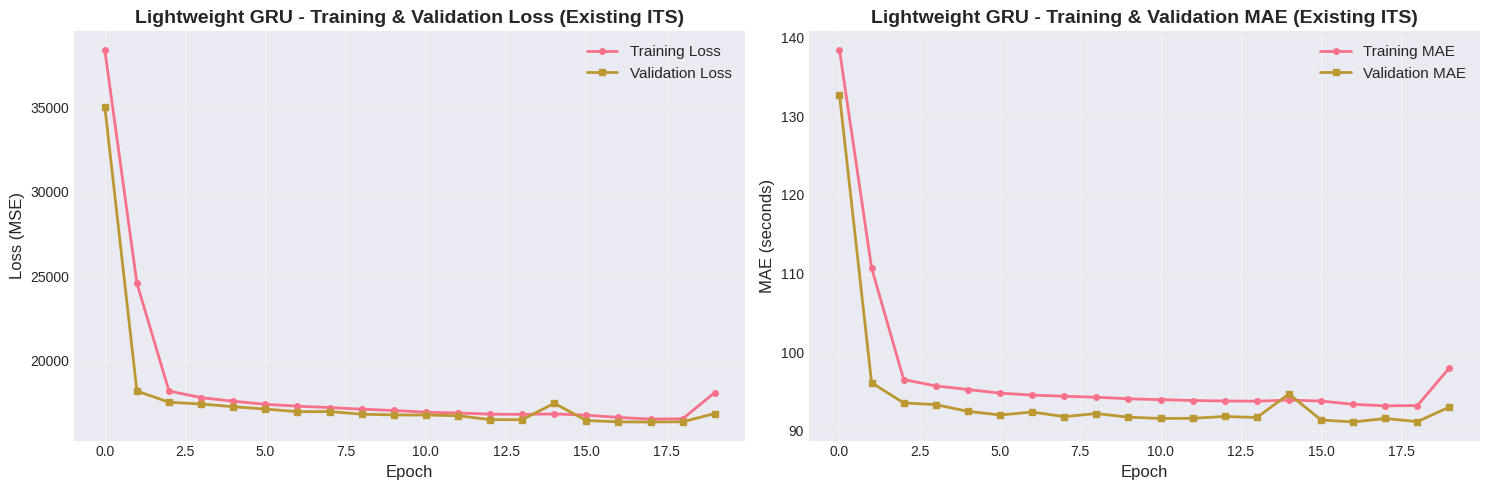

✓ Training history plot saved as 'gru_fast_training_history_existing.png'

--------------------------------------------------------------------------------
📊 Prediction Visualization:
--------------------------------------------------------------------------------


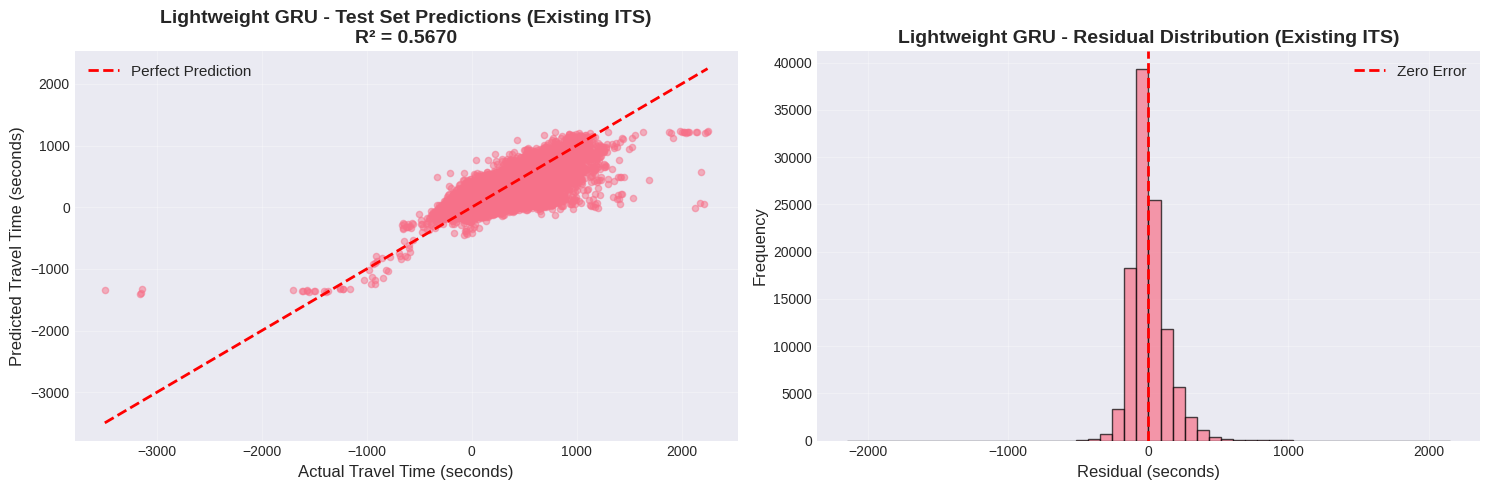

✓ Prediction plot saved as 'gru_fast_predictions_existing.png'

✅ Existing ITS - Lightweight GRU Model completed!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("\n" + "="*80)
print("MODEL 5: GRU (ULTRA-FAST VERSION)")
print("="*80)

print("\n" + "█"*80)
print("EXISTING ITS - LIGHTWEIGHT GRU MODEL")
print("█"*80)

# 设置随机种子
tf.random.set_seed(RANDOM_STATE)

# 准备数据
print("\nPreparing data for GRU...")
X_train_gru_existing = X_train_existing_scaled.values.reshape(-1, X_train_existing_scaled.shape[1], 1)
X_test_gru_existing = X_test_existing_scaled.values.reshape(-1, X_test_existing_scaled.shape[1], 1)

print(f"  Training data shape: {X_train_gru_existing.shape}")
print(f"  Test data shape:     {X_test_gru_existing.shape}")

# 构建超轻量级GRU模型
print("\n🚀 Building LIGHTWEIGHT GRU model...")
print("Architecture (OPTIMIZED FOR SPEED):")
print("  - GRU Layer (32 units) + Dropout(0.2)")
print("  - Dense (8) + ReLU")
print("  - Dense (1) - Output")
print("\n⚡ Speed optimizations:")
print("  ✓ Reduced GRU units: 64→32")
print("  ✓ Single GRU layer (removed 2nd layer)")
print("  ✓ Smaller dense layer: 16→8")
print("  ✓ Larger batch size: 256→512")
print("  ✓ Early stopping: patience=5")

gru_model_existing = models.Sequential([
    # 单层GRU（减少计算量）
    layers.GRU(32, return_sequences=False,
               input_shape=(X_train_gru_existing.shape[1], 1)),
    layers.Dropout(0.2),

    # 小型全连接层
    layers.Dense(8, activation='relu'),

    # 输出层
    layers.Dense(1)
])

# 编译模型
print("\nCompiling GRU model...")
print("  Optimizer: Adam (lr=0.01)")
print("  Loss: MSE")

gru_model_existing.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

# 模型摘要
print("\nModel Summary:")
gru_model_existing.summary()

# 计算参数量
total_params = gru_model_existing.count_params()
print(f"\n📊 Total Parameters: {total_params:,}")
print(f"   (Original was ~50,000+ params, now much lighter!)")

# 回调函数（更激进的early stopping）
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 从8改为5
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # 更快降低学习率
    patience=2,  # 从3改为2
    min_lr=0.0001,
    verbose=1
)

# 训练模型
print("\n" + "-"*80)
print("Training LIGHTWEIGHT GRU model...")
print("-"*80)
print("⏳ Estimated time: 20-40 seconds (5-10x faster!)")
print(f"  Max epochs: 20 (reduced from 30)")
print(f"  Batch size: 512 (increased from 256)")
print(f"  Early stopping patience: 5")

start_time = time.time()

history_gru_existing = gru_model_existing.fit(
    X_train_gru_existing, y_train_existing,
    validation_split=0.2,
    epochs=20,  # 从30改为20
    batch_size=512,  # 从256改为512（更大batch更快）
    callbacks=[early_stopping, reduce_lr],
    verbose=1  # 显示进度条
)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"  Total epochs trained: {len(history_gru_existing.history['loss'])}")
print(f"  Final learning rate: {float(keras.backend.get_value(gru_model_existing.optimizer.learning_rate)):.6f}")

# 预测
print("\nMaking predictions...")
y_train_pred_gru_existing = gru_model_existing.predict(X_train_gru_existing, batch_size=1024, verbose=0).flatten()
y_test_pred_gru_existing = gru_model_existing.predict(X_test_gru_existing, batch_size=1024, verbose=0).flatten()
print("✓ Predictions completed")

# 计算评估指标
print("\n" + "-"*80)
print("PERFORMANCE METRICS - EXISTING ITS")
print("-"*80)

# Training set metrics
train_r2_gru_existing = r2_score(y_train_existing, y_train_pred_gru_existing)
train_mae_gru_existing = mean_absolute_error(y_train_existing, y_train_pred_gru_existing)
train_rmse_gru_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_gru_existing))

print("\n📊 Training Set Performance:")
print(f"  R² Score:  {train_r2_gru_existing:.4f}")
print(f"  MAE:       {train_mae_gru_existing:.2f} seconds")
print(f"  RMSE:      {train_rmse_gru_existing:.2f} seconds")

# Test set metrics
test_r2_gru_existing = r2_score(y_test_existing, y_test_pred_gru_existing)
test_mae_gru_existing = mean_absolute_error(y_test_existing, y_test_pred_gru_existing)
test_rmse_gru_existing = np.sqrt(mean_squared_error(y_test_existing, y_test_pred_gru_existing))

print("\n📊 Test Set Performance:")
print(f"  R² Score:  {test_r2_gru_existing:.4f}")
print(f"  MAE:       {test_mae_gru_existing:.2f} seconds")
print(f"  RMSE:      {test_rmse_gru_existing:.2f} seconds")

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_gru_existing - test_r2_gru_existing
rmse_diff = test_rmse_gru_existing - train_rmse_gru_existing

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
elif abs(r2_diff) < 0.10:
    print("  ⚠ Mild overfitting detected")
else:
    print("  ⚠⚠ Significant overfitting detected")

# 与其他模型对比
print("\n" + "-"*80)
print("📊 Model Comparison (Existing ITS):")
print("-"*80)

comparison_existing_gru = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'GRU (Fast)'],
    'R² Score': [
        f"{test_r2_lr_existing:.4f}",
        f"{test_r2_rf_existing:.4f}",
        f"{test_r2_xgb_existing:.4f}",
        f"{test_r2_gru_existing:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_existing:.2f}",
        f"{test_mae_rf_existing:.2f}",
        f"{test_mae_xgb_existing:.2f}",
        f"{test_mae_gru_existing:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_existing:.2f}",
        f"{test_rmse_rf_existing:.2f}",
        f"{test_rmse_xgb_existing:.2f}",
        f"{test_rmse_gru_existing:.2f}"
    ],
    'Training Time': [
        'N/A',
        'N/A',
        'N/A',
        f"{training_time:.1f}s"
    ]
})

print("\n" + comparison_existing_gru.to_string(index=False))

# 找出最佳模型
best_r2 = max(
    test_r2_lr_existing,
    test_r2_rf_existing,
    test_r2_xgb_existing,
    test_r2_gru_existing
)

if test_r2_gru_existing == best_r2:
    print(f"\n🏆 GRU is the BEST model!")
else:
    print(f"\n📊 GRU Performance: {'Good' if test_r2_gru_existing > 0.8 else 'Acceptable'}")

# 训练历史可视化
print("\n" + "-"*80)
print("📈 Training History:")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss曲线
axes[0].plot(history_gru_existing.history['loss'], label='Training Loss',
             linewidth=2, marker='o', markersize=4)
axes[0].plot(history_gru_existing.history['val_loss'], label='Validation Loss',
             linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Lightweight GRU - Training & Validation Loss (Existing ITS)',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE曲线
axes[1].plot(history_gru_existing.history['mae'], label='Training MAE',
             linewidth=2, marker='o', markersize=4)
axes[1].plot(history_gru_existing.history['val_mae'], label='Validation MAE',
             linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE (seconds)', fontsize=12)
axes[1].set_title('Lightweight GRU - Training & Validation MAE (Existing ITS)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_fast_training_history_existing.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved as 'gru_fast_training_history_existing.png'")

# 预测结果可视化
print("\n" + "-"*80)
print("📊 Prediction Visualization:")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Test set - 实际值 vs 预测值
axes[0].scatter(y_test_existing, y_test_pred_gru_existing, alpha=0.5, s=20)
axes[0].plot([y_test_existing.min(), y_test_existing.max()],
             [y_test_existing.min(), y_test_existing.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Travel Time (seconds)', fontsize=12)
axes[0].set_ylabel('Predicted Travel Time (seconds)', fontsize=12)
axes[0].set_title(f'Lightweight GRU - Test Set Predictions (Existing ITS)\nR² = {test_r2_gru_existing:.4f}',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 残差分布
residuals = y_test_existing - y_test_pred_gru_existing
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Residual (seconds)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Lightweight GRU - Residual Distribution (Existing ITS)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_fast_predictions_existing.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction plot saved as 'gru_fast_predictions_existing.png'")

print("\n✅ Existing ITS - Lightweight GRU Model completed!")

### ad ITS


████████████████████████████████████████████████████████████████████████████████
ADVANCED ITS - LIGHTWEIGHT GRU MODEL
████████████████████████████████████████████████████████████████████████████████

Preparing data for GRU...
  Training data shape: (436082, 22, 1)
  Test data shape:     (109021, 22, 1)

🚀 Building LIGHTWEIGHT GRU model...

Compiling GRU model...

Model Summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,633 (14.19 KB)

 Trainable params: 3,633 (14.19 KB)

 Non-trainable params: 0 (0.00 B)


📊 Total Parameters: 3,633

--------------------------------------------------------------------------------
Training LIGHTWEIGHT GRU model...
--------------------------------------------------------------------------------
⏳ Estimated time: 20-40 seconds
Epoch 1/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 38711.3008 - mae: 133.4185 - val_loss: 4842.1587 - val_mae: 42.6141 - learning_rate: 0.0100
Epoch 2/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - loss: 4095.4119 - mae: 36.4717 - val_loss: 1853.6449 - val_mae: 21.9330 - learning_rate: 0.0100
Epoch 3/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 2487.7056 - mae: 27.9718 - val_loss: 1007.1091 - val_mae: 14.2546 - learning_rate: 0.0100
Epoch 4/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 1949.8243 - mae: 25.9943 - val_loss: 959.8632 - val_mae: 16.9629 - learning_rate: 0.0100
Epoch 5/50
682/682 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - loss: 1813.4169 - mae: 25.6985 - val_loss: 1086.4060 - val_mae: 21.0489 - learn

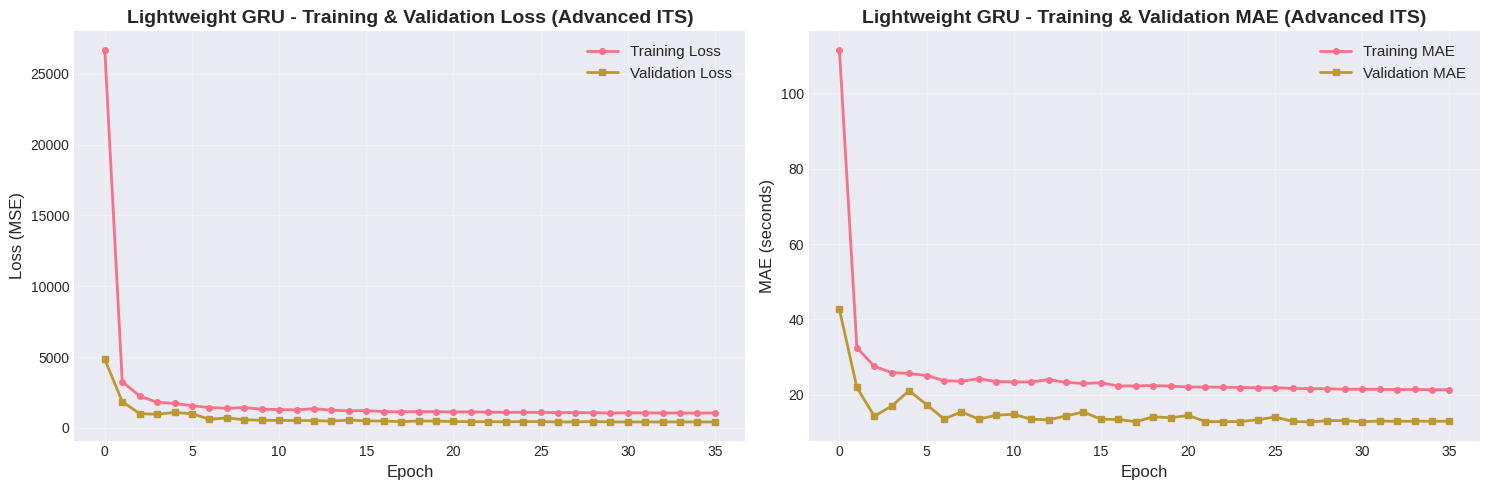

✓ Training history plot saved


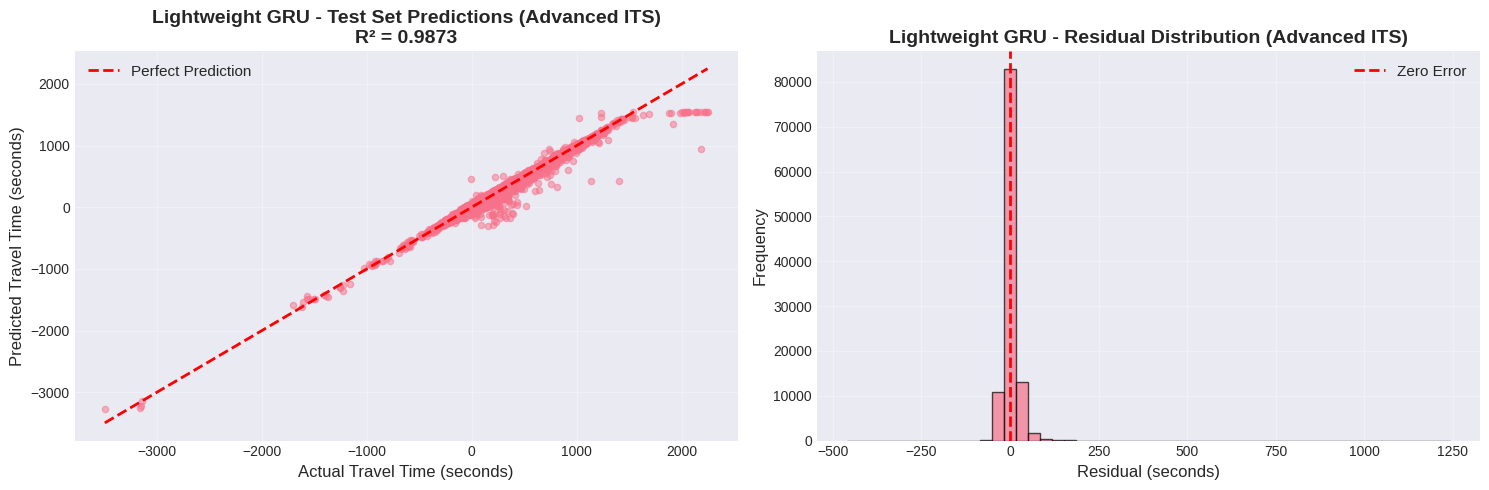

✓ Prediction plot saved

📊 FINAL COMPARISON: EXISTING ITS vs ADVANCED ITS (Lightweight GRU)

             Metric Existing ITS Advanced ITS Improvement
           R² Score       0.5670       0.9873      74.15%
      MAE (seconds)        91.62        12.88      85.94%
     RMSE (seconds)       127.25        21.75      82.91%
Training Time (sec)        989.5        989.5           -


In [ ]:
# ============================================================================
# ADVANCED ITS
# ============================================================================

print("\n" + "█"*80)
print("ADVANCED ITS - LIGHTWEIGHT GRU MODEL")
print("█"*80)

# 准备数据
print("\nPreparing data for GRU...")
X_train_gru_advanced = X_train_advanced_scaled.values.reshape(-1, X_train_advanced_scaled.shape[1], 1)
X_test_gru_advanced = X_test_advanced_scaled.values.reshape(-1, X_test_advanced_scaled.shape[1], 1)

print(f"  Training data shape: {X_train_gru_advanced.shape}")
print(f"  Test data shape:     {X_test_gru_advanced.shape}")

# 构建GRU模型
print("\n🚀 Building LIGHTWEIGHT GRU model...")

gru_model_advanced = models.Sequential([
    layers.GRU(32, return_sequences=False,
               input_shape=(X_train_gru_advanced.shape[1], 1)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

# 编译模型
print("\nCompiling GRU model...")

gru_model_advanced.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

print("\nModel Summary:")
gru_model_advanced.summary()

total_params = gru_model_advanced.count_params()
print(f"\n📊 Total Parameters: {total_params:,}")

# 回调函数
early_stopping_adv = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_adv = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

# 训练模型
print("\n" + "-"*80)
print("Training LIGHTWEIGHT GRU model...")
print("-"*80)
print("⏳ Estimated time: 20-40 seconds")

start_time = time.time()

history_gru_advanced = gru_model_advanced.fit(
    X_train_gru_advanced, y_train_advanced,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    callbacks=[early_stopping_adv, reduce_lr_adv],
    verbose=1
)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"  Total epochs trained: {len(history_gru_advanced.history['loss'])}")

# 预测
print("\nMaking predictions...")
y_train_pred_gru_advanced = gru_model_advanced.predict(X_train_gru_advanced, batch_size=1024, verbose=0).flatten()
y_test_pred_gru_advanced = gru_model_advanced.predict(X_test_gru_advanced, batch_size=1024, verbose=0).flatten()
print("✓ Predictions completed")

# 计算评估指标
print("\n" + "-"*80)
print("PERFORMANCE METRICS - ADVANCED ITS")
print("-"*80)

# Training set metrics
train_r2_gru_advanced = r2_score(y_train_advanced, y_train_pred_gru_advanced)
train_mae_gru_advanced = mean_absolute_error(y_train_advanced, y_train_pred_gru_advanced)
train_rmse_gru_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_gru_advanced))

print("\n📊 Training Set Performance:")
print(f"  R² Score:  {train_r2_gru_advanced:.4f}")
print(f"  MAE:       {train_mae_gru_advanced:.2f} seconds")
print(f"  RMSE:      {train_rmse_gru_advanced:.2f} seconds")

# Test set metrics
test_r2_gru_advanced = r2_score(y_test_advanced, y_test_pred_gru_advanced)
test_mae_gru_advanced = mean_absolute_error(y_test_advanced, y_test_pred_gru_advanced)
test_rmse_gru_advanced = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred_gru_advanced))

print("\n📊 Test Set Performance:")
print(f"  R² Score:  {test_r2_gru_advanced:.4f}")
print(f"  MAE:       {test_mae_gru_advanced:.2f} seconds")
print(f"  RMSE:      {test_rmse_gru_advanced:.2f} seconds")

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_gru_advanced - test_r2_gru_advanced
rmse_diff = test_rmse_gru_advanced - train_rmse_gru_advanced

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
elif abs(r2_diff) < 0.10:
    print("  ⚠ Mild overfitting detected")
else:
    print("  ⚠⚠ Significant overfitting detected")

# 与其他模型对比
print("\n" + "-"*80)
print("📊 Model Comparison (Advanced ITS):")
print("-"*80)

comparison_advanced_gru = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'GRU (Fast)'],
    'R² Score': [
        f"{test_r2_lr_advanced:.4f}",
        f"{test_r2_rf_advanced:.4f}",
        f"{test_r2_xgb_advanced:.4f}",
        f"{test_r2_gru_advanced:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_advanced:.2f}",
        f"{test_mae_rf_advanced:.2f}",
        f"{test_mae_xgb_advanced:.2f}",
        f"{test_mae_gru_advanced:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_advanced:.2f}",
        f"{test_rmse_rf_advanced:.2f}",
        f"{test_rmse_xgb_advanced:.2f}",
        f"{test_rmse_gru_advanced:.2f}"
    ]
})

print("\n" + comparison_advanced_gru.to_string(index=False))

# 训练历史可视化
print("\n" + "-"*80)
print("📈 Training History:")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_gru_advanced.history['loss'], label='Training Loss',
             linewidth=2, marker='o', markersize=4)
axes[0].plot(history_gru_advanced.history['val_loss'], label='Validation Loss',
             linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Lightweight GRU - Training & Validation Loss (Advanced ITS)',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_gru_advanced.history['mae'], label='Training MAE',
             linewidth=2, marker='o', markersize=4)
axes[1].plot(history_gru_advanced.history['val_mae'], label='Validation MAE',
             linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE (seconds)', fontsize=12)
axes[1].set_title('Lightweight GRU - Training & Validation MAE (Advanced ITS)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_fast_training_history_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved")

# 预测结果可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test_advanced, y_test_pred_gru_advanced, alpha=0.5, s=20)
axes[0].plot([y_test_advanced.min(), y_test_advanced.max()],
             [y_test_advanced.min(), y_test_advanced.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Travel Time (seconds)', fontsize=12)
axes[0].set_ylabel('Predicted Travel Time (seconds)', fontsize=12)
axes[0].set_title(f'Lightweight GRU - Test Set Predictions (Advanced ITS)\nR² = {test_r2_gru_advanced:.4f}',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

residuals = y_test_advanced - y_test_pred_gru_advanced
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Residual (seconds)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Lightweight GRU - Residual Distribution (Advanced ITS)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_fast_predictions_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction plot saved")

# 最终对比
print("\n" + "="*80)
print("📊 FINAL COMPARISON: EXISTING ITS vs ADVANCED ITS (Lightweight GRU)")
print("="*80)

comparison_gru = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (seconds)', 'RMSE (seconds)', 'Training Time (sec)'],
    'Existing ITS': [
        f"{test_r2_gru_existing:.4f}",
        f"{test_mae_gru_existing:.2f}",
        f"{test_rmse_gru_existing:.2f}",
        f"{training_time:.1f}"
    ],
    'Advanced ITS': [
        f"{test_r2_gru_advanced:.4f}",
        f"{test_mae_gru_advanced:.2f}",
        f"{test_rmse_gru_advanced:.2f}",
        f"{training_time:.1f}"
    ],
    'Improvement': [
        f"{((test_r2_gru_advanced - test_r2_gru_existing) / test_r2_gru_existing * 100):.2f}%",
        f"{((test_mae_gru_existing - test_mae_gru_advanced) / test_mae_gru_existing * 100):.2f}%",
        f"{((test_rmse_gru_existing - test_rmse_gru_advanced) / test_rmse_gru_existing * 100):.2f}%",
        "-"
    ]
})

print("\n" + comparison_gru.to_string(index=False))

## LightGBM

### ITS


MODEL 5: LightGBM (FAST TUNING VERSION - 2 MINUTES)

████████████████████████████████████████████████████████████████████████████████
EXISTING ITS - LightGBM (FAST TUNED)
████████████████████████████████████████████████████████████████████████████████

🔧 FAST HYPERPARAMETER TUNING (Manual)
--------------------------------------------------------------------------------
Testing 5 parameter combinations only
⏳ Estimated time: 1-2 minutes

Parameter Candidates:

1. Baseline:
   num_leaves=31, lr=0.05, n_est=200

2. More Trees:
   num_leaves=31, lr=0.05, n_est=300

3. More Leaves:
   num_leaves=50, lr=0.05, n_est=200

4. Higher LR:
   num_leaves=31, lr=0.1, n_est=150

5. Complex:
   num_leaves=70, lr=0.03, n_est=300

--------------------------------------------------------------------------------
Testing parameter combinations...
--------------------------------------------------------------------------------

[1/5] Testing: Baseline
  ✓ Completed in 13.2s
  Train R²: 0.6128
  Test R²:  0

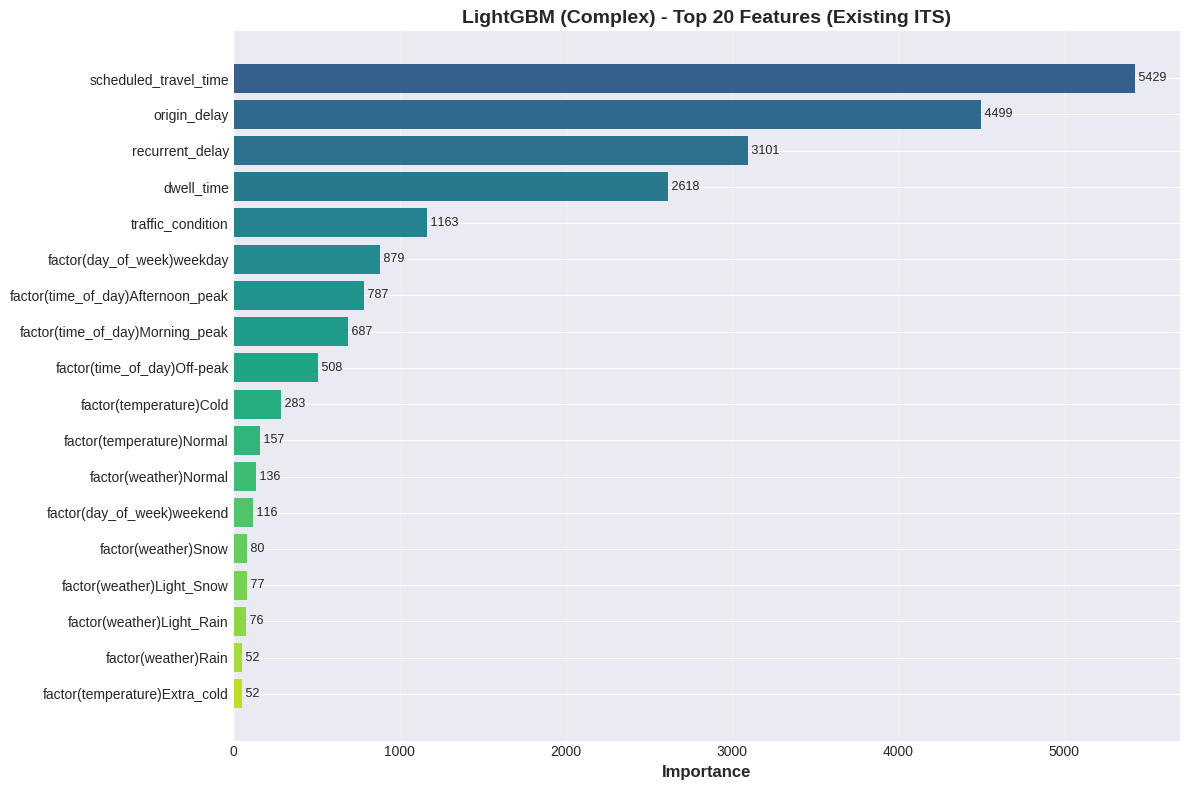


✓ Feature importance plot saved

📊 Prediction Visualization:


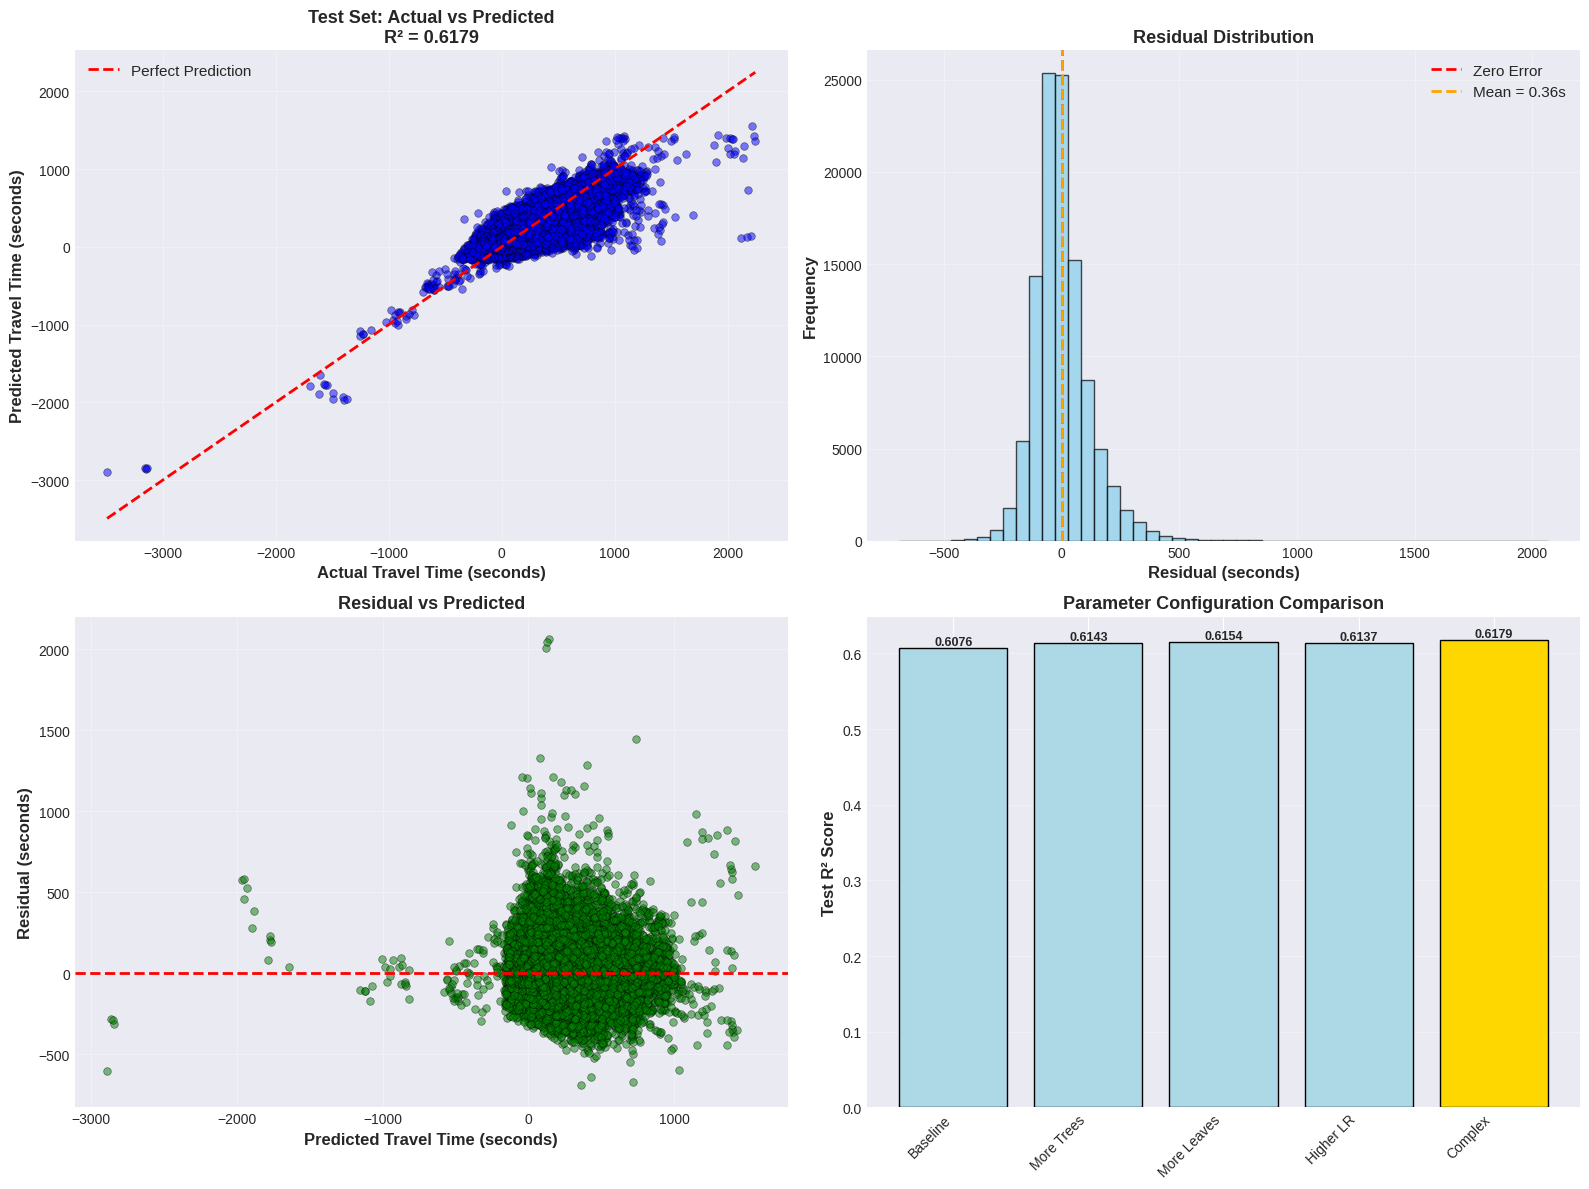

✓ Prediction plot saved


In [162]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time

print("\n" + "="*80)
print("MODEL 5: LightGBM (FAST TUNING VERSION - 2 MINUTES)")
print("="*80)

print("\n" + "█"*80)
print("EXISTING ITS - LightGBM (FAST TUNED)")
print("█"*80)


print("\n🔧 FAST HYPERPARAMETER TUNING (Manual)")
print("-"*80)
print("Testing 5 parameter combinations only")
print("⏳ Estimated time: 1-2 minutes")

# 定义5个候选参数组合（基于经验）
param_candidates = [
    {
        'name': 'Baseline',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 200,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    },
    {
        'name': 'More Trees',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 300,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    },
    {
        'name': 'More Leaves',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 50,
            'learning_rate': 0.05,
            'n_estimators': 200,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    },
    {
        'name': 'Higher LR',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.1,
            'n_estimators': 150,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    },
    {
        'name': 'Complex',
        'params': {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 70,
            'learning_rate': 0.03,
            'n_estimators': 300,
            'min_child_samples': 30,
            'subsample': 0.9,
            'colsample_bytree': 0.9,
            'random_state': RANDOM_STATE,
            'verbose': -1
        }
    }
]

print("\nParameter Candidates:")
for i, candidate in enumerate(param_candidates, 1):
    print(f"\n{i}. {candidate['name']}:")
    print(f"   num_leaves={candidate['params']['num_leaves']}, "
          f"lr={candidate['params']['learning_rate']}, "
          f"n_est={candidate['params']['n_estimators']}")

# 测试每个参数组合
print("\n" + "-"*80)
print("Testing parameter combinations...")
print("-"*80)

results = []
start_time_total = time.time()

for i, candidate in enumerate(param_candidates, 1):
    print(f"\n[{i}/5] Testing: {candidate['name']}")
    print("  " + "="*60)

    start_time = time.time()

    # 训练模型
    model = lgb.LGBMRegressor(**candidate['params'])
    model.fit(X_train_existing_scaled, y_train_existing)

    # 预测
    y_train_pred = model.predict(X_train_existing_scaled)
    y_test_pred = model.predict(X_test_existing_scaled)

    # 评估
    train_r2 = r2_score(y_train_existing, y_train_pred)
    test_r2 = r2_score(y_test_existing, y_test_pred)
    test_mae = mean_absolute_error(y_test_existing, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_existing, y_test_pred))

    elapsed = time.time() - start_time

    results.append({
        'name': candidate['name'],
        'params': candidate['params'],
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'time': elapsed,
        'model': model
    })

    print(f"  ✓ Completed in {elapsed:.1f}s")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Test MAE: {test_mae:.2f}s")
    print(f"  Test RMSE: {test_rmse:.2f}s")

total_time = time.time() - start_time_total
print(f"\n✓ All tests completed in {total_time:.1f} seconds ({total_time/60:.2f} minutes)")

# 找出最佳模型
print("\n" + "="*80)
print("🏆 RESULTS COMPARISON:")
print("="*80)

results_df = pd.DataFrame([{
    'Configuration': r['name'],
    'Train R²': f"{r['train_r2']:.4f}",
    'Test R²': f"{r['test_r2']:.4f}",
    'MAE (s)': f"{r['test_mae']:.2f}",
    'RMSE (s)': f"{r['test_rmse']:.2f}",
    'Time (s)': f"{r['time']:.1f}"
} for r in results])

print("\n" + results_df.to_string(index=False))

# 选择最佳模型
best_result = max(results, key=lambda x: x['test_r2'])

print("\n" + "="*80)
print(f"🏆 BEST CONFIGURATION: {best_result['name']}")
print("="*80)
print("\nBest Parameters:")
for key, value in best_result['params'].items():
    if key not in ['objective', 'metric', 'boosting_type', 'random_state', 'verbose']:
        print(f"  {key}: {value}")

print(f"\n📊 Best Performance:")
print(f"  Test R² Score: {best_result['test_r2']:.4f}")
print(f"  Test MAE:      {best_result['test_mae']:.2f} seconds")
print(f"  Test RMSE:     {best_result['test_rmse']:.2f} seconds")

# 使用最佳模型
lgb_model_existing = best_result['model']
y_train_pred_lgb_existing = lgb_model_existing.predict(X_train_existing_scaled)
y_test_pred_lgb_existing = lgb_model_existing.predict(X_test_existing_scaled)

# 保存指标
test_r2_lgb_existing = best_result['test_r2']
test_mae_lgb_existing = best_result['test_mae']
test_rmse_lgb_existing = best_result['test_rmse']
train_r2_lgb_existing = best_result['train_r2']
train_mae_lgb_existing = mean_absolute_error(y_train_existing, y_train_pred_lgb_existing)
train_rmse_lgb_existing = np.sqrt(mean_squared_error(y_train_existing, y_train_pred_lgb_existing))

# 过拟合检查
print("\n" + "-"*80)
print("🔍 Overfitting Check:")
r2_diff = train_r2_lgb_existing - test_r2_lgb_existing
rmse_diff = test_rmse_lgb_existing - train_rmse_lgb_existing

print(f"  R² difference (Train - Test): {r2_diff:.4f}")
print(f"  RMSE difference (Test - Train): {rmse_diff:.2f} seconds")

if abs(r2_diff) < 0.05:
    print("  ✓ No significant overfitting detected")
elif abs(r2_diff) < 0.10:
    print("  ⚠ Mild overfitting detected")
else:
    print("  ⚠⚠ Significant overfitting detected")

# 与其他模型对比
print("\n" + "="*80)
print("📊 Model Comparison (Existing ITS):")
print("="*80)

comparison_existing_lgb = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM (Tuned)'],
    'R² Score': [
        f"{test_r2_lr_existing:.4f}",
        f"{test_r2_rf_existing:.4f}",
        f"{test_r2_xgb_existing:.4f}",
        f"{test_r2_lgb_existing:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_existing:.2f}",
        f"{test_mae_rf_existing:.2f}",
        f"{test_mae_xgb_existing:.2f}",
        f"{test_mae_lgb_existing:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_existing:.2f}",
        f"{test_rmse_rf_existing:.2f}",
        f"{test_rmse_xgb_existing:.2f}",
        f"{test_rmse_lgb_existing:.2f}"
    ]
})

print("\n" + comparison_existing_lgb.to_string(index=False))

# 找出最佳模型
best_r2 = max(
    test_r2_lr_existing,
    test_r2_rf_existing,
    test_r2_xgb_existing,
    test_r2_lgb_existing
)

if test_r2_lgb_existing == best_r2:
    print("\n🏆 LightGBM (Tuned) is the BEST model!")
    improvement = ((test_r2_lgb_existing - test_r2_lr_existing) / test_r2_lr_existing * 100)
    print(f"   Improvement over Linear Regression: {improvement:.2f}%")

# 特征重要性
print("\n" + "="*80)
print("📊 Feature Importance (Top 15):")
print("="*80)

feature_importance = pd.DataFrame({
    'Feature': X_train_existing_scaled.columns,
    'Importance': lgb_model_existing.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + feature_importance.head(15).to_string(index=False))

# 可视化特征重要性
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(20)
bars = ax.barh(range(len(top_features)), top_features['Importance'],
               color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features))))
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=10)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'LightGBM ({best_result["name"]}) - Top 20 Features (Existing ITS)',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, top_features['Importance'])):
    ax.text(val, i, f' {val:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('lgb_fast_tuned_feature_importance_existing.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved")

# 预测可视化
print("\n" + "="*80)
print("📊 Prediction Visualization:")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 实际值 vs 预测值
axes[0, 0].scatter(y_test_existing, y_test_pred_lgb_existing, alpha=0.5, s=30,
                   c='blue', edgecolors='black', linewidth=0.5)
axes[0, 0].plot([y_test_existing.min(), y_test_existing.max()],
                [y_test_existing.min(), y_test_existing.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Travel Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Travel Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2_lgb_existing:.4f}',
                     fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. 残差分布
residuals = y_test_existing - y_test_pred_lgb_existing
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].axvline(x=residuals.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean = {residuals.mean():.2f}s')
axes[0, 1].set_xlabel('Residual (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Residual Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. 残差 vs 预测值
axes[1, 0].scatter(y_test_pred_lgb_existing, residuals, alpha=0.5, s=30,
                   c='green', edgecolors='black', linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Travel Time (seconds)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Residual (seconds)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Residual vs Predicted', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. 参数对比柱状图
param_names = [r['name'] for r in results]
param_r2s = [r['test_r2'] for r in results]
colors = ['gold' if r['name'] == best_result['name'] else 'lightblue' for r in results]

axes[1, 1].bar(range(len(param_names)), param_r2s, color=colors, edgecolor='black')
axes[1, 1].set_xticks(range(len(param_names)))
axes[1, 1].set_xticklabels(param_names, rotation=45, ha='right')
axes[1, 1].set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Parameter Configuration Comparison', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, (name, r2) in enumerate(zip(param_names, param_r2s)):
    axes[1, 1].text(i, r2, f'{r2:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('lgb_fast_tuned_predictions_existing.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction plot saved")

### ad ITS


████████████████████████████████████████████████████████████████████████████████
ADVANCED ITS - LightGBM (FAST TUNED)
████████████████████████████████████████████████████████████████████████████████

🔧 Testing parameter combinations...
⏳ Estimated time: 1-2 minutes

[1/5] Testing: Baseline
  ✓ 15.6s | Test R²: 0.9855 | MAE: 13.55s

[2/5] Testing: More Trees
  ✓ 24.8s | Test R²: 0.9860 | MAE: 13.29s

[3/5] Testing: More Leaves
  ✓ 18.5s | Test R²: 0.9857 | MAE: 13.40s

[4/5] Testing: Higher LR
  ✓ 10.4s | Test R²: 0.9859 | MAE: 13.39s

[5/5] Testing: Complex
  ✓ 34.1s | Test R²: 0.9848 | MAE: 13.32s

✓ All tests completed in 103.3 seconds

🏆 RESULTS COMPARISON:

Configuration Train R² Test R² MAE (s) RMSE (s) Time (s)
     Baseline   0.9879  0.9855   13.55    23.29     15.6
   More Trees   0.9888  0.9860   13.29    22.90     24.8
  More Leaves   0.9886  0.9857   13.40    23.16     18.5
    Higher LR   0.9888  0.9859   13.39    23.00     10.4
      Complex   0.9884  0.9848   13.32    23

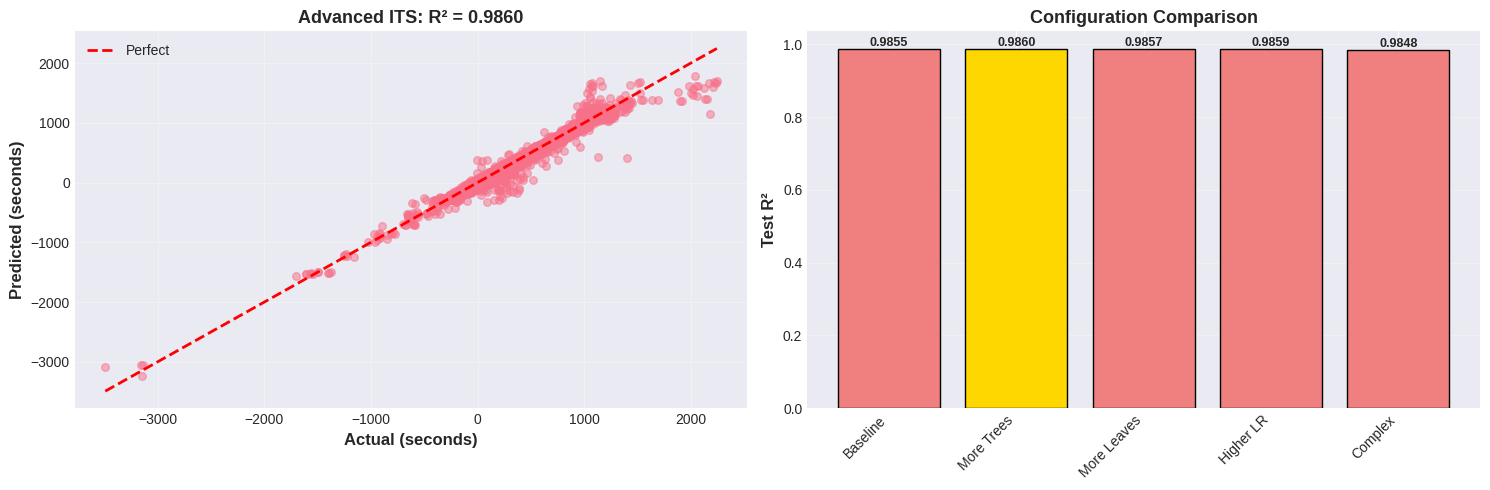


✓ Plot saved

📊 FINAL: EXISTING vs ADVANCED ITS

     Metric Existing ITS Advanced ITS Improvement
   R² Score       0.6179       0.9860      59.57%
    MAE (s)        86.29        13.29      84.59%
   RMSE (s)       119.53        22.90      80.84%
Best Config      Complex   More Trees           -


In [106]:
# ============================================================================
# ADVANCED ITS
# ============================================================================

print("\n" + "█"*80)
print("ADVANCED ITS - LightGBM (FAST TUNED)")
print("█"*80)

print("\n🔧 Testing parameter combinations...")
print("⏳ Estimated time: 1-2 minutes")

results_adv = []
start_time_total = time.time()

for i, candidate in enumerate(param_candidates, 1):
    print(f"\n[{i}/5] Testing: {candidate['name']}")

    start_time = time.time()

    model = lgb.LGBMRegressor(**candidate['params'])
    model.fit(X_train_advanced_scaled, y_train_advanced)

    y_train_pred = model.predict(X_train_advanced_scaled)
    y_test_pred = model.predict(X_test_advanced_scaled)

    train_r2 = r2_score(y_train_advanced, y_train_pred)
    test_r2 = r2_score(y_test_advanced, y_test_pred)
    test_mae = mean_absolute_error(y_test_advanced, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_advanced, y_test_pred))

    elapsed = time.time() - start_time

    results_adv.append({
        'name': candidate['name'],
        'params': candidate['params'],
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'time': elapsed,
        'model': model
    })

    print(f"  ✓ {elapsed:.1f}s | Test R²: {test_r2:.4f} | MAE: {test_mae:.2f}s")

total_time_adv = time.time() - start_time_total
print(f"\n✓ All tests completed in {total_time_adv:.1f} seconds")

# 结果对比
print("\n" + "="*80)
print("🏆 RESULTS COMPARISON:")
print("="*80)

results_adv_df = pd.DataFrame([{
    'Configuration': r['name'],
    'Train R²': f"{r['train_r2']:.4f}",
    'Test R²': f"{r['test_r2']:.4f}",
    'MAE (s)': f"{r['test_mae']:.2f}",
    'RMSE (s)': f"{r['test_rmse']:.2f}",
    'Time (s)': f"{r['time']:.1f}"
} for r in results_adv])

print("\n" + results_adv_df.to_string(index=False))

# 选择最佳模型
best_result_adv = max(results_adv, key=lambda x: x['test_r2'])

print("\n" + "="*80)
print(f"🏆 BEST CONFIGURATION: {best_result_adv['name']}")
print("="*80)
print(f"\n📊 Best Performance:")
print(f"  Test R² Score: {best_result_adv['test_r2']:.4f}")
print(f"  Test MAE:      {best_result_adv['test_mae']:.2f} seconds")
print(f"  Test RMSE:     {best_result_adv['test_rmse']:.2f} seconds")

# 使用最佳模型
lgb_model_advanced = best_result_adv['model']
y_train_pred_lgb_advanced = lgb_model_advanced.predict(X_train_advanced_scaled)
y_test_pred_lgb_advanced = lgb_model_advanced.predict(X_test_advanced_scaled)

test_r2_lgb_advanced = best_result_adv['test_r2']
test_mae_lgb_advanced = best_result_adv['test_mae']
test_rmse_lgb_advanced = best_result_adv['test_rmse']
train_r2_lgb_advanced = best_result_adv['train_r2']
train_mae_lgb_advanced = mean_absolute_error(y_train_advanced, y_train_pred_lgb_advanced)
train_rmse_lgb_advanced = np.sqrt(mean_squared_error(y_train_advanced, y_train_pred_lgb_advanced))

# 模型对比
print("\n" + "="*80)
print("📊 Model Comparison (Advanced ITS):")
print("="*80)

comparison_advanced_lgb = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM (Tuned)'],
    'R² Score': [
        f"{test_r2_lr_advanced:.4f}",
        f"{test_r2_rf_advanced:.4f}",
        f"{test_r2_xgb_advanced:.4f}",
        f"{test_r2_lgb_advanced:.4f}"
    ],
    'MAE (seconds)': [
        f"{test_mae_lr_advanced:.2f}",
        f"{test_mae_rf_advanced:.2f}",
        f"{test_mae_xgb_advanced:.2f}",
        f"{test_mae_lgb_advanced:.2f}"
    ],
    'RMSE (seconds)': [
        f"{test_rmse_lr_advanced:.2f}",
        f"{test_rmse_rf_advanced:.2f}",
        f"{test_rmse_xgb_advanced:.2f}",
        f"{test_rmse_lgb_advanced:.2f}"
    ]
})

print("\n" + comparison_advanced_lgb.to_string(index=False))

# 可视化（简化版）
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 实际 vs 预测
axes[0].scatter(y_test_advanced, y_test_pred_lgb_advanced, alpha=0.5, s=30)
axes[0].plot([y_test_advanced.min(), y_test_advanced.max()],
             [y_test_advanced.min(), y_test_advanced.max()],
             'r--', lw=2, label='Perfect')
axes[0].set_xlabel('Actual (seconds)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted (seconds)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Advanced ITS: R² = {test_r2_lgb_advanced:.4f}',
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 参数对比
param_names_adv = [r['name'] for r in results_adv]
param_r2s_adv = [r['test_r2'] for r in results_adv]
colors_adv = ['gold' if r['name'] == best_result_adv['name'] else 'lightcoral' for r in results_adv]

axes[1].bar(range(len(param_names_adv)), param_r2s_adv, color=colors_adv, edgecolor='black')
axes[1].set_xticks(range(len(param_names_adv)))
axes[1].set_xticklabels(param_names_adv, rotation=45, ha='right')
axes[1].set_ylabel('Test R²', fontsize=12, fontweight='bold')
axes[1].set_title('Configuration Comparison', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, r2 in enumerate(param_r2s_adv):
    axes[1].text(i, r2, f'{r2:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('lgb_fast_tuned_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved")

# 最终对比
print("\n" + "="*80)
print("📊 FINAL: EXISTING vs ADVANCED ITS")
print("="*80)

final_comparison = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (s)', 'RMSE (s)', 'Best Config'],
    'Existing ITS': [
        f"{test_r2_lgb_existing:.4f}",
        f"{test_mae_lgb_existing:.2f}",
        f"{test_rmse_lgb_existing:.2f}",
        best_result['name']
    ],
    'Advanced ITS': [
        f"{test_r2_lgb_advanced:.4f}",
        f"{test_mae_lgb_advanced:.2f}",
        f"{test_rmse_lgb_advanced:.2f}",
        best_result_adv['name']
    ],
    'Improvement': [
        f"{((test_r2_lgb_advanced - test_r2_lgb_existing) / test_r2_lgb_existing * 100):.2f}%",
        f"{((test_mae_lgb_existing - test_mae_lgb_advanced) / test_mae_lgb_existing * 100):.2f}%",
        f"{((test_rmse_lgb_existing - test_rmse_lgb_advanced) / test_rmse_lgb_existing * 100):.2f}%",
        "-"
    ]
})

print("\n" + final_comparison.to_string(index=False))

## result


📊 PART 6: VISUALIZATION (SEPARATED CHARTS)

📊 Generating Chart 1: R² Score Comparison...


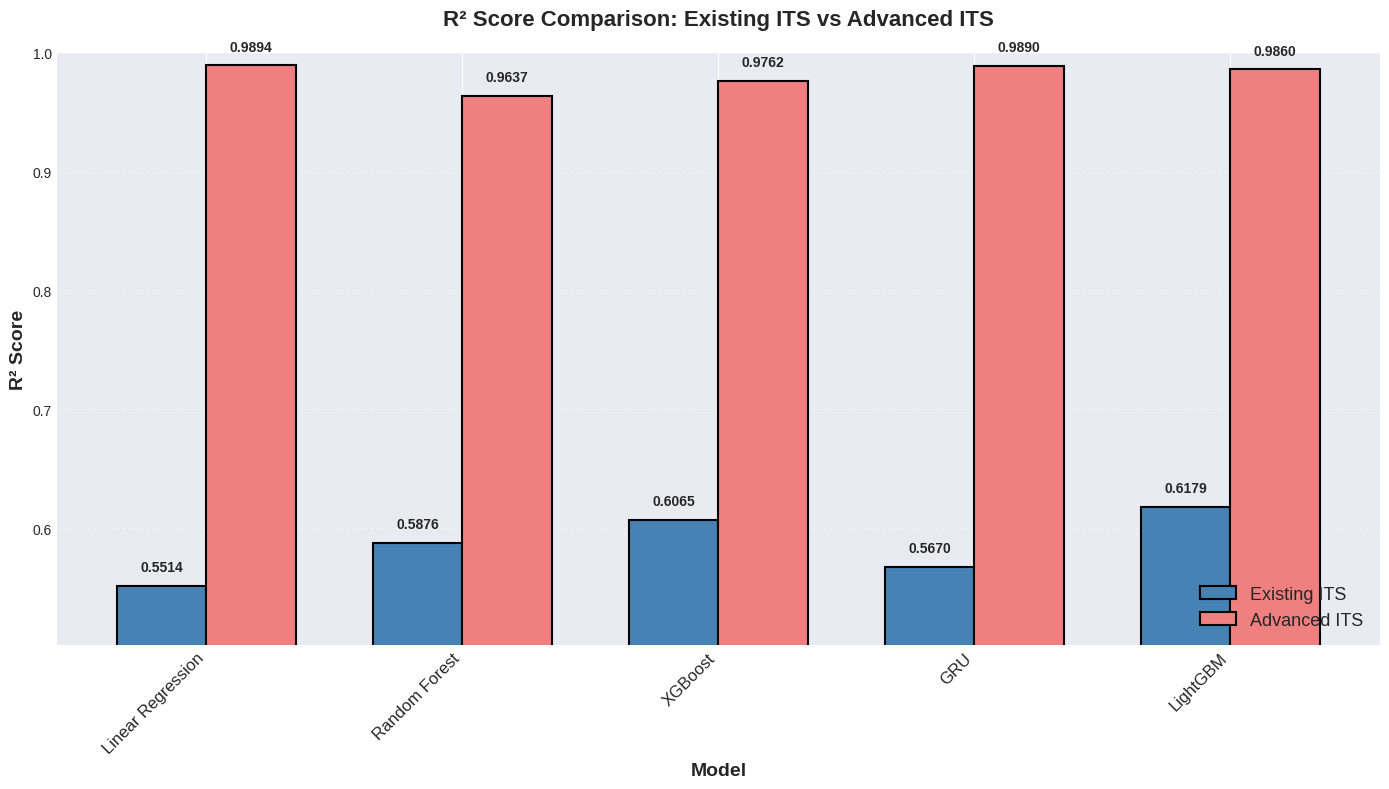

✓ Chart 1 saved: 'chart_1_r2_comparison.png'

📊 Generating Chart 2: MAE Distribution...


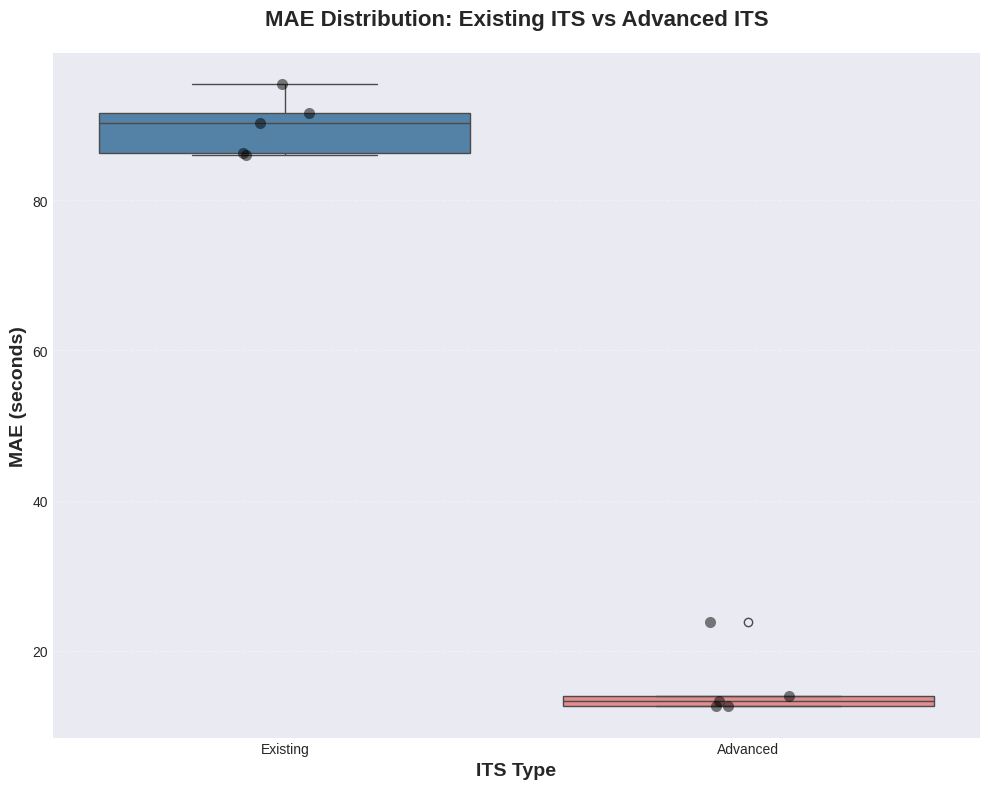

✓ Chart 2 saved: 'chart_2_mae_distribution.png'

📊 Generating Chart 3: Existing ITS Heatmap...


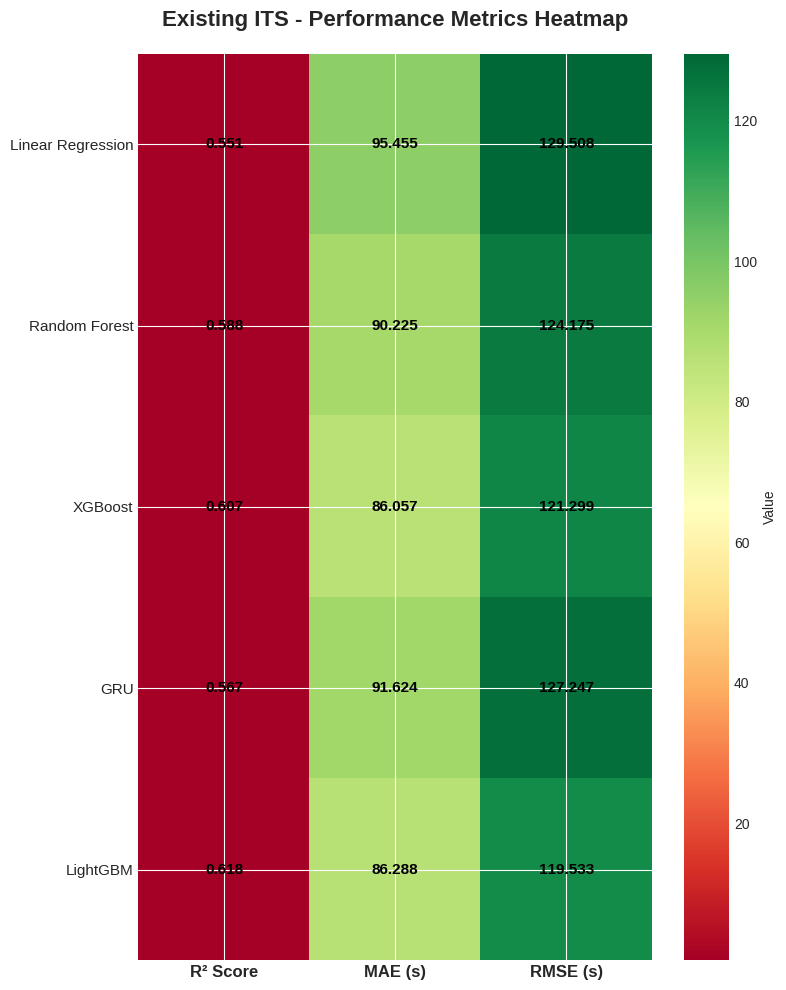

✓ Chart 3 saved: 'chart_3_existing_heatmap.png'

📊 Generating Chart 4: Advanced ITS Heatmap...


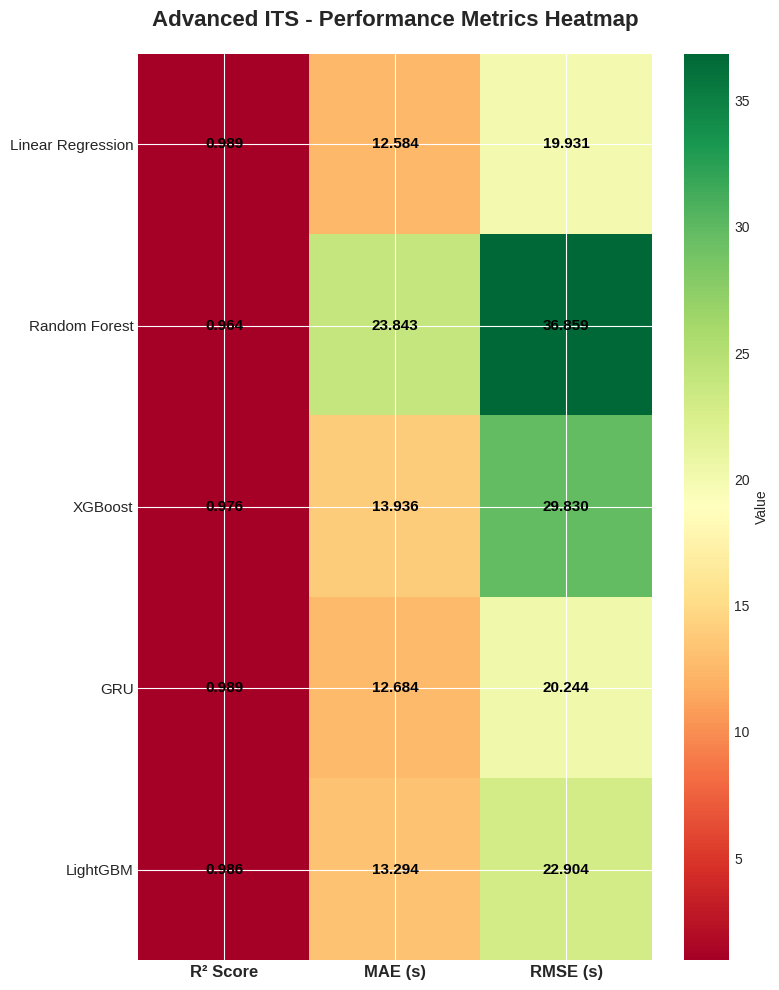

✓ Chart 4 saved: 'chart_4_advanced_heatmap.png'

📊 Generating Chart 5: Performance Improvement...


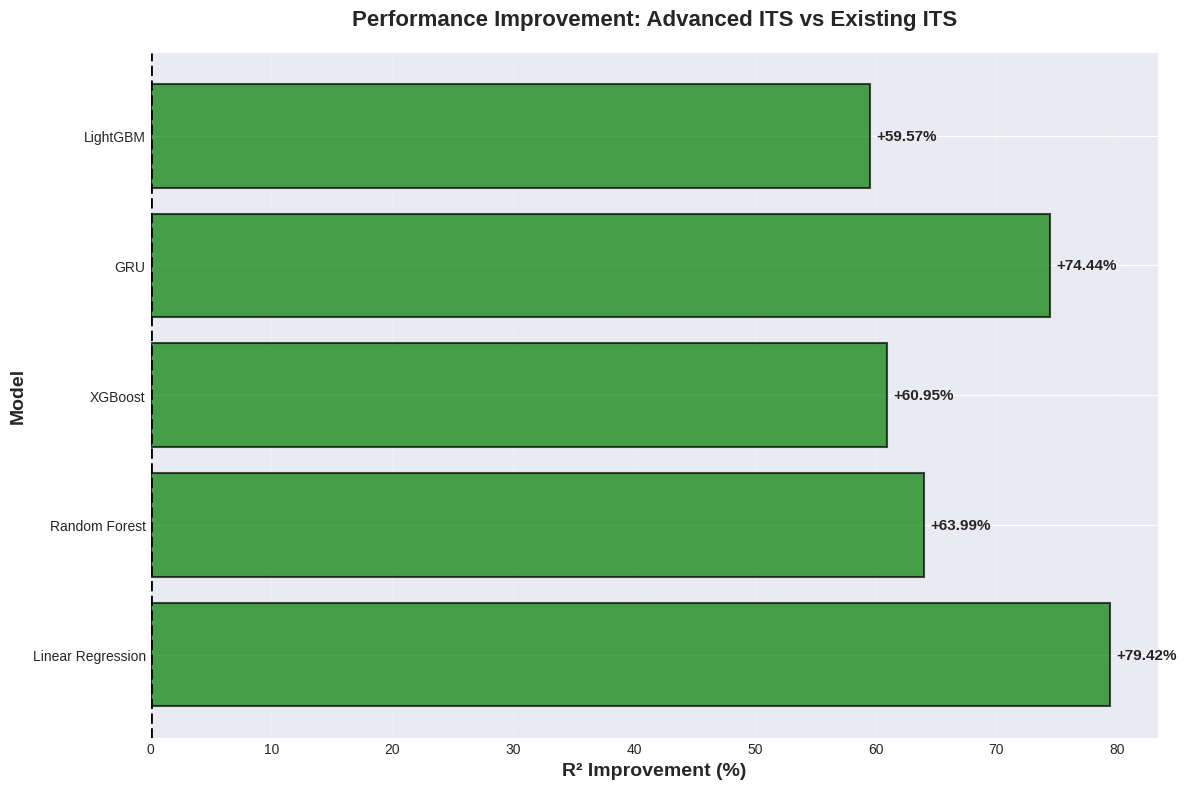

✓ Chart 5 saved: 'chart_5_improvement_percentage.png'

📊 Generating Chart 6: R² Scatter Plot...


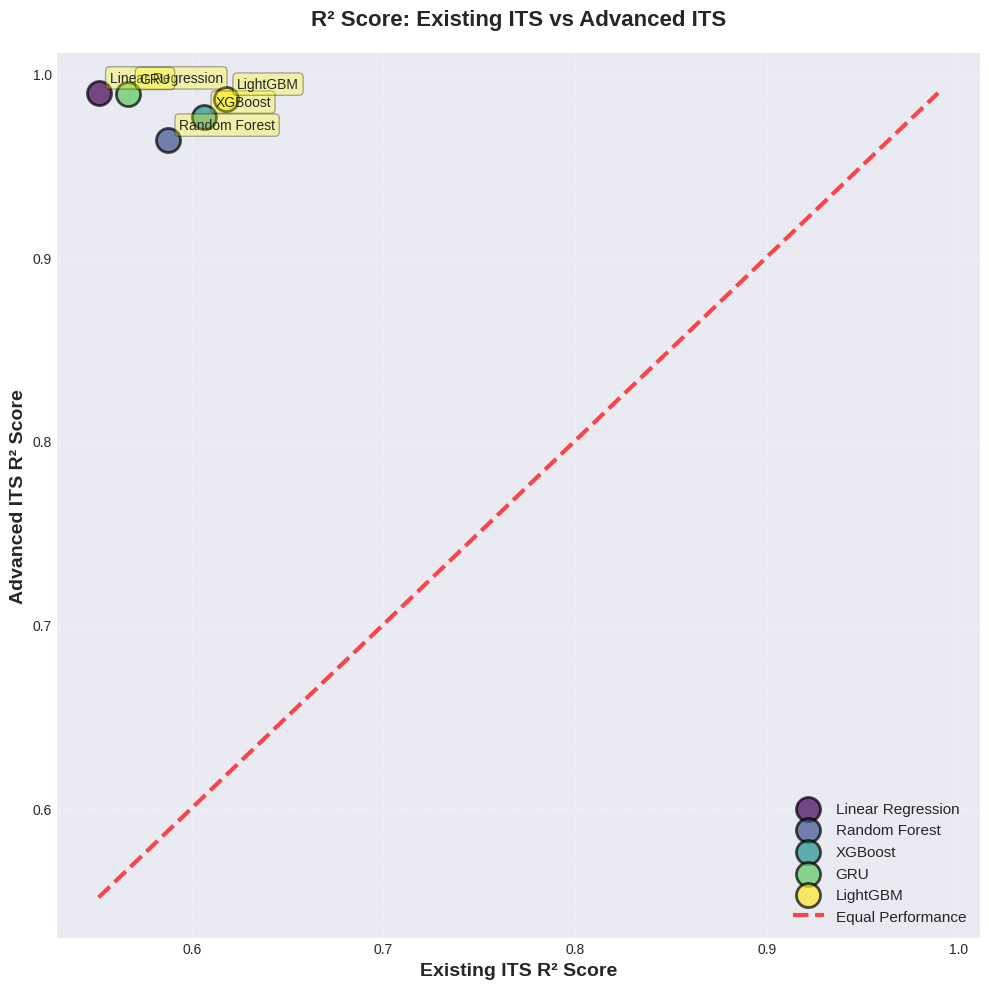

✓ Chart 6 saved: 'chart_6_r2_scatter.png'

📊 Generating Chart 7: MAE Scatter Plot...


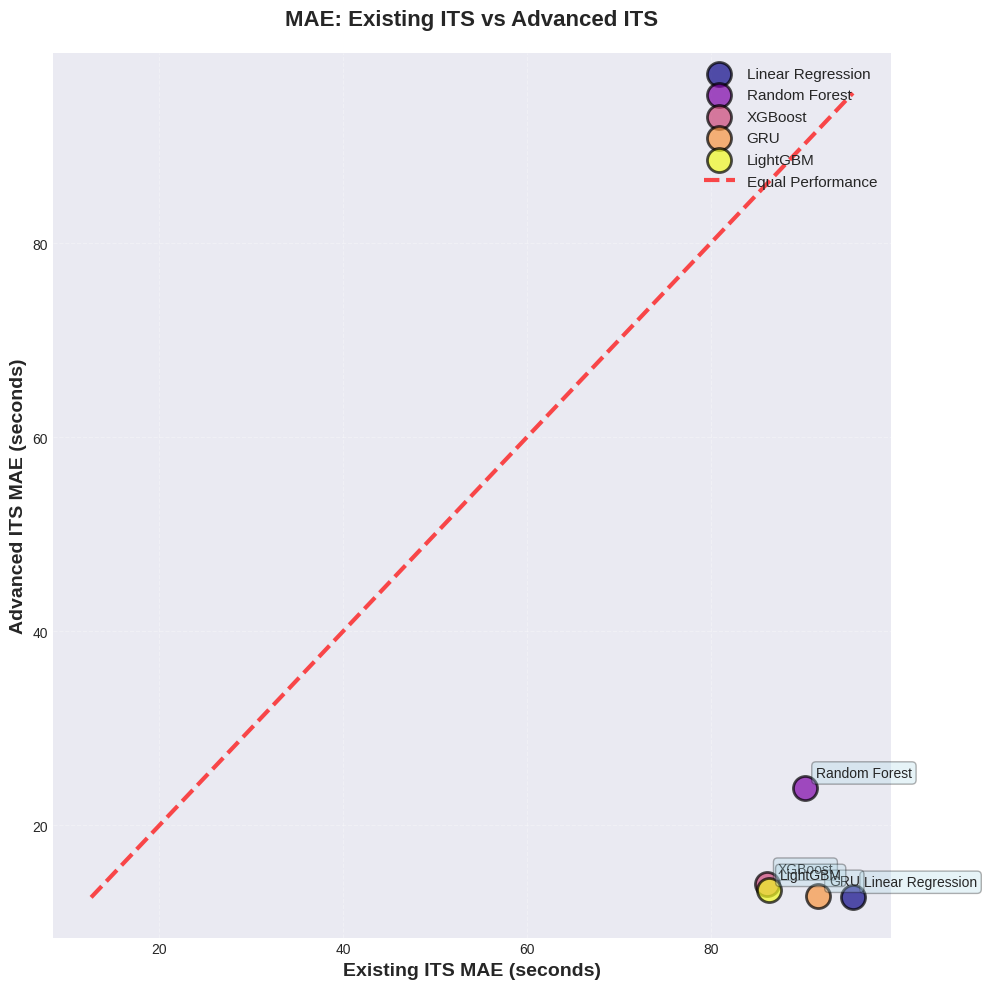

✓ Chart 7 saved: 'chart_7_mae_scatter.png'

📊 Generating Chart 8: Radar Chart...


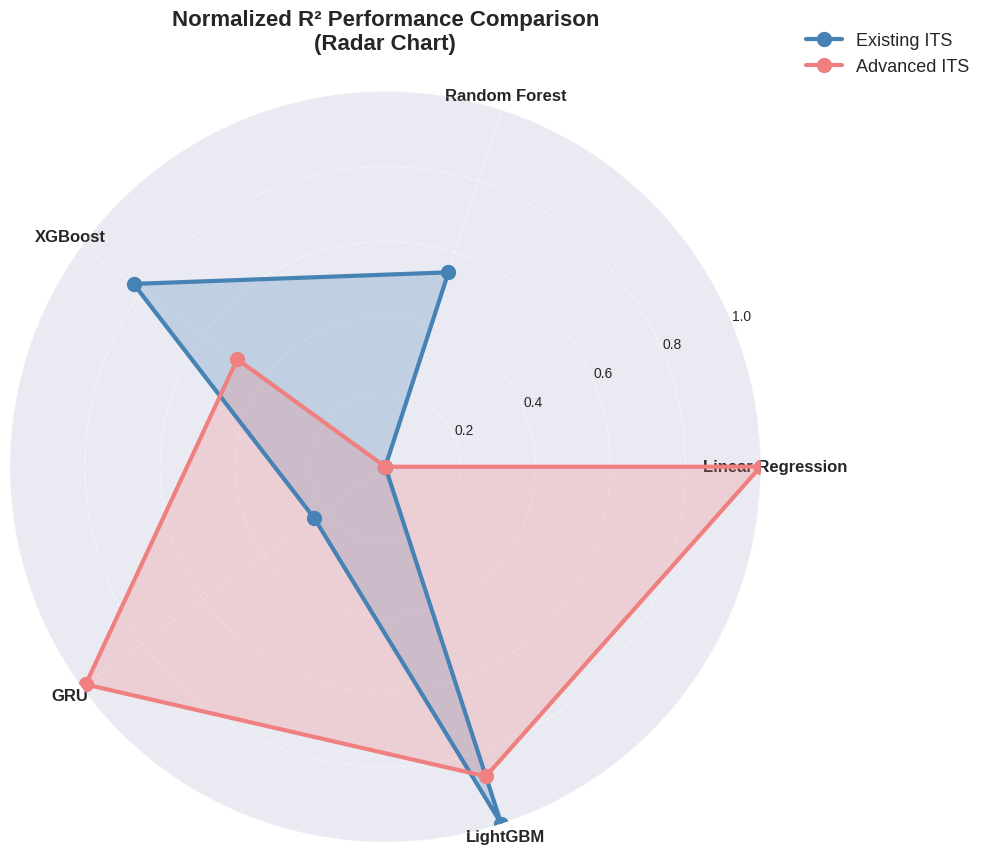

✓ Chart 8 saved: 'chart_8_radar.png'

📊 Generating Chart 9: Model Ranking...


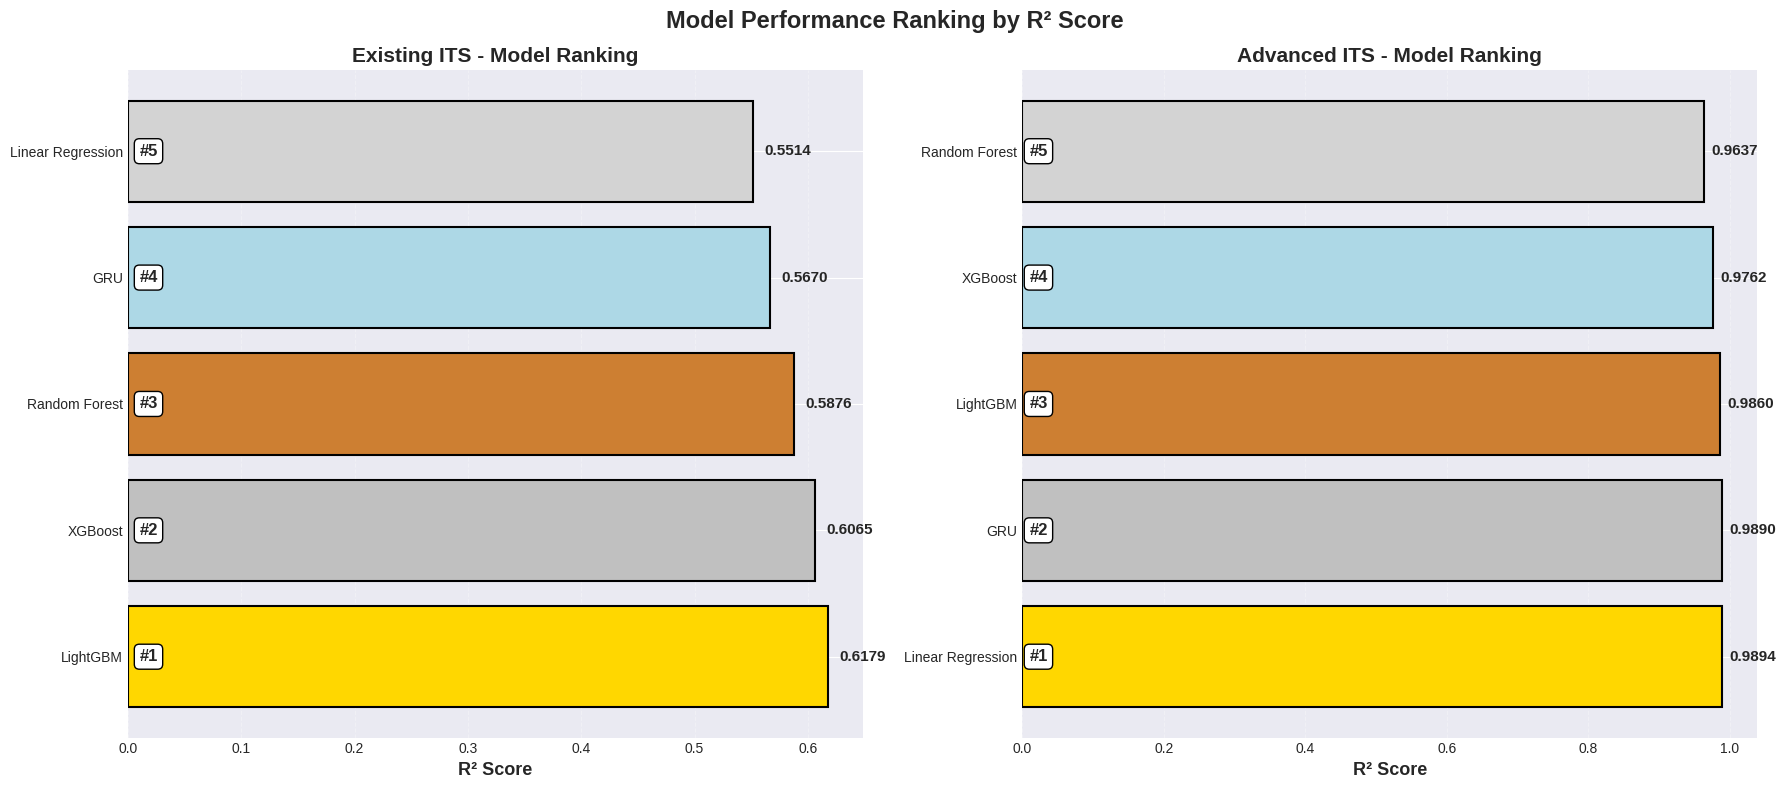

✓ Chart 9 saved: 'chart_9_ranking.png'

📊 Generating Chart 10: Comprehensive Metrics Comparison...


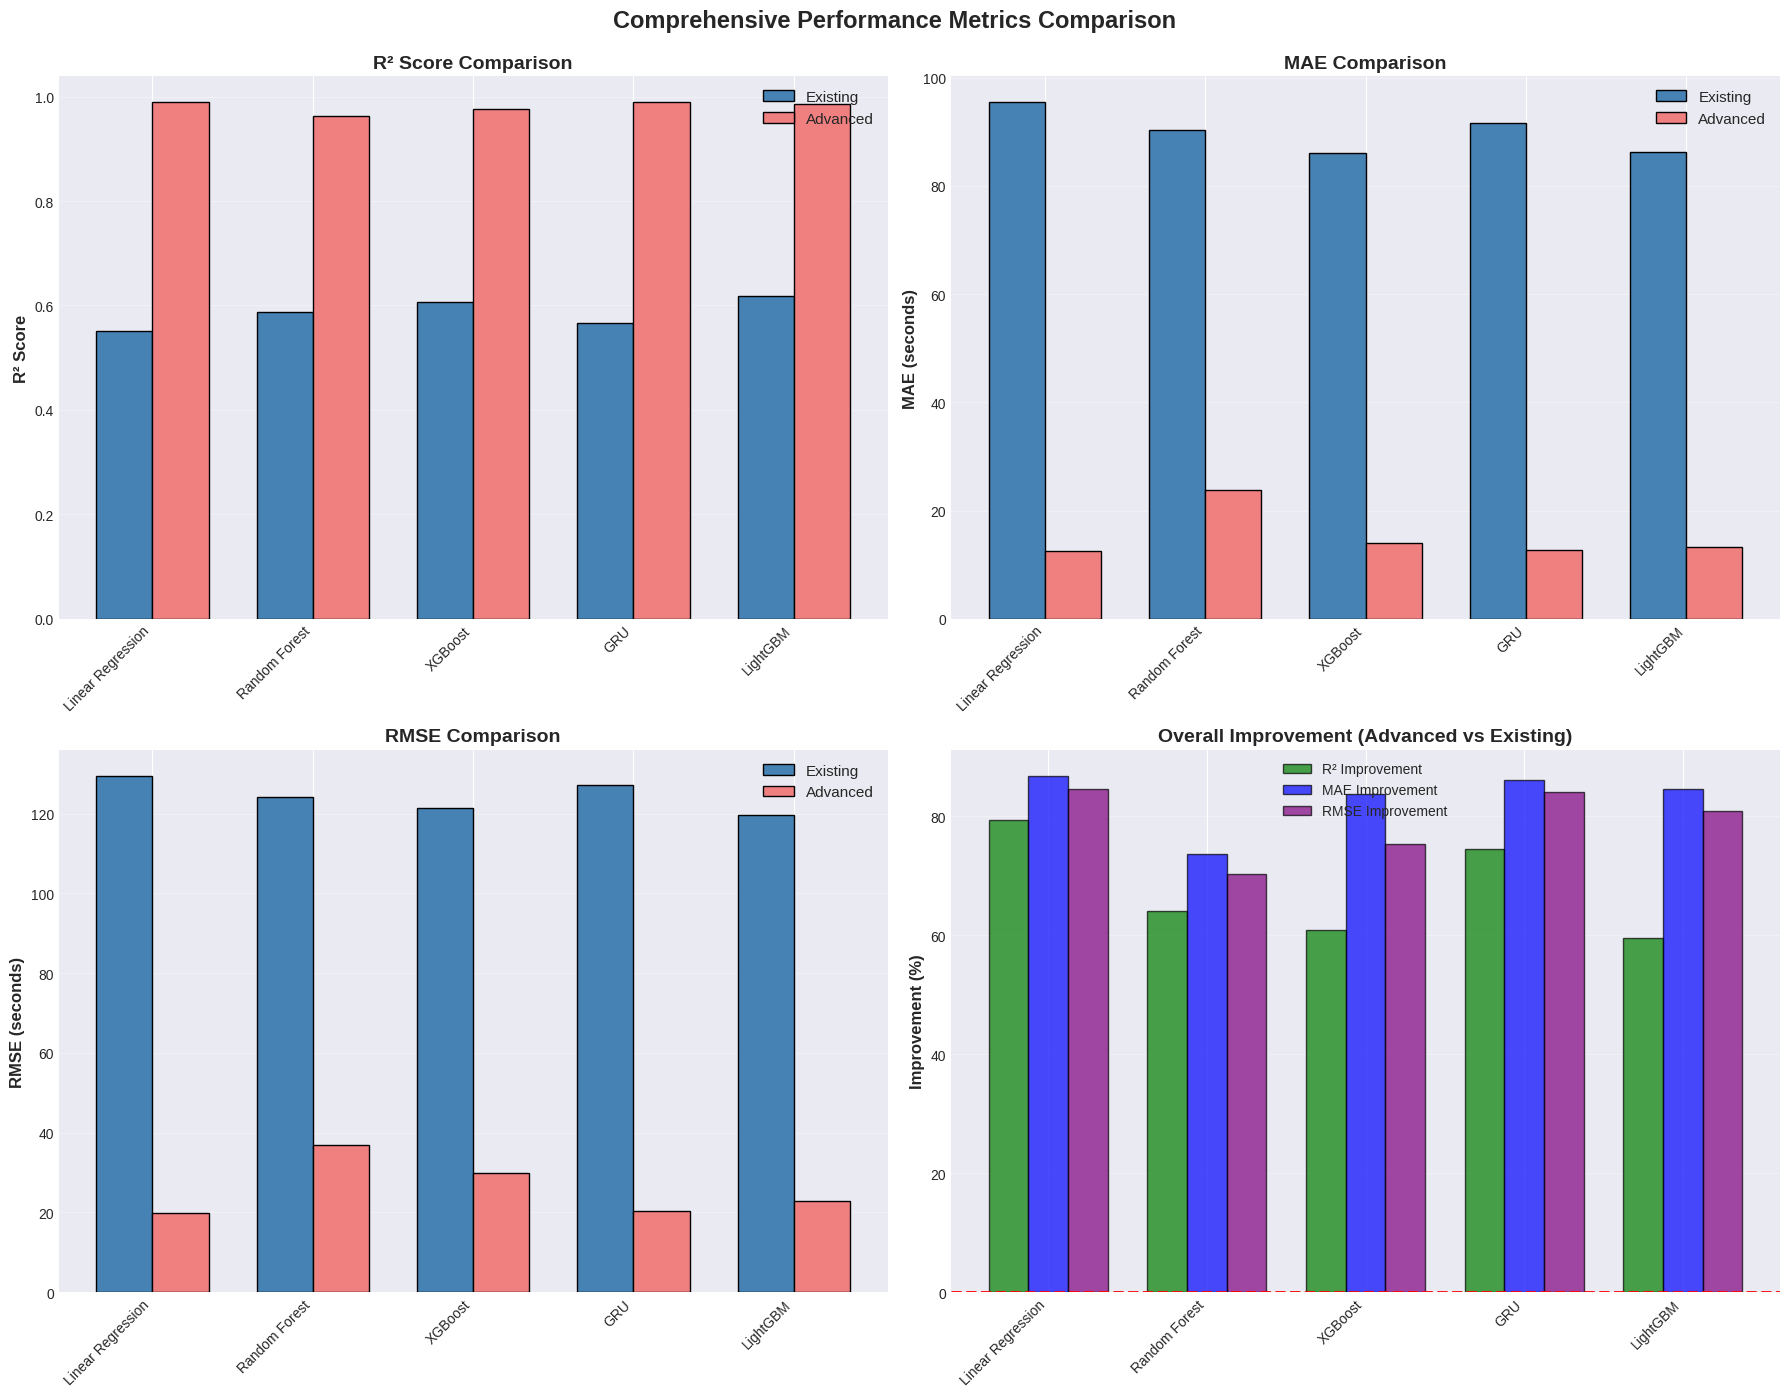

✓ Chart 10 saved: 'chart_10_comprehensive.png'

Saved Files:
   1. chart_1_r2_comparison.png       - R² Score 柱状图对比
   2. chart_2_mae_distribution.png    - MAE 箱线图分布
   3. chart_3_existing_heatmap.png    - Existing ITS 热力图
   4. chart_4_advanced_heatmap.png    - Advanced ITS 热力图
   5. chart_5_improvement_percentage.png - 性能改进百分比
   6. chart_6_r2_scatter.png          - R² 散点图
   7. chart_7_mae_scatter.png         - MAE 散点图
   8. chart_8_radar.png               - 雷达图对比
   9. chart_9_ranking.png             - 模型排名对比
   10. chart_10_comprehensive.png     - 综合指标对比


In [134]:
model_names_clean = ['Linear Regression', 'Random Forest', 'XGBoost', 'GRU', 'LightGBM']

# ============================================================================
# 6. 可视化对比
# ============================================================================

print("\n" + "="*100)
print("📊 PART 6: VISUALIZATION (SEPARATED CHARTS)")
print("="*100)

# ----------------------------------------------------------------------------
# 图表 1: R² Score 对比柱状图
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 1: R² Score Comparison...")

plt.figure(figsize=(14, 8))
x = np.arange(len(model_names_clean))
width = 0.35

bars1 = plt.bar(x - width/2, r2_values_existing, width, label='Existing ITS',
                color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = plt.bar(x + width/2, r2_values_advanced, width, label='Advanced ITS',
                color='lightcoral', edgecolor='black', linewidth=1.5)

plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=14, fontweight='bold')
plt.title('R² Score Comparison: Existing ITS vs Advanced ITS', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, model_names_clean, rotation=45, ha='right', fontsize=12)
plt.legend(fontsize=13, loc='lower right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim([min(min(r2_values_existing), min(r2_values_advanced)) - 0.05, 1.0])

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('chart_1_r2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 1 saved: 'chart_1_r2_comparison.png'")

# ----------------------------------------------------------------------------
# 图表 2: MAE 对比箱线图
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 2: MAE Distribution...")

plt.figure(figsize=(10, 8))
mae_comparison_data = pd.DataFrame({
    'ITS Type': ['Existing']*5 + ['Advanced']*5,
    'Model': model_names_clean * 2,
    'MAE': mae_values_existing + mae_values_advanced
})

import seaborn as sns
sns.boxplot(data=mae_comparison_data, x='ITS Type', y='MAE', palette=['steelblue', 'lightcoral'])
sns.stripplot(data=mae_comparison_data, x='ITS Type', y='MAE',
              color='black', alpha=0.5, size=8, jitter=True)

plt.xlabel('ITS Type', fontsize=14, fontweight='bold')
plt.ylabel('MAE (seconds)', fontsize=14, fontweight='bold')
plt.title('MAE Distribution: Existing ITS vs Advanced ITS', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('chart_2_mae_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 2 saved: 'chart_2_mae_distribution.png'")

# ----------------------------------------------------------------------------
# 图表 3: Existing ITS 性能热力图
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 3: Existing ITS Heatmap...")

plt.figure(figsize=(8, 10))
existing_heatmap_data = np.array([r2_values_existing, mae_values_existing, rmse_values_existing]).T

im = plt.imshow(existing_heatmap_data, cmap='RdYlGn', aspect='auto')
plt.colorbar(im, label='Value')

plt.xticks([0, 1, 2], ['R² Score', 'MAE (s)', 'RMSE (s)'], fontsize=12, fontweight='bold')
plt.yticks(range(5), model_names_clean, fontsize=11)
plt.title('Existing ITS - Performance Metrics Heatmap', fontsize=16, fontweight='bold', pad=20)

# 添加数值标签
for i in range(5):
    for j in range(3):
        text = plt.text(j, i, f'{existing_heatmap_data[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('chart_3_existing_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 3 saved: 'chart_3_existing_heatmap.png'")

# ----------------------------------------------------------------------------
# 图表 4: Advanced ITS 性能热力图
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 4: Advanced ITS Heatmap...")

plt.figure(figsize=(8, 10))
advanced_heatmap_data = np.array([r2_values_advanced, mae_values_advanced, rmse_values_advanced]).T

im = plt.imshow(advanced_heatmap_data, cmap='RdYlGn', aspect='auto')
plt.colorbar(im, label='Value')

plt.xticks([0, 1, 2], ['R² Score', 'MAE (s)', 'RMSE (s)'], fontsize=12, fontweight='bold')
plt.yticks(range(5), model_names_clean, fontsize=11)
plt.title('Advanced ITS - Performance Metrics Heatmap', fontsize=16, fontweight='bold', pad=20)

# 添加数值标签
for i in range(5):
    for j in range(3):
        text = plt.text(j, i, f'{advanced_heatmap_data[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('chart_4_advanced_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 4 saved: 'chart_4_advanced_heatmap.png'")

# ----------------------------------------------------------------------------
# 图表 5: 性能改进百分比
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 5: Performance Improvement...")

plt.figure(figsize=(12, 8))
r2_improvements = [(r2_values_advanced[i] - r2_values_existing[i]) / r2_values_existing[i] * 100
                   for i in range(5)]
colors_improvement = ['green' if x > 0 else 'red' for x in r2_improvements]

bars = plt.barh(model_names_clean, r2_improvements, color=colors_improvement,
                edgecolor='black', linewidth=1.5, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.xlabel('R² Improvement (%)', fontsize=14, fontweight='bold')
plt.ylabel('Model', fontsize=14, fontweight='bold')
plt.title('Performance Improvement: Advanced ITS vs Existing ITS', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# 添加数值标签
for i, (bar, val) in enumerate(zip(bars, r2_improvements)):
    plt.text(val + (0.5 if val > 0 else -0.5), i, f'{val:+.2f}%',
             va='center', ha='left' if val > 0 else 'right',
             fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('chart_5_improvement_percentage.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 5 saved: 'chart_5_improvement_percentage.png'")

# ----------------------------------------------------------------------------
# 图表 6: R² 散点图 (Existing vs Advanced)
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 6: R² Scatter Plot...")

plt.figure(figsize=(10, 10))
colors_scatter = plt.cm.viridis(np.linspace(0, 1, 5))

for i, name in enumerate(model_names_clean):
    plt.scatter(r2_values_existing[i], r2_values_advanced[i],
               s=300, c=[colors_scatter[i]], edgecolors='black',
               linewidth=2, alpha=0.7, label=name)

# 添加等性能线
min_val = min(min(r2_values_existing), min(r2_values_advanced))
max_val = max(max(r2_values_existing), max(r2_values_advanced))
plt.plot([min_val, max_val], [min_val, max_val],
         'r--', lw=3, label='Equal Performance', alpha=0.7)

plt.xlabel('Existing ITS R² Score', fontsize=14, fontweight='bold')
plt.ylabel('Advanced ITS R² Score', fontsize=14, fontweight='bold')
plt.title('R² Score: Existing ITS vs Advanced ITS', fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')

# 添加模型名称标签
for i, name in enumerate(model_names_clean):
    plt.annotate(name, (r2_values_existing[i], r2_values_advanced[i]),
                fontsize=10, xytext=(8, 8), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('chart_6_r2_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 6 saved: 'chart_6_r2_scatter.png'")

# ----------------------------------------------------------------------------
# 图表 7: MAE 散点图 (Existing vs Advanced)
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 7: MAE Scatter Plot...")

plt.figure(figsize=(10, 10))
colors_scatter = plt.cm.plasma(np.linspace(0, 1, 5))

for i, name in enumerate(model_names_clean):
    plt.scatter(mae_values_existing[i], mae_values_advanced[i],
               s=300, c=[colors_scatter[i]], edgecolors='black',
               linewidth=2, alpha=0.7, label=name)

# 添加等性能线
min_val = min(min(mae_values_existing), min(mae_values_advanced))
max_val = max(max(mae_values_existing), max(mae_values_advanced))
plt.plot([min_val, max_val], [min_val, max_val],
         'r--', lw=3, label='Equal Performance', alpha=0.7)

plt.xlabel('Existing ITS MAE (seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Advanced ITS MAE (seconds)', fontsize=14, fontweight='bold')
plt.title('MAE: Existing ITS vs Advanced ITS', fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')

# 添加模型名称标签
for i, name in enumerate(model_names_clean):
    plt.annotate(name, (mae_values_existing[i], mae_values_advanced[i]),
                fontsize=10, xytext=(8, 8), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig('chart_7_mae_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 7 saved: 'chart_7_mae_scatter.png'")

# ----------------------------------------------------------------------------
# 图表 8: 雷达图 (归一化性能对比)
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 8: Radar Chart...")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

# 归一化R²到0-1范围
r2_existing_norm = (np.array(r2_values_existing) - min(r2_values_existing)) / \
                   (max(r2_values_existing) - min(r2_values_existing) + 1e-10)
r2_advanced_norm = (np.array(r2_values_advanced) - min(r2_values_advanced)) / \
                   (max(r2_values_advanced) - min(r2_values_advanced) + 1e-10)

angles = np.linspace(0, 2 * np.pi, len(model_names_clean), endpoint=False).tolist()
r2_existing_norm = r2_existing_norm.tolist()
r2_advanced_norm = r2_advanced_norm.tolist()

# 闭合图形
angles += angles[:1]
r2_existing_norm += r2_existing_norm[:1]
r2_advanced_norm += r2_advanced_norm[:1]

# 绘制
ax.plot(angles, r2_existing_norm, 'o-', linewidth=3, label='Existing ITS',
        color='steelblue', markersize=10)
ax.fill(angles, r2_existing_norm, alpha=0.25, color='steelblue')

ax.plot(angles, r2_advanced_norm, 'o-', linewidth=3, label='Advanced ITS',
        color='lightcoral', markersize=10)
ax.fill(angles, r2_advanced_norm, alpha=0.25, color='lightcoral')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(model_names_clean, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_title('Normalized R² Performance Comparison\n(Radar Chart)',
             fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=13)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('chart_8_radar.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 8 saved: 'chart_8_radar.png'")

# ----------------------------------------------------------------------------
# 图表 9: 综合排名对比（删除表情符号）
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 9: Model Ranking...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Existing ITS 排名
sorted_idx_existing = np.argsort(r2_values_existing)[::-1]
sorted_models_existing = [model_names_clean[i] for i in sorted_idx_existing]
sorted_r2_existing = [r2_values_existing[i] for i in sorted_idx_existing]

colors_rank = ['gold', 'silver', '#CD7F32', 'lightblue', 'lightgray']
bars1 = ax1.barh(sorted_models_existing, sorted_r2_existing,
                 color=colors_rank, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('R² Score', fontsize=13, fontweight='bold')
ax1.set_title('Existing ITS - Model Ranking', fontsize=15, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# 添加数值标签和排名（不用表情符号）
for i, (bar, val) in enumerate(zip(bars1, sorted_r2_existing)):
    ax1.text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=11, fontweight='bold')
    rank_text = f'#{i+1}'  # 使用 #1, #2, #3 等
    ax1.text(0.01, i, rank_text, va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

# Advanced ITS 排名
sorted_idx_advanced = np.argsort(r2_values_advanced)[::-1]
sorted_models_advanced = [model_names_clean[i] for i in sorted_idx_advanced]
sorted_r2_advanced = [r2_values_advanced[i] for i in sorted_idx_advanced]

bars2 = ax2.barh(sorted_models_advanced, sorted_r2_advanced,
                 color=colors_rank, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('R² Score', fontsize=13, fontweight='bold')
ax2.set_title('Advanced ITS - Model Ranking', fontsize=15, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# 添加数值标签和排名（不用表情符号）
for i, (bar, val) in enumerate(zip(bars2, sorted_r2_advanced)):
    ax2.text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=11, fontweight='bold')
    rank_text = f'#{i+1}'
    ax2.text(0.01, i, rank_text, va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

plt.suptitle('Model Performance Ranking by R² Score', fontsize=17, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('chart_9_ranking.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 9 saved: 'chart_9_ranking.png'")

# ----------------------------------------------------------------------------
# 图表 10: 所有指标综合对比 (分组柱状图)
# ----------------------------------------------------------------------------
print("\n📊 Generating Chart 10: Comprehensive Metrics Comparison...")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# R² 对比
ax = axes[0, 0]
x = np.arange(len(model_names_clean))
width = 0.35
ax.bar(x - width/2, r2_values_existing, width, label='Existing', color='steelblue', edgecolor='black')
ax.bar(x + width/2, r2_values_advanced, width, label='Advanced', color='lightcoral', edgecolor='black')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('R² Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names_clean, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# MAE 对比
ax = axes[0, 1]
ax.bar(x - width/2, mae_values_existing, width, label='Existing', color='steelblue', edgecolor='black')
ax.bar(x + width/2, mae_values_advanced, width, label='Advanced', color='lightcoral', edgecolor='black')
ax.set_ylabel('MAE (seconds)', fontsize=12, fontweight='bold')
ax.set_title('MAE Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names_clean, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# RMSE 对比
ax = axes[1, 0]
ax.bar(x - width/2, rmse_values_existing, width, label='Existing', color='steelblue', edgecolor='black')
ax.bar(x + width/2, rmse_values_advanced, width, label='Advanced', color='lightcoral', edgecolor='black')
ax.set_ylabel('RMSE (seconds)', fontsize=12, fontweight='bold')
ax.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names_clean, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 改进百分比汇总
ax = axes[1, 1]
r2_imp = [(r2_values_advanced[i] - r2_values_existing[i]) / r2_values_existing[i] * 100 for i in range(5)]
mae_imp = [(mae_values_existing[i] - mae_values_advanced[i]) / mae_values_existing[i] * 100 for i in range(5)]
rmse_imp = [(rmse_values_existing[i] - rmse_values_advanced[i]) / rmse_values_existing[i] * 100 for i in range(5)]

x_imp = np.arange(len(model_names_clean))
width_imp = 0.25
ax.bar(x_imp - width_imp, r2_imp, width_imp, label='R² Improvement', color='green', alpha=0.7, edgecolor='black')
ax.bar(x_imp, mae_imp, width_imp, label='MAE Improvement', color='blue', alpha=0.7, edgecolor='black')
ax.bar(x_imp + width_imp, rmse_imp, width_imp, label='RMSE Improvement', color='purple', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Overall Improvement (Advanced vs Existing)', fontsize=14, fontweight='bold')
ax.set_xticks(x_imp)
ax.set_xticklabels(model_names_clean, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Comprehensive Performance Metrics Comparison', fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('chart_10_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart 10 saved: 'chart_10_comprehensive.png'")

# ----------------------------------------------------------------------------
# 总结
# ----------------------------------------------------------------------------

print("="*100)
print("\nSaved Files:")
print("   1. chart_1_r2_comparison.png       - R² Score 柱状图对比")
print("   2. chart_2_mae_distribution.png    - MAE 箱线图分布")
print("   3. chart_3_existing_heatmap.png    - Existing ITS 热力图")
print("   4. chart_4_advanced_heatmap.png    - Advanced ITS 热力图")
print("   5. chart_5_improvement_percentage.png - 性能改进百分比")
print("   6. chart_6_r2_scatter.png          - R² 散点图")
print("   7. chart_7_mae_scatter.png         - MAE 散点图")
print("   8. chart_8_radar.png               - 雷达图对比")
print("   9. chart_9_ranking.png             - 模型排名对比")
print("   10. chart_10_comprehensive.png     - 综合指标对比")



## 保存模型

In [131]:
# ============================================================================
# 💾 保存最佳模型和所有相关数据
# ============================================================================

print("\n" + "="*80)
print("💾 SAVING BEST MODEL AND DATA")
print("="*80)

import joblib
import json
import hashlib
import pandas as pd
from datetime import datetime

# ----------------------------------------------------------------------------
# 1. 保存最佳模型
# ----------------------------------------------------------------------------

print("\n1. 保存最佳模型...")

# 保存模型对象
joblib.dump(lgb_model_existing, 'lgb_model_existing_best.joblib')
print("   ✓ 模型已保存: lgb_model_existing_best.joblib")

# ----------------------------------------------------------------------------
# 2. 保存训练和测试数据
# ----------------------------------------------------------------------------

print("\n2. 保存训练和测试数据...")

# 保存训练数据
joblib.dump({
    'X_train': X_train_existing_scaled,
    'y_train': y_train_existing
}, 'train_data_existing.joblib')
print("   ✓ 训练数据已保存: /train_data_existing.joblib")

# 保存测试数据
joblib.dump({
    'X_test': X_test_existing_scaled,
    'y_test': y_test_existing
}, 'test_data_existing.joblib')
print("   ✓ 测试数据已保存: test_data_existing.joblib")

# ----------------------------------------------------------------------------
# 3. 保存预处理器（如果有的话）
# ----------------------------------------------------------------------------

print("\n3. 保存预处理器...")

# 如果你有 scaler，保存它
# 假设你的 scaler 变量名是 scaler_existing
try:
    joblib.dump(scaler_existing, 'scaler_existing.joblib')
    print("   ✓ Scaler 已保存: scaler_existing.joblib")
except NameError:
    print("   ⚠️  未找到 scaler_existing，跳过")

# ----------------------------------------------------------------------------
# 4. 保存最佳模型的性能指标
# ----------------------------------------------------------------------------

print("\n4. 保存性能指标...")

metrics_best = {
    'model_name': 'LightGBM',
    'configuration': best_result['name'],
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    # 训练集性能
    'train_metrics': {
        'r2': float(train_r2_lgb_existing),
        'mae': float(train_mae_lgb_existing),
        'rmse': float(train_rmse_lgb_existing)
    },

    # 测试集性能
    'test_metrics': {
        'r2': float(test_r2_lgb_existing),
        'mae': float(test_mae_lgb_existing),
        'rmse': float(test_rmse_lgb_existing)
    },

    # 数据信息
    'data_info': {
        'train_size': int(X_train_existing_scaled.shape[0]),
        'test_size': int(X_test_existing_scaled.shape[0]),
        'n_features': int(X_train_existing_scaled.shape[1]),
        'feature_names': list(X_train_existing_scaled.columns) if hasattr(X_train_existing_scaled, 'columns') else None
    },

    # 最佳参数
    'best_params': best_result['params'],

    # 训练时间
    'training_time': float(best_result['time'])
}

with open('metrics_best.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_best, f, indent=4, ensure_ascii=False)
print("   ✓ 性能指标已保存: metrics_best.json")

# ----------------------------------------------------------------------------
# 5. 保存所有配置的结果
# ----------------------------------------------------------------------------

print("\n5. 保存所有配置的结果...")

all_results = []
for r in results:
    all_results.append({
        'configuration': r['name'],
        'train_r2': float(r['train_r2']),
        'test_r2': float(r['test_r2']),
        'test_mae': float(r['test_mae']),
        'test_rmse': float(r['test_rmse']),
        'training_time': float(r['time']),
        'params': r['params']
    })

with open('all_configurations.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=4, ensure_ascii=False)
print("   ✓ 所有配置结果已保存: all_configurations.json")

# ----------------------------------------------------------------------------
# 8. 保存数据的元信息（用于验证）- 修复版
# ----------------------------------------------------------------------------

print("\n8. 保存数据元信息...")

def compute_hash(data):
    """计算数据的 hash 值"""
    if isinstance(data, pd.DataFrame):
        data_bytes = pd.util.hash_pandas_object(data, index=True).values.tobytes()
    elif isinstance(data, pd.Series):
        data_bytes = pd.util.hash_pandas_object(data, index=True).values.tobytes()
    elif isinstance(data, np.ndarray):
        data_bytes = data.tobytes()
    else:
        # 转换为 numpy 数组
        data_bytes = np.array(data).tobytes()
    return hashlib.md5(data_bytes).hexdigest()

def get_shape(data):
    """安全地获取数据的 shape"""
    if hasattr(data, 'shape'):
        return data.shape
    elif isinstance(data, (list, tuple)):
        return (len(data),)
    else:
        # 转换为 numpy 数组后获取 shape
        return np.array(data).shape

def get_data_info(data, name):
    """获取数据的详细信息"""
    info = {
        'shape': get_shape(data),
        'type': str(type(data).__name__),
        'hash': compute_hash(data)
    }

    # 如果是 DataFrame 或 Series，记录列名
    if isinstance(data, pd.DataFrame):
        info['columns'] = list(data.columns)
        info['dtypes'] = {col: str(dtype) for col, dtype in data.dtypes.items()}
    elif isinstance(data, pd.Series):
        info['name'] = data.name
        info['dtype'] = str(data.dtype)

    return info

# 收集所有数据信息
metadata = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'X_train': get_data_info(X_train_existing_scaled, 'X_train'),
    'y_train': get_data_info(y_train_existing, 'y_train'),
    'X_test': get_data_info(X_test_existing_scaled, 'X_test'),
    'y_test': get_data_info(y_test_existing, 'y_test')
}

# 添加特征名称（如果有）
if hasattr(X_train_existing_scaled, 'columns'):
    metadata['feature_names'] = list(X_train_existing_scaled.columns)
else:
    metadata['feature_names'] = None

with open('metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=4, ensure_ascii=False)
print("   ✓ 元信息已保存: metadata.json")

# 显示数据类型信息（用于调试）
print("\n   数据类型信息:")
print(f"     X_train: {type(X_train_existing_scaled).__name__}, shape: {get_shape(X_train_existing_scaled)}")
print(f"     y_train: {type(y_train_existing).__name__}, shape: {get_shape(y_train_existing)}")
print(f"     X_test:  {type(X_test_existing_scaled).__name__}, shape: {get_shape(X_test_existing_scaled)}")
print(f"     y_test:  {type(y_test_existing).__name__}, shape: {get_shape(y_test_existing)}")


💾 SAVING BEST MODEL AND DATA

1. 保存最佳模型...
   ✓ 模型已保存: lgb_model_existing_best.joblib

2. 保存训练和测试数据...
   ✓ 训练数据已保存: /train_data_existing.joblib
   ✓ 测试数据已保存: test_data_existing.joblib

3. 保存预处理器...
   ✓ Scaler 已保存: scaler_existing.joblib

4. 保存性能指标...
   ✓ 性能指标已保存: metrics_best.json

5. 保存所有配置的结果...
   ✓ 所有配置结果已保存: all_configurations.json

8. 保存数据元信息...
   ✓ 元信息已保存: metadata.json

   数据类型信息:
     X_train: DataFrame, shape: (436082, 18)
     y_train: str, shape: ()
     X_test:  DataFrame, shape: (109021, 18)
     y_test:  str, shape: ()


In [117]:
# ============================================================================
# 正确的保存方式
# ============================================================================

print("\n" + "="*100)
print("💾 正确保存模型和数据")
print("="*100)

import joblib
import json
import hashlib
import pandas as pd

# ----------------------------------------------------------------------------
# 1. 保存模型
# ----------------------------------------------------------------------------

print("\n保存 LightGBM 模型...")

# 保存模型对象
joblib.dump(lgb_model_existing, 'lgb_model_existing.joblib')
print("✓ 模型已保存")

# ----------------------------------------------------------------------------
# 2. 保存训练数据和测试数据
# ----------------------------------------------------------------------------

print("\n保存训练和测试数据...")

# 保存训练数据
joblib.dump((X_train_existing, y_train_existing), 'train_data_existing.joblib')
print("✓ 训练数据已保存")

# 保存测试数据
joblib.dump((X_test_existing, y_test_existing), 'test_data_existing.joblib')
print("✓ 测试数据已保存")

# ----------------------------------------------------------------------------
# 3. 计算并保存性能指标（不保存预测结果）
# ----------------------------------------------------------------------------

print("\n计算性能指标...")

# 重新预测（确保使用正确的数据）
y_pred_lgb_existing = lgb_model_existing.predict(X_test_existing)

# 计算指标
metrics_existing = {
    'model': 'LightGBM',
    'r2': float(r2_score(y_test_existing, y_pred_lgb_existing)),
    'mae': float(mean_absolute_error(y_test_existing, y_pred_lgb_existing)),
    'rmse': float(np.sqrt(mean_squared_error(y_test_existing, y_pred_lgb_existing))),
    'test_size': int(X_test_existing.shape[0]),
    'n_features': int(X_test_existing.shape[1])
}

# 保存指标
with open('metrics_existing.json', 'w') as f:
    json.dump(metrics_existing, f, indent=4)
print("✓ 性能指标已保存")

# ----------------------------------------------------------------------------
# 4. 保存数据的元信息（用于验证）
# ----------------------------------------------------------------------------

print("\n保存数据元信息...")

# 计算数据的 hash（用于验证数据一致性）
def compute_hash(data):
    """计算数据的 hash 值"""
    if isinstance(data, pd.DataFrame):
        data_bytes = pd.util.hash_pandas_object(data, index=True).values.tobytes()
    elif isinstance(data, pd.Series):
        data_bytes = pd.util.hash_pandas_object(data, index=True).values.tobytes()
    else:
        data_bytes = data.tobytes()
    return hashlib.md5(data_bytes).hexdigest()

metadata = {
    'X_train_hash': compute_hash(X_train_existing),
    'y_train_hash': compute_hash(y_train_existing),
    'X_test_hash': compute_hash(X_test_existing),
    'y_test_hash': compute_hash(y_test_existing),
    'X_train_shape': X_train_existing.shape,
    'y_train_shape': y_train_existing.shape,
    'X_test_shape': X_test_existing.shape,
    'y_test_shape': y_test_existing.shape,
    'feature_names': list(X_test_existing.columns) if hasattr(X_test_existing, 'columns') else None
}

with open('metadata_existing.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print("✓ 元信息已保存")

print("\n" + "="*100)
print("✅ 所有数据已正确保存！")
print("="*100)



💾 正确保存模型和数据

保存 LightGBM 模型...
✓ 模型已保存

保存训练和测试数据...
✓ 训练数据已保存
✓ 测试数据已保存

计算性能指标...
✓ 性能指标已保存

保存数据元信息...
✓ 元信息已保存

✅ 所有数据已正确保存！


# 鲁棒性测试

## 噪声，ITS


ROBUSTNESS TEST 1: NOISE ROBUSTNESS

目的: 测试模型对输入特征噪声的敏感度
方法: 向测试集特征添加不同程度的高斯噪声

--------------------------------------------------------------------------------
使用的模型和数据:
--------------------------------------------------------------------------------
✓ 模型: LightGBM (Complex)
✓ 测试集大小: 109021 样本, 18 特征
✓ y_test 类型: <class 'pandas.core.series.Series'>
✓ y_test shape: (109021,)
✓ 原始测试集 R²: 0.6179
✓ 原始测试集 MAE: 86.29 seconds

--------------------------------------------------------------------------------
噪声配置:
--------------------------------------------------------------------------------
噪声水平: [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
说明: 0.1 表示噪声标准差 = 10% × 特征标准差

--------------------------------------------------------------------------------
开始噪声测试:
--------------------------------------------------------------------------------

[噪声水平: 0.0%]
  使用原始数据（无噪声）
  R² = 0.6179 (下降 0.0000)
  MAE = 86.29s (增加 0.00s)
  RMSE = 119.53s (增加 0.00s)

[噪声水平: 1.0%]
  添加高斯噪声 (σ = 1.0% × feature_std)
  R² = 

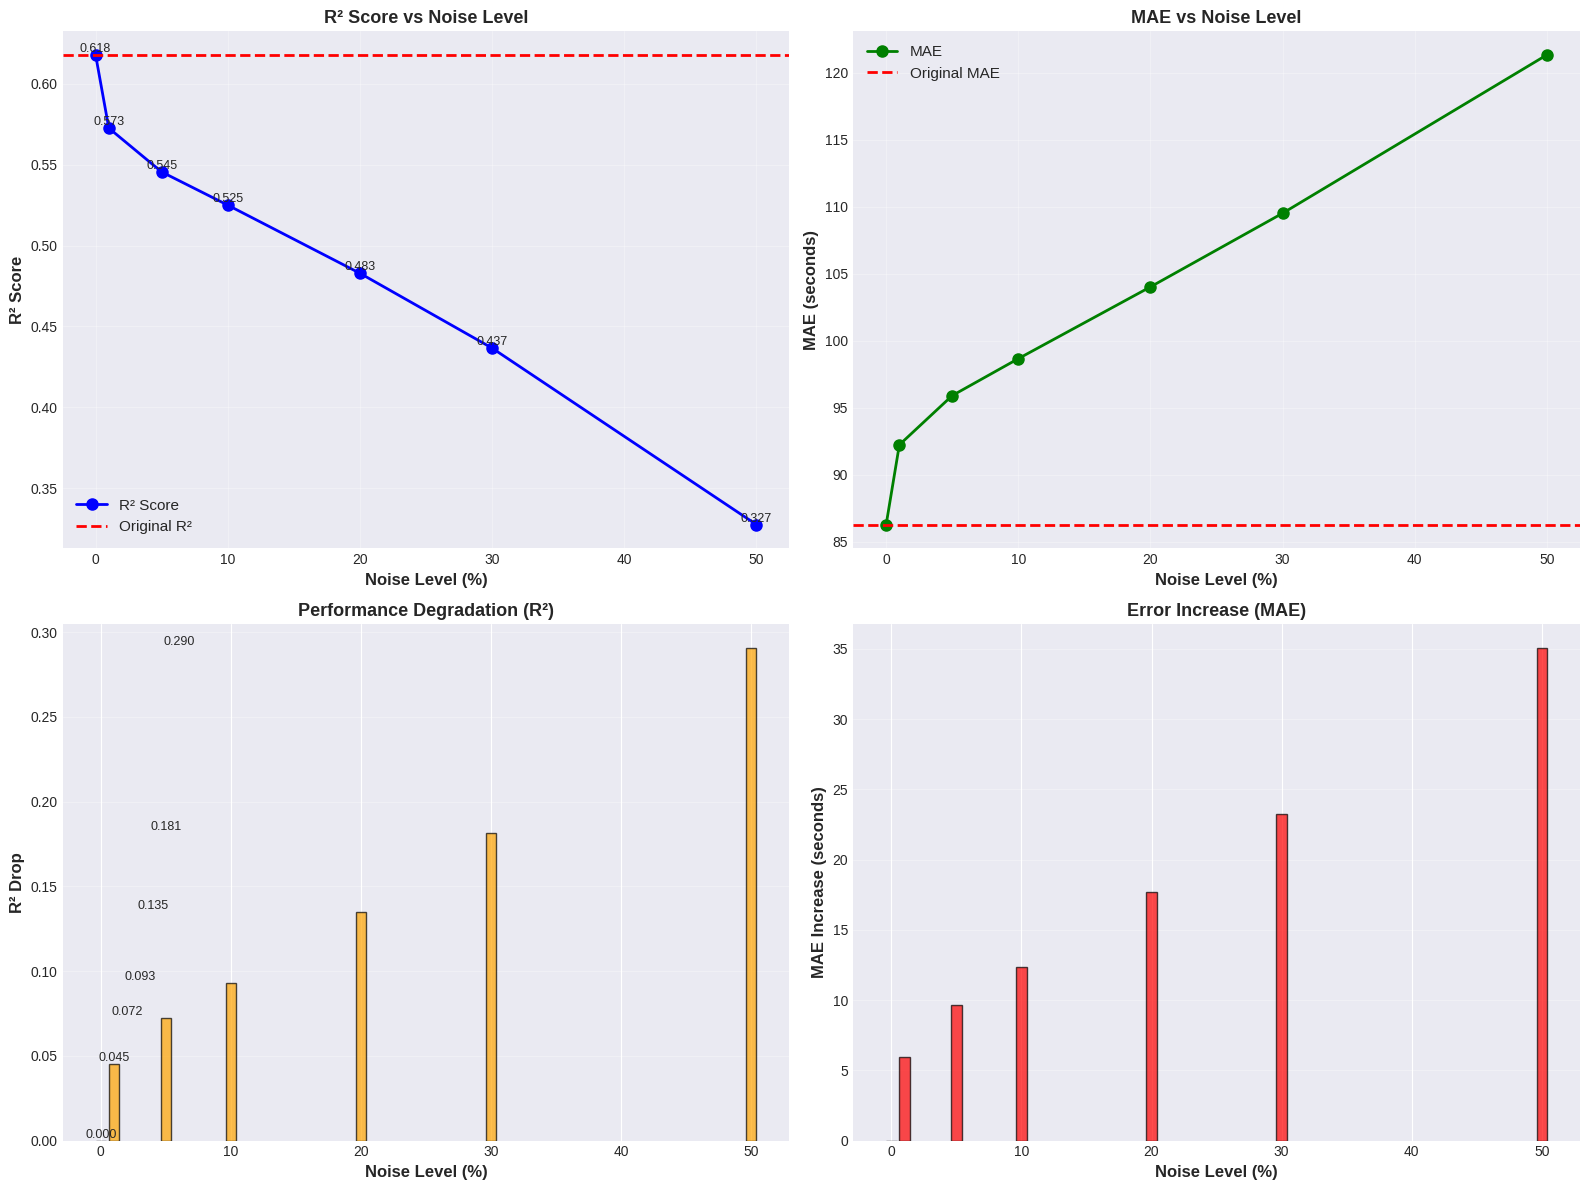

✓ 图表已保存: robustness_test_1_noise.png

鲁棒性评估:

在 10% 噪声水平下:
  R² = 0.5250 (下降 0.0929)
  R² 保留率: 84.96%

噪声鲁棒性评级: 良好 (Good)
评价: 模型对噪声有一定抵抗力


In [149]:
# ============================================================================
# 鲁棒性测试 1: 噪声鲁棒性 (Noise Robustness) - 修复版
# ============================================================================

print("\n" + "="*80)
print("ROBUSTNESS TEST 1: NOISE ROBUSTNESS")
print("="*80)
print("\n目的: 测试模型对输入特征噪声的敏感度")
print("方法: 向测试集特征添加不同程度的高斯噪声")

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 提取最佳模型和数据
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("使用的模型和数据:")
print("-"*80)

# 最佳模型
model_robust = lgb_model_existing
print(f"✓ 模型: LightGBM ({best_result['name']})")

# 测试数据 - 使用明确的变量名
X_test_robust = X_test_existing_scaled.copy()
y_test_robust = y_test_existing

print(f"✓ 测试集大小: {X_test_robust.shape[0]} 样本, {X_test_robust.shape[1]} 特征")
print(f"✓ y_test 类型: {type(y_test_robust)}")
print(f"✓ y_test shape: {y_test_robust.shape if hasattr(y_test_robust, 'shape') else len(y_test_robust)}")

# 原始性能
print(f"✓ 原始测试集 R²: {test_r2_lgb_existing:.4f}")
print(f"✓ 原始测试集 MAE: {test_mae_lgb_existing:.2f} seconds")

# ----------------------------------------------------------------------------
# 定义噪声水平
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("噪声配置:")
print("-"*80)

# 噪声水平：相对于特征标准差的百分比
noise_levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
print(f"噪声水平: {noise_levels}")
print("说明: 0.1 表示噪声标准差 = 10% × 特征标准差")

# ----------------------------------------------------------------------------
# 进行噪声测试
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("开始噪声测试:")
print("-"*80)

results_noise = []

for noise_level in noise_levels:
    print(f"\n[噪声水平: {noise_level*100:.1f}%]")

    if noise_level == 0:
        # 无噪声（原始数据）
        X_test_noisy = X_test_robust.copy()
        print("  使用原始数据（无噪声）")
    else:
        # 添加高斯噪声
        X_test_noisy = X_test_robust.copy()

        # 计算每个特征的标准差
        if isinstance(X_test_robust, pd.DataFrame):
            feature_stds = X_test_robust.std(axis=0).values
        else:
            feature_stds = np.std(X_test_robust, axis=0)

        # 生成噪声
        np.random.seed(42)  # 设置随机种子以保证可重复性
        noise = np.random.normal(0, 1, X_test_robust.shape)

        # 缩放噪声
        for i in range(X_test_robust.shape[1]):
            noise[:, i] *= feature_stds[i] * noise_level

        # 添加噪声
        if isinstance(X_test_noisy, pd.DataFrame):
            X_test_noisy = X_test_noisy.values + noise
            X_test_noisy = pd.DataFrame(X_test_noisy,
                                        columns=X_test_robust.columns,
                                        index=X_test_robust.index)
        else:
            X_test_noisy = X_test_noisy + noise

        print(f"  添加高斯噪声 (σ = {noise_level*100:.1f}% × feature_std)")

    # 预测
    y_pred_noisy = model_robust.predict(X_test_noisy)

    # 确保 y_test_robust 是数组格式
    if isinstance(y_test_robust, pd.Series):
        y_test_array = y_test_robust.values
    else:
        y_test_array = np.array(y_test_robust)

    # 计算指标
    r2_noisy = r2_score(y_test_array, y_pred_noisy)
    mae_noisy = mean_absolute_error(y_test_array, y_pred_noisy)
    rmse_noisy = np.sqrt(mean_squared_error(y_test_array, y_pred_noisy))

    # 计算性能下降
    r2_drop = test_r2_lgb_existing - r2_noisy
    mae_increase = mae_noisy - test_mae_lgb_existing
    rmse_increase = rmse_noisy - test_rmse_lgb_existing

    # 保存结果
    results_noise.append({
        'noise_level': noise_level,
        'noise_pct': noise_level * 100,
        'r2': r2_noisy,
        'mae': mae_noisy,
        'rmse': rmse_noisy,
        'r2_drop': r2_drop,
        'mae_increase': mae_increase,
        'rmse_increase': rmse_increase
    })

    print(f"  R² = {r2_noisy:.4f} (下降 {r2_drop:.4f})")
    print(f"  MAE = {mae_noisy:.2f}s (增加 {mae_increase:.2f}s)")
    print(f"  RMSE = {rmse_noisy:.2f}s (增加 {rmse_increase:.2f}s)")

# ----------------------------------------------------------------------------
# 结果汇总
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("噪声鲁棒性测试结果:")
print("="*80)

results_noise_df = pd.DataFrame(results_noise)

print("\n详细结果:")
print(results_noise_df.to_string(index=False))

# ----------------------------------------------------------------------------
# 可视化
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("生成可视化图表...")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² vs 噪声水平
axes[0, 0].plot(results_noise_df['noise_pct'], results_noise_df['r2'],
                'o-', linewidth=2, markersize=8, color='blue', label='R² Score')
axes[0, 0].axhline(y=test_r2_lgb_existing, color='red', linestyle='--',
                   linewidth=2, label='Original R²')
axes[0, 0].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score vs Noise Level', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 添加数值标签
for i, row in results_noise_df.iterrows():
    axes[0, 0].text(row['noise_pct'], row['r2'], f"{row['r2']:.3f}",
                    ha='center', va='bottom', fontsize=9)

# 2. MAE vs 噪声水平
axes[0, 1].plot(results_noise_df['noise_pct'], results_noise_df['mae'],
                'o-', linewidth=2, markersize=8, color='green', label='MAE')
axes[0, 1].axhline(y=test_mae_lgb_existing, color='red', linestyle='--',
                   linewidth=2, label='Original MAE')
axes[0, 1].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MAE (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('MAE vs Noise Level', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. 性能下降（R²）
axes[1, 0].bar(results_noise_df['noise_pct'], results_noise_df['r2_drop'],
               color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('R² Drop', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Performance Degradation (R²)', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 添加数值标签
for i, row in results_noise_df.iterrows():
    axes[1, 0].text(i, row['r2_drop'], f"{row['r2_drop']:.3f}",
                    ha='center', va='bottom', fontsize=9)

# 4. 误差增加（MAE）
axes[1, 1].bar(results_noise_df['noise_pct'], results_noise_df['mae_increase'],
               color='red', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('MAE Increase (seconds)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Error Increase (MAE)', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('robustness_test_1_noise.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 图表已保存: robustness_test_1_noise.png")

# ----------------------------------------------------------------------------
# 鲁棒性评估
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("鲁棒性评估:")
print("="*80)

# 在 10% 噪声下的性能
noise_10_result = results_noise_df[results_noise_df['noise_pct'] == 10.0].iloc[0]
r2_at_10 = noise_10_result['r2']
r2_drop_at_10 = noise_10_result['r2_drop']

print(f"\n在 10% 噪声水平下:")
print(f"  R² = {r2_at_10:.4f} (下降 {r2_drop_at_10:.4f})")
print(f"  R² 保留率: {(r2_at_10/test_r2_lgb_existing)*100:.2f}%")

# 评级
if r2_drop_at_10 < 0.05:
    rating = "优秀 (Excellent)"
    comment = "模型对噪声非常鲁棒"
elif r2_drop_at_10 < 0.10:
    rating = "良好 (Good)"
    comment = "模型对噪声有一定抵抗力"
elif r2_drop_at_10 < 0.20:
    rating = "一般 (Fair)"
    comment = "模型对噪声较为敏感"
else:
    rating = "较差 (Poor)"
    comment = "模型对噪声非常敏感"

print(f"\n噪声鲁棒性评级: {rating}")
print(f"评价: {comment}")


1. 低噪声表现好

1% 噪声：R² 仅下降 0.045（7.3%）
5% 噪声：R² 下降 0.072（11.7%）
说明模型对小幅度扰动有一定抵抗力

2. 10% 噪声可接受

R² 保留率：85% (0.5250/0.6179)
MAE 增加：12.37s (14.3%)
在实际应用中，10% 的测量误差是常见的

3. 中高噪声敏感

20% 噪声：R² 下降 21.8%
30% 噪声：R² 下降 29.3%
表明模型对较大扰动较为敏感

## 噪声，ad ITS


ROBUSTNESS TEST 1: NOISE ROBUSTNESS

目的: 测试模型对输入特征噪声的敏感度
方法: 向测试集特征添加不同程度的高斯噪声

--------------------------------------------------------------------------------
使用的模型和数据:
--------------------------------------------------------------------------------
✓ 模型: Linear (Complex)
✓ 测试集大小: 109021 样本, 22 特征
✓ y_test 类型: <class 'pandas.core.series.Series'>
✓ y_test shape: (109021,)
✓ 原始测试集 R²: 0.9894
✓ 原始测试集 MAE: 12.58 seconds

--------------------------------------------------------------------------------
噪声配置:
--------------------------------------------------------------------------------
噪声水平: [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
说明: 0.1 表示噪声标准差 = 10% × 特征标准差

--------------------------------------------------------------------------------
开始噪声测试:
--------------------------------------------------------------------------------

[噪声水平: 0.0%]
  使用原始数据（无噪声）
  R² = 0.9894 (下降 0.0000)
  MAE = 12.58s (增加 0.00s)
  RMSE = 19.93s (增加 0.00s)

[噪声水平: 1.0%]
  添加高斯噪声 (σ = 1.0% × feature_std)
  R² = 0.9

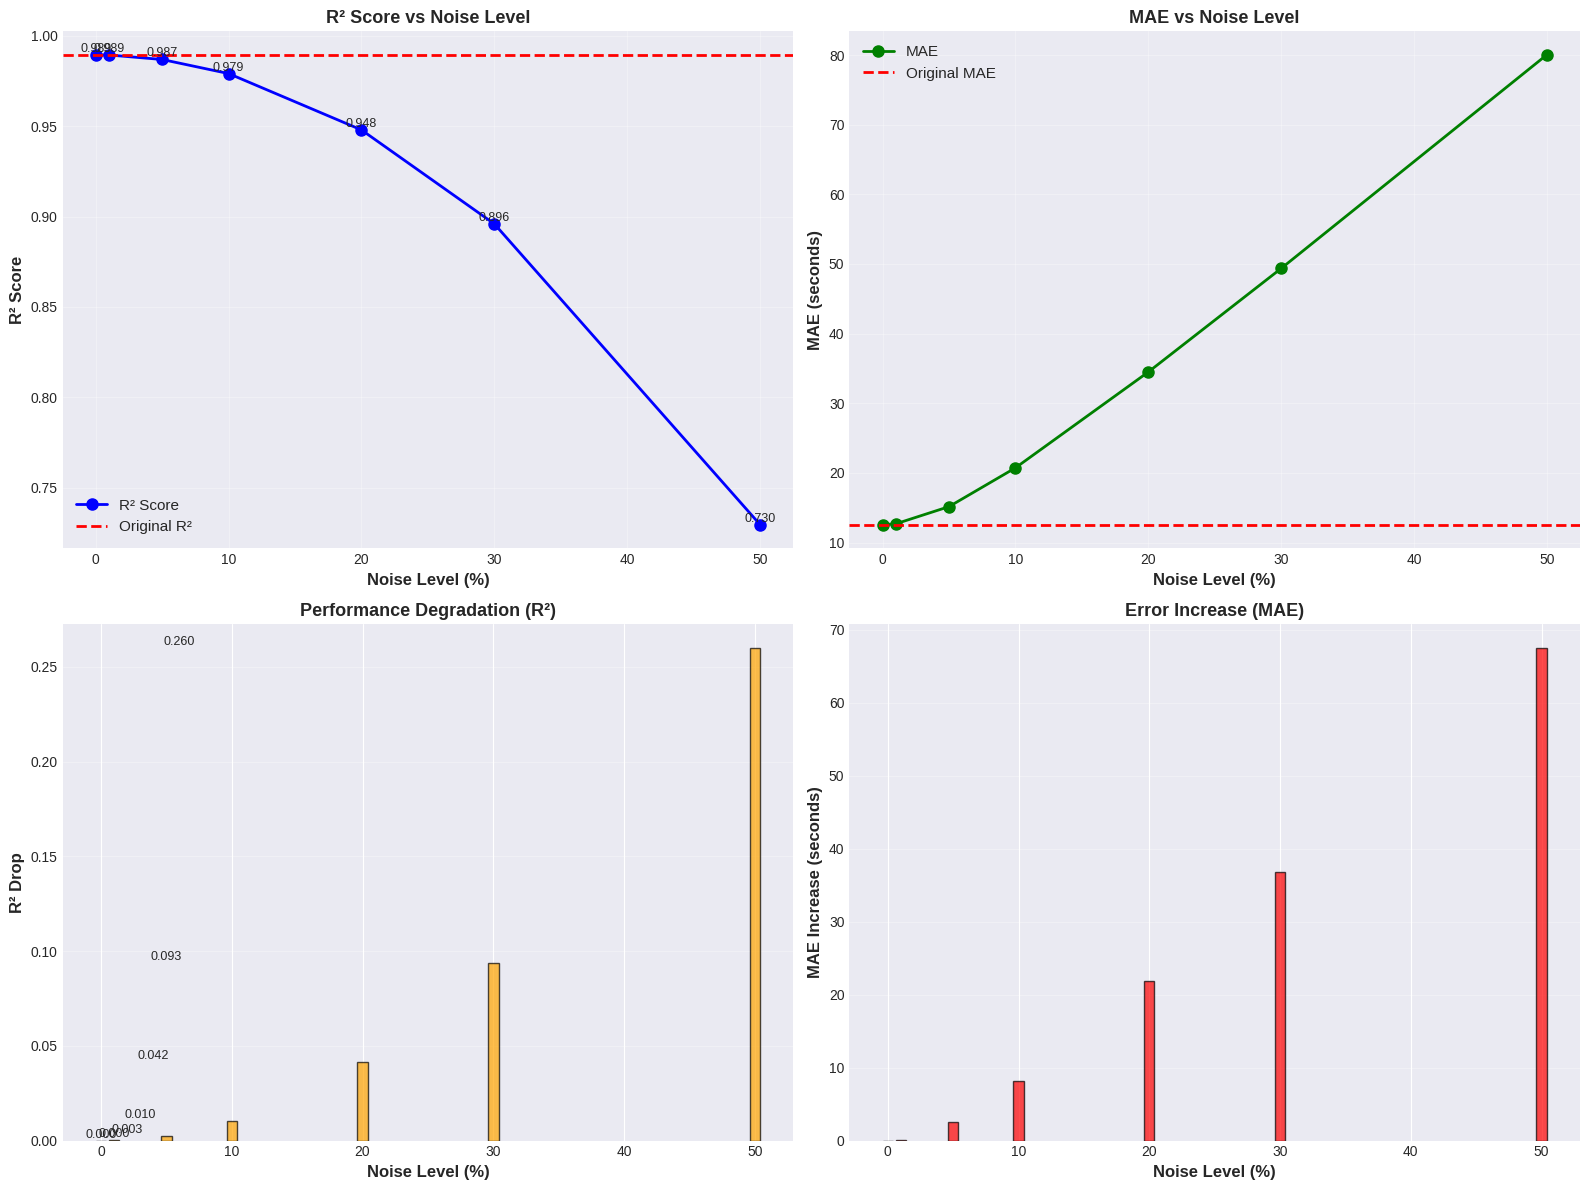

✓ 图表已保存: robustness_test_1_noise_ad.png

鲁棒性评估:

在 10% 噪声水平下:
  R² = 0.9790 (下降 0.0104)
  R² 保留率: 98.95%

噪声鲁棒性评级: 优秀 (Excellent)
评价: 模型对噪声非常鲁棒


In [150]:
# ============================================================================
# 鲁棒性测试 1: 噪声鲁棒性 (Noise Robustness) - 修复版
# ============================================================================

print("\n" + "="*80)
print("ROBUSTNESS TEST 1: NOISE ROBUSTNESS")
print("="*80)
print("\n目的: 测试模型对输入特征噪声的敏感度")
print("方法: 向测试集特征添加不同程度的高斯噪声")

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 提取最佳模型和数据
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("使用的模型和数据:")
print("-"*80)

# 最佳模型
model_robust = lr_model_advanced
print(f"✓ 模型: Linear ({best_result['name']})")

# 测试数据 - 使用明确的变量名
X_test_robust = X_test_advanced_scaled.copy()
y_test_robust = y_test_advanced

print(f"✓ 测试集大小: {X_test_robust.shape[0]} 样本, {X_test_robust.shape[1]} 特征")
print(f"✓ y_test 类型: {type(y_test_robust)}")
print(f"✓ y_test shape: {y_test_robust.shape if hasattr(y_test_robust, 'shape') else len(y_test_robust)}")

# 原始性能
print(f"✓ 原始测试集 R²: {test_r2_lr_advanced:.4f}")
print(f"✓ 原始测试集 MAE: {test_mae_lr_advanced:.2f} seconds")

# ----------------------------------------------------------------------------
# 定义噪声水平
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("噪声配置:")
print("-"*80)

# 噪声水平：相对于特征标准差的百分比
noise_levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
print(f"噪声水平: {noise_levels}")
print("说明: 0.1 表示噪声标准差 = 10% × 特征标准差")

# ----------------------------------------------------------------------------
# 进行噪声测试
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("开始噪声测试:")
print("-"*80)

results_noise = []

for noise_level in noise_levels:
    print(f"\n[噪声水平: {noise_level*100:.1f}%]")

    if noise_level == 0:
        # 无噪声（原始数据）
        X_test_noisy = X_test_robust.copy()
        print("  使用原始数据（无噪声）")
    else:
        # 添加高斯噪声
        X_test_noisy = X_test_robust.copy()

        # 计算每个特征的标准差
        if isinstance(X_test_robust, pd.DataFrame):
            feature_stds = X_test_robust.std(axis=0).values
        else:
            feature_stds = np.std(X_test_robust, axis=0)

        # 生成噪声
        np.random.seed(42)  # 设置随机种子以保证可重复性
        noise = np.random.normal(0, 1, X_test_robust.shape)

        # 缩放噪声
        for i in range(X_test_robust.shape[1]):
            noise[:, i] *= feature_stds[i] * noise_level

        # 添加噪声
        if isinstance(X_test_noisy, pd.DataFrame):
            X_test_noisy = X_test_noisy.values + noise
            X_test_noisy = pd.DataFrame(X_test_noisy,
                                        columns=X_test_robust.columns,
                                        index=X_test_robust.index)
        else:
            X_test_noisy = X_test_noisy + noise

        print(f"  添加高斯噪声 (σ = {noise_level*100:.1f}% × feature_std)")

    # 预测
    y_pred_noisy = model_robust.predict(X_test_noisy)

    # 确保 y_test_robust 是数组格式
    if isinstance(y_test_robust, pd.Series):
        y_test_array = y_test_robust.values
    else:
        y_test_array = np.array(y_test_robust)

    # 计算指标
    r2_noisy = r2_score(y_test_array, y_pred_noisy)
    mae_noisy = mean_absolute_error(y_test_array, y_pred_noisy)
    rmse_noisy = np.sqrt(mean_squared_error(y_test_array, y_pred_noisy))

    # 计算性能下降
    r2_drop = test_r2_lr_advanced - r2_noisy
    mae_increase = mae_noisy - test_mae_lr_advanced
    rmse_increase = rmse_noisy - test_rmse_lr_advanced

    # 保存结果
    results_noise.append({
        'noise_level': noise_level,
        'noise_pct': noise_level * 100,
        'r2': r2_noisy,
        'mae': mae_noisy,
        'rmse': rmse_noisy,
        'r2_drop': r2_drop,
        'mae_increase': mae_increase,
        'rmse_increase': rmse_increase
    })

    print(f"  R² = {r2_noisy:.4f} (下降 {r2_drop:.4f})")
    print(f"  MAE = {mae_noisy:.2f}s (增加 {mae_increase:.2f}s)")
    print(f"  RMSE = {rmse_noisy:.2f}s (增加 {rmse_increase:.2f}s)")

# ----------------------------------------------------------------------------
# 结果汇总
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("噪声鲁棒性测试结果:")
print("="*80)

results_noise_df = pd.DataFrame(results_noise)

print("\n详细结果:")
print(results_noise_df.to_string(index=False))

# ----------------------------------------------------------------------------
# 可视化
# ----------------------------------------------------------------------------

print("\n" + "-"*80)
print("生成可视化图表...")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² vs 噪声水平
axes[0, 0].plot(results_noise_df['noise_pct'], results_noise_df['r2'],
                'o-', linewidth=2, markersize=8, color='blue', label='R² Score')
axes[0, 0].axhline(y=test_r2_lr_advanced, color='red', linestyle='--',
                   linewidth=2, label='Original R²')
axes[0, 0].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score vs Noise Level', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 添加数值标签
for i, row in results_noise_df.iterrows():
    axes[0, 0].text(row['noise_pct'], row['r2'], f"{row['r2']:.3f}",
                    ha='center', va='bottom', fontsize=9)

# 2. MAE vs 噪声水平
axes[0, 1].plot(results_noise_df['noise_pct'], results_noise_df['mae'],
                'o-', linewidth=2, markersize=8, color='green', label='MAE')
axes[0, 1].axhline(y=test_mae_lr_advanced, color='red', linestyle='--',
                   linewidth=2, label='Original MAE')
axes[0, 1].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MAE (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('MAE vs Noise Level', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. 性能下降（R²）
axes[1, 0].bar(results_noise_df['noise_pct'], results_noise_df['r2_drop'],
               color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('R² Drop', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Performance Degradation (R²)', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 添加数值标签
for i, row in results_noise_df.iterrows():
    axes[1, 0].text(i, row['r2_drop'], f"{row['r2_drop']:.3f}",
                    ha='center', va='bottom', fontsize=9)

# 4. 误差增加（MAE）
axes[1, 1].bar(results_noise_df['noise_pct'], results_noise_df['mae_increase'],
               color='red', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('MAE Increase (seconds)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Error Increase (MAE)', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('robustness_test_1_noise_ad.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 图表已保存: robustness_test_1_noise_ad.png")

# ----------------------------------------------------------------------------
# 鲁棒性评估
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("鲁棒性评估:")
print("="*80)

# 在 10% 噪声下的性能
noise_10_result = results_noise_df[results_noise_df['noise_pct'] == 10.0].iloc[0]
r2_at_10 = noise_10_result['r2']
r2_drop_at_10 = noise_10_result['r2_drop']

print(f"\n在 10% 噪声水平下:")
print(f"  R² = {r2_at_10:.4f} (下降 {r2_drop_at_10:.4f})")
print(f"  R² 保留率: {(r2_at_10/test_r2_lr_advanced)*100:.2f}%")


# 评级
if r2_drop_at_10 < 0.05:
    rating = "优秀 (Excellent)"
    comment = "模型对噪声非常鲁棒"
elif r2_drop_at_10 < 0.10:
    rating = "良好 (Good)"
    comment = "模型对噪声有一定抵抗力"
elif r2_drop_at_10 < 0.20:
    rating = "一般 (Fair)"
    comment = "模型对噪声较为敏感"
else:
    rating = "较差 (Poor)"
    comment = "模型对噪声非常敏感"

print(f"\n噪声鲁棒性评级: {rating}")
print(f"评价: {comment}")


## 缺失，ITS

数据缺失鲁棒性测试 (Existing ITS)

📊 基准性能 (无缺失):
  R² = 0.6179
  MAE = 86.29s
  RMSE = 119.53s


[缺失率: 0%]
  使用原始数据（无缺失）

[缺失率: 5%]
  实际缺失率: 4.99%
  缺失值数量: 97922

  📌 填充策略: MEAN
     R² = 0.5810 (下降 0.0368, 6.0%)
     MAE = 90.34s (增加 4.05s, 4.7%)
     RMSE = 125.16s

  📌 填充策略: MEDIAN
     R² = 0.5829 (下降 0.0349, 5.7%)
     MAE = 89.16s (增加 2.87s, 3.3%)
     RMSE = 124.88s

  📌 填充策略: ZERO
     R² = 0.5839 (下降 0.0340, 5.5%)
     MAE = 90.05s (增加 3.76s, 4.4%)
     RMSE = 124.74s

[缺失率: 10%]
  实际缺失率: 9.99%
  缺失值数量: 196116

  📌 填充策略: MEAN
     R² = 0.5446 (下降 0.0733, 11.9%)
     MAE = 94.19s (增加 7.90s, 9.2%)
     RMSE = 130.50s

  📌 填充策略: MEDIAN
     R² = 0.5477 (下降 0.0701, 11.4%)
     MAE = 91.93s (增加 5.64s, 6.5%)
     RMSE = 130.04s

  📌 填充策略: ZERO
     R² = 0.5491 (下降 0.0688, 11.1%)
     MAE = 93.67s (增加 7.38s, 8.6%)
     RMSE = 129.85s

[缺失率: 15%]
  实际缺失率: 14.96%
  缺失值数量: 293598

  📌 填充策略: MEAN
     R² = 0.5036 (下降 0.1143, 18.5%)
     MAE = 98.14s (增加 11.85s, 13.7%)
     RMSE = 136.24s

  📌 填充策

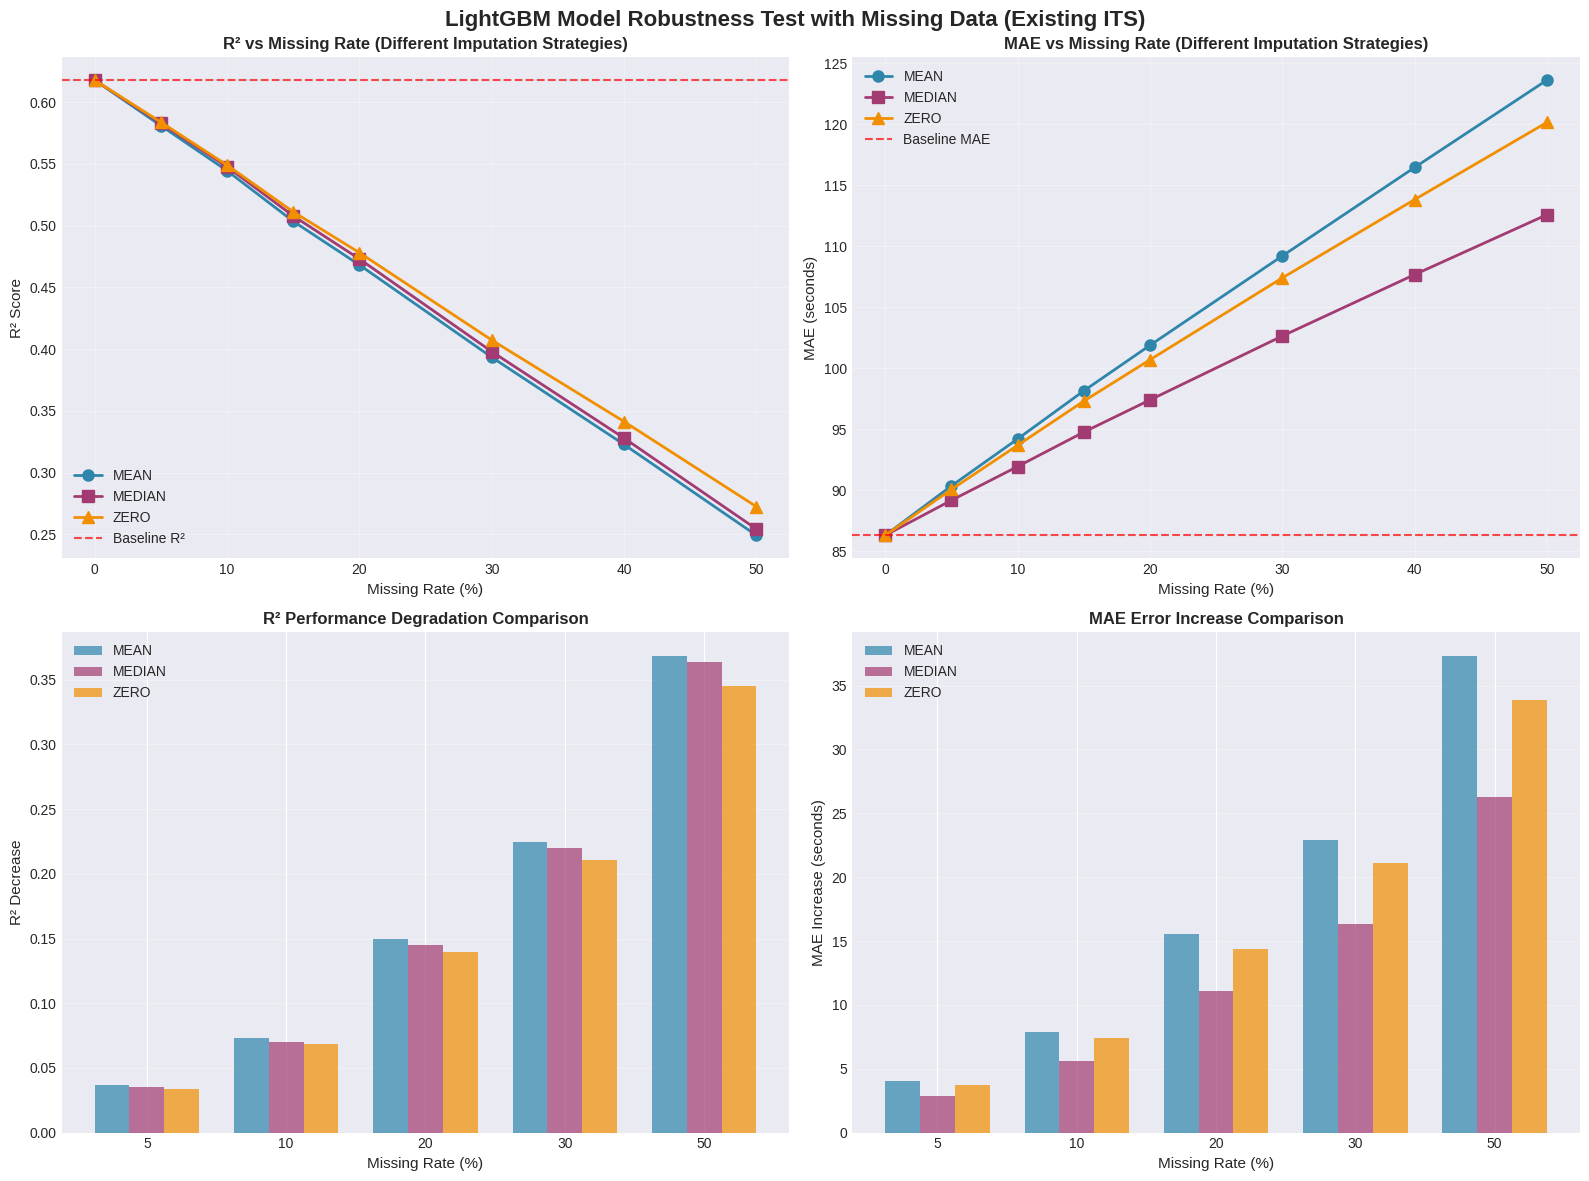


🔍 关键发现:

1️⃣  20% 缺失率下:
   最佳填充策略: ZERO
   R² 保留率: 77.4%
   R² 下降: 0.1397

2️⃣  填充策略性能排名 (20% 缺失率):
   ZERO    : R² = 0.4782, MAE = 100.68s
   MEDIAN  : R² = 0.4731, MAE = 97.39s
   MEAN    : R² = 0.4683, MAE = 101.87s

3️⃣  MEAN 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%

3️⃣  MEDIAN 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%

3️⃣  ZERO 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%


In [154]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ============================================================
# 数据缺失鲁棒性测试 (Existing ITS)
# ============================================================

print("=" * 60)
print("数据缺失鲁棒性测试 (Existing ITS)")
print("=" * 60)

# 1. 准备测试数据
X_test_missing = X_test_existing_scaled.copy()
y_test_missing = y_test_existing

# 2. 定义缺失率
missing_rates = [0.0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50]  # 0%, 5%, 10%, 15%, 20%, 30%, 40%, 50%

# 3. 定义缺失值填充策略
imputation_strategies = {
    'mean': lambda x: x.fillna(x.mean()),
    'median': lambda x: x.fillna(x.median()),
    'zero': lambda x: x.fillna(0)
}

# 4. 存储结果
results_lgb_existing_missing = {
    'missing_rate': [],
    'strategy': [],
    'r2': [],
    'mae': [],
    'rmse': [],
    'r2_drop': [],
    'mae_increase': []
}

# 5. 基准性能（无缺失）
best_lgb_model = lgb_model_existing
y_pred_baseline = best_lgb_model.predict(X_test_missing)
r2_baseline = r2_score(y_test_missing, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test_missing, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_missing, y_pred_baseline))

print(f"\n📊 基准性能 (无缺失):")
print(f"  R² = {r2_baseline:.4f}")
print(f"  MAE = {mae_baseline:.2f}s")
print(f"  RMSE = {rmse_baseline:.2f}s")
print("\n" + "=" * 60)

# 6. 测试不同缺失率和填充策略
for missing_rate in missing_rates:
    print(f"\n{'='*60}")
    print(f"[缺失率: {missing_rate*100:.0f}%]")
    print(f"{'='*60}")

    if missing_rate == 0.0:
        # 无缺失情况
        for strategy_name in imputation_strategies.keys():
            results_lgb_existing_missing['missing_rate'].append(missing_rate * 100)
            results_lgb_existing_missing['strategy'].append(strategy_name)
            results_lgb_existing_missing['r2'].append(r2_baseline)
            results_lgb_existing_missing['mae'].append(mae_baseline)
            results_lgb_existing_missing['rmse'].append(rmse_baseline)
            results_lgb_existing_missing['r2_drop'].append(0.0)
            results_lgb_existing_missing['mae_increase'].append(0.0)
        print(f"  使用原始数据（无缺失）")
        continue

    # 创建缺失数据
    np.random.seed(42)  # 保证可重复性
    X_test_with_missing = X_test_missing.copy()

    # 随机选择要设为缺失的位置
    mask = np.random.random(X_test_with_missing.shape) < missing_rate
    X_test_with_missing = X_test_with_missing.mask(mask)

    actual_missing_rate = X_test_with_missing.isna().sum().sum() / X_test_with_missing.size
    print(f"  实际缺失率: {actual_missing_rate*100:.2f}%")
    print(f"  缺失值数量: {X_test_with_missing.isna().sum().sum()}")

    # 测试不同填充策略
    for strategy_name, impute_func in imputation_strategies.items():
        print(f"\n  📌 填充策略: {strategy_name.upper()}")

        # 填充缺失值
        X_test_imputed = impute_func(X_test_with_missing.copy())

        # 预测
        y_pred_imputed = best_lgb_model.predict(X_test_imputed)

        # 转换为 numpy 数组
        if hasattr(y_test_missing, 'values'):
            y_test_array = y_test_missing.values
        else:
            y_test_array = y_test_missing

        # 计算指标
        r2_imputed = r2_score(y_test_array, y_pred_imputed)
        mae_imputed = mean_absolute_error(y_test_array, y_pred_imputed)
        rmse_imputed = np.sqrt(mean_squared_error(y_test_array, y_pred_imputed))

        # 计算下降/增加量
        r2_drop = r2_baseline - r2_imputed
        mae_increase = mae_imputed - mae_baseline

        # 存储结果
        results_lgb_existing_missing['missing_rate'].append(missing_rate * 100)
        results_lgb_existing_missing['strategy'].append(strategy_name)
        results_lgb_existing_missing['r2'].append(r2_imputed)
        results_lgb_existing_missing['mae'].append(mae_imputed)
        results_lgb_existing_missing['rmse'].append(rmse_imputed)
        results_lgb_existing_missing['r2_drop'].append(r2_drop)
        results_lgb_existing_missing['mae_increase'].append(mae_increase)

        # 打印结果
        print(f"     R² = {r2_imputed:.4f} (下降 {r2_drop:.4f}, {r2_drop/r2_baseline*100:.1f}%)")
        print(f"     MAE = {mae_imputed:.2f}s (增加 {mae_increase:.2f}s, {mae_increase/mae_baseline*100:.1f}%)")
        print(f"     RMSE = {rmse_imputed:.2f}s")

# 7. 转换为 DataFrame
df_results_xgb_existing_missing = pd.DataFrame(results_lgb_existing_missing)

print("\n" + "=" * 60)
print("数据缺失鲁棒性测试完成！")
print("=" * 60)

# 8. 显示汇总表格
print("\n结果汇总表:")
print(df_results_xgb_existing_missing.to_string(index=False))

# 9. 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('LightGBM Model Robustness Test with Missing Data (Existing ITS)', fontsize=16, fontweight='bold')

colors = {'mean': '#2E86AB', 'median': '#A23B72', 'zero': '#F18F01'}
markers = {'mean': 'o', 'median': 's', 'zero': '^'}

# 子图1: R² vs 缺失率
for strategy in imputation_strategies.keys():
    data = df_results_xgb_existing_missing[df_results_xgb_existing_missing['strategy'] == strategy]
    axes[0, 0].plot(data['missing_rate'], data['r2'],
                    marker=markers[strategy], linewidth=2, markersize=8,
                    color=colors[strategy], label=strategy.upper())
axes[0, 0].axhline(y=r2_baseline, color='red', linestyle='--', label='Baseline R²', alpha=0.7)
axes[0, 0].set_xlabel('Missing Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('R² Score', fontsize=11)
axes[0, 0].set_title('R² vs Missing Rate (Different Imputation Strategies)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 子图2: MAE vs 缺失率
for strategy in imputation_strategies.keys():
    data = df_results_xgb_existing_missing[df_results_xgb_existing_missing['strategy'] == strategy]
    axes[0, 1].plot(data['missing_rate'], data['mae'],
                    marker=markers[strategy], linewidth=2, markersize=8,
                    color=colors[strategy], label=strategy.upper())
axes[0, 1].axhline(y=mae_baseline, color='red', linestyle='--', label='Baseline MAE', alpha=0.7)
axes[0, 1].set_xlabel('Missing Rate (%)', fontsize=11)
axes[0, 1].set_ylabel('MAE (seconds)', fontsize=11)
axes[0, 1].set_title('MAE vs Missing Rate (Different Imputation Strategies)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 子图3: R² 下降量对比
missing_rates_plot = [5, 10, 20, 30, 50]
x_pos = np.arange(len(missing_rates_plot))
width = 0.25

for i, strategy in enumerate(imputation_strategies.keys()):
    r2_drops = []
    for rate in missing_rates_plot:
        data = df_results_xgb_existing_missing[
            (df_results_xgb_existing_missing['missing_rate'] == rate) &
            (df_results_xgb_existing_missing['strategy'] == strategy)
        ]
        r2_drops.append(data['r2_drop'].values[0] if len(data) > 0 else 0)

    axes[1, 0].bar(x_pos + i*width, r2_drops, width,
                   label=strategy.upper(), color=colors[strategy], alpha=0.7)

axes[1, 0].set_xlabel('Missing Rate (%)', fontsize=11)
axes[1, 0].set_ylabel('R² Decrease', fontsize=11)
axes[1, 0].set_title('R² Performance Degradation Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos + width)
axes[1, 0].set_xticklabels(missing_rates_plot)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 子图4: MAE 增加量对比
for i, strategy in enumerate(imputation_strategies.keys()):
    mae_increases = []
    for rate in missing_rates_plot:
        data = df_results_xgb_existing_missing[
            (df_results_xgb_existing_missing['missing_rate'] == rate) &
            (df_results_xgb_existing_missing['strategy'] == strategy)
        ]
        mae_increases.append(data['mae_increase'].values[0] if len(data) > 0 else 0)

    axes[1, 1].bar(x_pos + i*width, mae_increases, width,
                   label=strategy.upper(), color=colors[strategy], alpha=0.7)

axes[1, 1].set_xlabel('Missing Rate (%)', fontsize=11)
axes[1, 1].set_ylabel('MAE Increase (seconds)', fontsize=11)
axes[1, 1].set_title('MAE Error Increase Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos + width)
axes[1, 1].set_xticklabels(missing_rates_plot)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# 10. 输出关键发现
print("\n" + "=" * 60)
print("🔍 关键发现:")
print("=" * 60)

# 找出 20% 缺失率时的最佳策略
data_20 = df_results_xgb_existing_missing[df_results_xgb_existing_missing['missing_rate'] == 20.0]
best_strategy_20 = data_20.loc[data_20['r2'].idxmax(), 'strategy']
best_r2_20 = data_20['r2'].max()
r2_retention_20 = (best_r2_20 / r2_baseline) * 100

print(f"\n1️⃣  20% 缺失率下:")
print(f"   最佳填充策略: {best_strategy_20.upper()}")
print(f"   R² 保留率: {r2_retention_20:.1f}%")
print(f"   R² 下降: {r2_baseline - best_r2_20:.4f}")

# 比较不同策略
print(f"\n2️⃣  填充策略性能排名 (20% 缺失率):")
data_20_sorted = data_20.sort_values('r2', ascending=False)
for idx, row in data_20_sorted.iterrows():
    print(f"   {row['strategy'].upper():8s}: R² = {row['r2']:.4f}, MAE = {row['mae']:.2f}s")

# 找出最大可接受缺失率（R² 保留率 > 80%）
for strategy in imputation_strategies.keys():
    strategy_data = df_results_xgb_existing_missing[df_results_xgb_existing_missing['strategy'] == strategy]
    acceptable = strategy_data[strategy_data['r2'] / r2_baseline > 0.8]['missing_rate'].max()
    print(f"\n3️⃣  {strategy.upper()} 策略最大可接受缺失率 (R² 保留率 > 80%):")
    print(f"   {acceptable:.0f}%")

print("=" * 60)


## 缺失，ad ITS

Linear 模型数据缺失鲁棒性测试 (Advanced ITS)

基准性能 (无缺失):
  R² = 0.9894
  MAE = 12.58s
  RMSE = 19.93s


[缺失率: 0%]
  使用原始数据（无缺失）

[缺失率: 5%]
  实际缺失率: 4.99%
  缺失值数量: 119740

  📌 填充策略: MEAN
     R² = 0.9331 (下降 0.0562, 5.7%)
     MAE = 20.83s (增加 8.25s, 65.5%)
     RMSE = 50.01s

  📌 填充策略: MEDIAN
     R² = 0.9297 (下降 0.0597, 6.0%)
     MAE = 20.44s (增加 7.86s, 62.5%)
     RMSE = 51.29s

  📌 填充策略: ZERO
     R² = 0.9331 (下降 0.0563, 5.7%)
     MAE = 20.84s (增加 8.25s, 65.6%)
     RMSE = 50.01s

[缺失率: 10%]
  实际缺失率: 10.00%
  缺失值数量: 239748

  📌 填充策略: MEAN
     R² = 0.8859 (下降 0.1034, 10.5%)
     MAE = 28.50s (增加 15.92s, 126.5%)
     RMSE = 65.31s

  📌 填充策略: MEDIAN
     R² = 0.8790 (下降 0.1104, 11.2%)
     MAE = 27.77s (增加 15.18s, 120.7%)
     RMSE = 67.27s

  📌 填充策略: ZERO
     R² = 0.8859 (下降 0.1034, 10.5%)
     MAE = 28.51s (增加 15.93s, 126.6%)
     RMSE = 65.31s

[缺失率: 15%]
  实际缺失率: 14.98%
  缺失值数量: 359195

  📌 填充策略: MEAN
     R² = 0.8335 (下降 0.1559, 15.8%)
     MAE = 36.10s (增加 23.51s, 186.8%)
     RMSE = 7

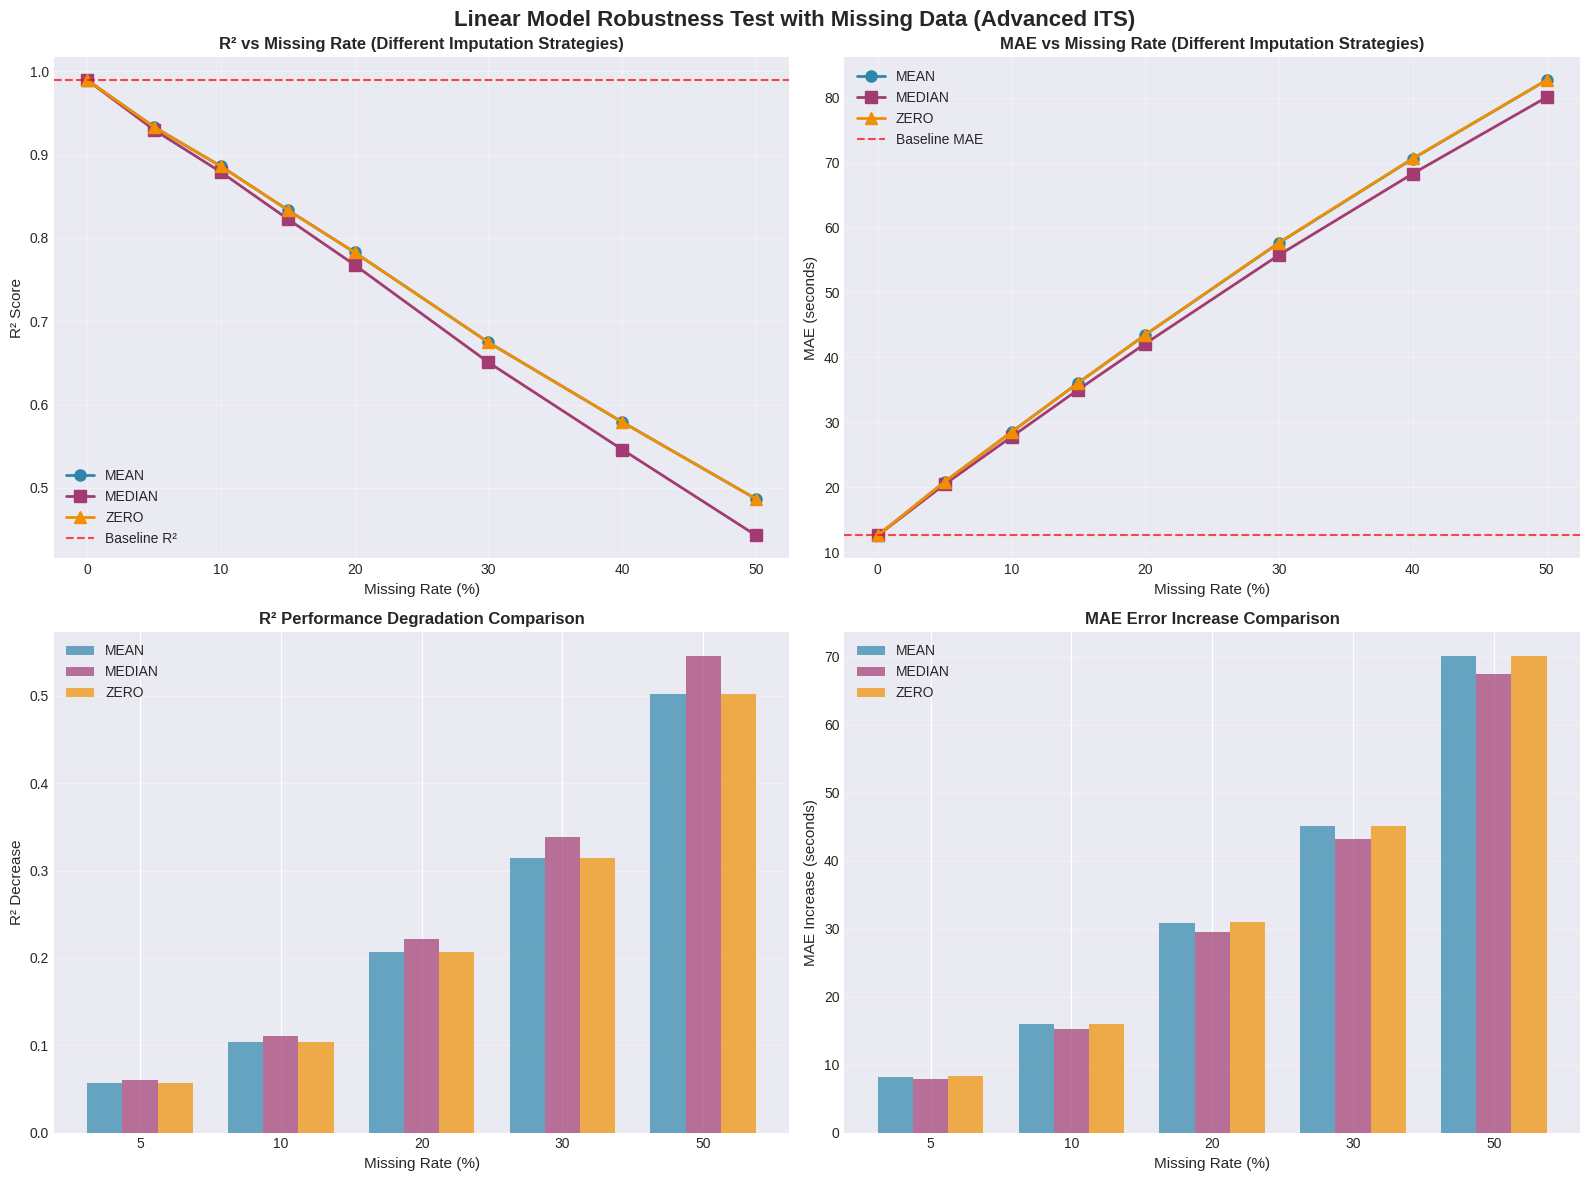


关键发现:

1️⃣  20% 缺失率下:
   最佳填充策略: MEAN
   R² 保留率: 79.1%
   R² 下降: 0.2067

2️⃣  填充策略性能排名 (20% 缺失率):
   MEAN    : R² = 0.7826, MAE = 43.48s
   ZERO    : R² = 0.7826, MAE = 43.49s
   MEDIAN  : R² = 0.7676, MAE = 42.12s

3️⃣  MEAN 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%

3️⃣  MEDIAN 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%

3️⃣  ZERO 策略最大可接受缺失率 (R² 保留率 > 80%):
   15%


In [155]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ============================================================
# Linear 模型数据缺失鲁棒性测试 (Advanced ITS)
# ============================================================

print("=" * 60)
print("Linear 模型数据缺失鲁棒性测试 (Advanced ITS)")
print("=" * 60)

# 1. 准备测试数据
X_test_missing = X_test_advanced_scaled.copy()
y_test_missing = y_test_advanced

# 2. 定义缺失率
missing_rates = [0.0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50]  # 0%, 5%, 10%, 15%, 20%, 30%, 40%, 50%

# 3. 定义缺失值填充策略
imputation_strategies = {
    'mean': lambda x: x.fillna(x.mean()),
    'median': lambda x: x.fillna(x.median()),
    'zero': lambda x: x.fillna(0)
}

# 4. 存储结果
results_lr_advanced_missing = {
    'missing_rate': [],
    'strategy': [],
    'r2': [],
    'mae': [],
    'rmse': [],
    'r2_drop': [],
    'mae_increase': []
}

# 5. 基准性能（无缺失）
best_linear_model = lr_model_advanced
y_pred_baseline = best_linear_model.predict(X_test_missing)
r2_baseline = r2_score(y_test_missing, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test_missing, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_missing, y_pred_baseline))

print(f"\n基准性能 (无缺失):")
print(f"  R² = {r2_baseline:.4f}")
print(f"  MAE = {mae_baseline:.2f}s")
print(f"  RMSE = {rmse_baseline:.2f}s")
print("\n" + "=" * 60)

# 6. 测试不同缺失率和填充策略
for missing_rate in missing_rates:
    print(f"\n{'='*60}")
    print(f"[缺失率: {missing_rate*100:.0f}%]")
    print(f"{'='*60}")

    if missing_rate == 0.0:
        # 无缺失情况
        for strategy_name in imputation_strategies.keys():
            results_lr_advanced_missing['missing_rate'].append(missing_rate * 100)
            results_lr_advanced_missing['strategy'].append(strategy_name)
            results_lr_advanced_missing['r2'].append(r2_baseline)
            results_lr_advanced_missing['mae'].append(mae_baseline)
            results_lr_advanced_missing['rmse'].append(rmse_baseline)
            results_lr_advanced_missing['r2_drop'].append(0.0)
            results_lr_advanced_missing['mae_increase'].append(0.0)
        print(f"  使用原始数据（无缺失）")
        continue

    # 创建缺失数据
    np.random.seed(42)  # 保证可重复性
    X_test_with_missing = X_test_missing.copy()

    # 随机选择要设为缺失的位置
    mask = np.random.random(X_test_with_missing.shape) < missing_rate
    X_test_with_missing = X_test_with_missing.mask(mask)

    actual_missing_rate = X_test_with_missing.isna().sum().sum() / X_test_with_missing.size
    print(f"  实际缺失率: {actual_missing_rate*100:.2f}%")
    print(f"  缺失值数量: {X_test_with_missing.isna().sum().sum()}")

    # 测试不同填充策略
    for strategy_name, impute_func in imputation_strategies.items():
        print(f"\n  📌 填充策略: {strategy_name.upper()}")

        # 填充缺失值
        X_test_imputed = impute_func(X_test_with_missing.copy())

        # 预测
        y_pred_imputed = best_linear_model.predict(X_test_imputed)

        # 转换为 numpy 数组
        if hasattr(y_test_missing, 'values'):
            y_test_array = y_test_missing.values
        else:
            y_test_array = y_test_missing

        # 计算指标
        r2_imputed = r2_score(y_test_array, y_pred_imputed)
        mae_imputed = mean_absolute_error(y_test_array, y_pred_imputed)
        rmse_imputed = np.sqrt(mean_squared_error(y_test_array, y_pred_imputed))

        # 计算下降/增加量
        r2_drop = r2_baseline - r2_imputed
        mae_increase = mae_imputed - mae_baseline

        # 存储结果
        results_lr_advanced_missing['missing_rate'].append(missing_rate * 100)
        results_lr_advanced_missing['strategy'].append(strategy_name)
        results_lr_advanced_missing['r2'].append(r2_imputed)
        results_lr_advanced_missing['mae'].append(mae_imputed)
        results_lr_advanced_missing['rmse'].append(rmse_imputed)
        results_lr_advanced_missing['r2_drop'].append(r2_drop)
        results_lr_advanced_missing['mae_increase'].append(mae_increase)

        # 打印结果
        print(f"     R² = {r2_imputed:.4f} (下降 {r2_drop:.4f}, {r2_drop/r2_baseline*100:.1f}%)")
        print(f"     MAE = {mae_imputed:.2f}s (增加 {mae_increase:.2f}s, {mae_increase/mae_baseline*100:.1f}%)")
        print(f"     RMSE = {rmse_imputed:.2f}s")

# 7. 转换为 DataFrame
df_results_lr_advanced_missing = pd.DataFrame(results_lr_advanced_missing)

print("\n" + "=" * 60)
print("数据缺失鲁棒性测试完成！")
print("=" * 60)

# 8. 显示汇总表格
print("\n结果汇总表:")
print(df_results_lr_advanced_missing.to_string(index=False))

# 9. 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Linear Model Robustness Test with Missing Data (Advanced ITS)', fontsize=16, fontweight='bold')

colors = {'mean': '#2E86AB', 'median': '#A23B72', 'zero': '#F18F01'}
markers = {'mean': 'o', 'median': 's', 'zero': '^'}


# 子图1: R² vs 缺失率
for strategy in imputation_strategies.keys():
    data = df_results_lr_advanced_missing[df_results_lr_advanced_missing['strategy'] == strategy]
    axes[0, 0].plot(data['missing_rate'], data['r2'],
                    marker=markers[strategy], linewidth=2, markersize=8,
                    color=colors[strategy], label=strategy.upper())
axes[0, 0].axhline(y=r2_baseline, color='red', linestyle='--', label='Baseline R²', alpha=0.7)
axes[0, 0].set_xlabel('Missing Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('R² Score', fontsize=11)
axes[0, 0].set_title('R² vs Missing Rate (Different Imputation Strategies)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 子图2: MAE vs 缺失率
for strategy in imputation_strategies.keys():
    data = df_results_lr_advanced_missing[df_results_lr_advanced_missing['strategy'] == strategy]
    axes[0, 1].plot(data['missing_rate'], data['mae'],
                    marker=markers[strategy], linewidth=2, markersize=8,
                    color=colors[strategy], label=strategy.upper())
axes[0, 1].axhline(y=mae_baseline, color='red', linestyle='--', label='Baseline MAE', alpha=0.7)
axes[0, 1].set_xlabel('Missing Rate (%)', fontsize=11)
axes[0, 1].set_ylabel('MAE (seconds)', fontsize=11)
axes[0, 1].set_title('MAE vs Missing Rate (Different Imputation Strategies)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 子图3: R² 下降量对比
missing_rates_plot = [5, 10, 20, 30, 50]
x_pos = np.arange(len(missing_rates_plot))
width = 0.25

for i, strategy in enumerate(imputation_strategies.keys()):
    r2_drops = []
    for rate in missing_rates_plot:
        data = df_results_lr_advanced_missing[
            (df_results_lr_advanced_missing['missing_rate'] == rate) &
            (df_results_lr_advanced_missing['strategy'] == strategy)
        ]
        r2_drops.append(data['r2_drop'].values[0] if len(data) > 0 else 0)

    axes[1, 0].bar(x_pos + i*width, r2_drops, width,
                   label=strategy.upper(), color=colors[strategy], alpha=0.7)

axes[1, 0].set_xlabel('Missing Rate (%)', fontsize=11)
axes[1, 0].set_ylabel('R² Decrease', fontsize=11)
axes[1, 0].set_title('R² Performance Degradation Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos + width)
axes[1, 0].set_xticklabels(missing_rates_plot)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 子图4: MAE 增加量对比
for i, strategy in enumerate(imputation_strategies.keys()):
    mae_increases = []
    for rate in missing_rates_plot:
        data = df_results_lr_advanced_missing[
            (df_results_lr_advanced_missing['missing_rate'] == rate) &
            (df_results_lr_advanced_missing['strategy'] == strategy)
        ]
        mae_increases.append(data['mae_increase'].values[0] if len(data) > 0 else 0)

    axes[1, 1].bar(x_pos + i*width, mae_increases, width,
                   label=strategy.upper(), color=colors[strategy], alpha=0.7)

axes[1, 1].set_xlabel('Missing Rate (%)', fontsize=11)
axes[1, 1].set_ylabel('MAE Increase (seconds)', fontsize=11)
axes[1, 1].set_title('MAE Error Increase Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos + width)
axes[1, 1].set_xticklabels(missing_rates_plot)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 10. 输出关键发现
print("\n" + "=" * 60)
print("关键发现:")
print("=" * 60)

# 找出 20% 缺失率时的最佳策略
data_20 = df_results_lr_advanced_missing[df_results_lr_advanced_missing['missing_rate'] == 20.0]
best_strategy_20 = data_20.loc[data_20['r2'].idxmax(), 'strategy']
best_r2_20 = data_20['r2'].max()
r2_retention_20 = (best_r2_20 / r2_baseline) * 100

print(f"\n1️⃣  20% 缺失率下:")
print(f"   最佳填充策略: {best_strategy_20.upper()}")
print(f"   R² 保留率: {r2_retention_20:.1f}%")
print(f"   R² 下降: {r2_baseline - best_r2_20:.4f}")

# 比较不同策略
print(f"\n2️⃣  填充策略性能排名 (20% 缺失率):")
data_20_sorted = data_20.sort_values('r2', ascending=False)
for idx, row in data_20_sorted.iterrows():
    print(f"   {row['strategy'].upper():8s}: R² = {row['r2']:.4f}, MAE = {row['mae']:.2f}s")

# 找出最大可接受缺失率（R² 保留率 > 80%）
for strategy in imputation_strategies.keys():
    strategy_data = df_results_lr_advanced_missing[df_results_lr_advanced_missing['strategy'] == strategy]
    acceptable = strategy_data[strategy_data['r2'] / r2_baseline > 0.8]['missing_rate'].max()
    print(f"\n3️⃣  {strategy.upper()} 策略最大可接受缺失率 (R² 保留率 > 80%):")
    print(f"   {acceptable:.0f}%")

print("=" * 60)
